In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/nn/emails_processed2.csv')

In [ ]:
print(df.shape)

(1000, 3)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['processed_text'])

sequences = tokenizer.texts_to_sequences(df['processed_text'])

max_len = 100
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

le = LabelEncoder()
y = le.fit_transform(df['label'])



In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/3, random_state=42, stratify=y_train_val)

2

Epoch 1: train_loss=0.6057, val_loss=0.5581, train_acc=0.6674, val_acc=0.7222
Epoch 2: train_loss=0.5641, val_loss=0.5391, train_acc=0.7253, val_acc=0.7607
Epoch 3: train_loss=0.5299, val_loss=0.5174, train_acc=0.7897, val_acc=0.7906
Epoch 4: train_loss=0.4945, val_loss=0.4964, train_acc=0.8262, val_acc=0.8333
Epoch 5: train_loss=0.4601, val_loss=0.4724, train_acc=0.8348, val_acc=0.8333
Epoch 6: train_loss=0.4286, val_loss=0.4514, train_acc=0.8326, val_acc=0.8376
Epoch 7: train_loss=0.3965, val_loss=0.4412, train_acc=0.8391, val_acc=0.8376
Epoch 8: train_loss=0.3617, val_loss=0.4365, train_acc=0.8712, val_acc=0.8376
Epoch 9: train_loss=0.3414, val_loss=0.4094, train_acc=0.8970, val_acc=0.8504
Epoch 10: train_loss=0.3338, val_loss=0.4318, train_acc=0.8927, val_acc=0.8376
Epoch 11: train_loss=0.3103, val_loss=0.4334, train_acc=0.9077, val_acc=0.8205
Epoch 12: train_loss=0.2987, val_loss=0.4263, train_acc=0.9099, val_acc=0.8248
Early stopping triggered

Final Validation Performance:
Accur

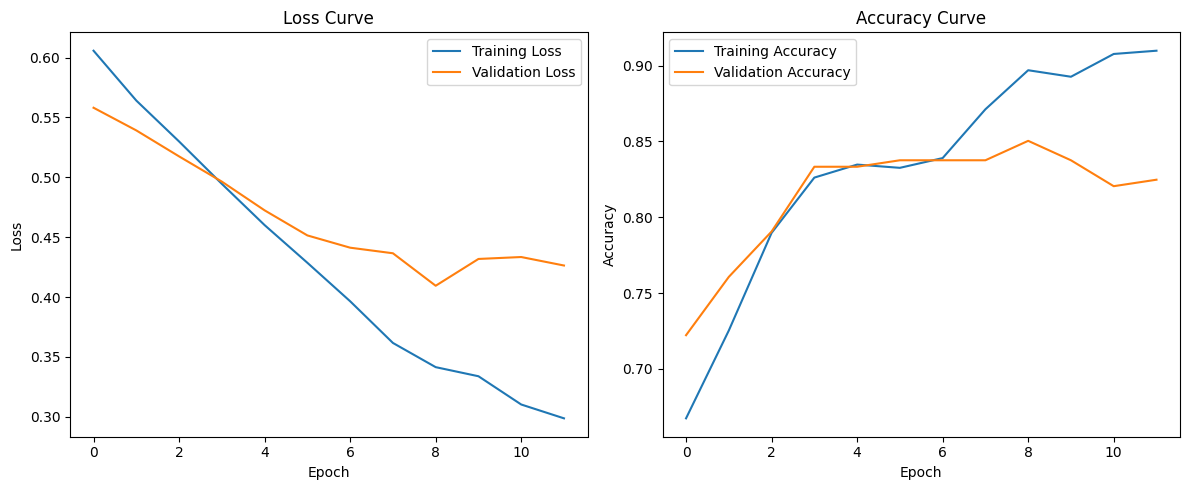

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

X_train_t = torch.tensor(X_train, dtype=torch.long)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.long)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(SimpleRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        return out.squeeze()

vocab_size = max_words
embedding_dim = 128
hidden_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleRNNModel(vocab_size, embedding_dim, hidden_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

epochs = 20
patience = 3
best_val_loss = float('inf')
counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X_batch.size(0)
        all_preds.extend((preds > 0.5).cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    train_loss = epoch_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)

    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_preds.extend((preds > 0.5).cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

model.load_state_dict(best_model_state)

model.eval()
with torch.no_grad():
    y_val_pred_prob = model(X_val_t.to(device)).cpu().numpy()
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"\nFinal Validation Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


3

Epoch 1: train_loss=0.6225, val_loss=0.5454, train_acc=0.7039, val_acc=0.8291
Epoch 2: train_loss=0.5721, val_loss=0.5313, train_acc=0.7854, val_acc=0.8205
Epoch 3: train_loss=0.5540, val_loss=0.5150, train_acc=0.7897, val_acc=0.8205
Epoch 4: train_loss=0.5296, val_loss=0.4968, train_acc=0.7961, val_acc=0.8248
Epoch 5: train_loss=0.5001, val_loss=0.4723, train_acc=0.8026, val_acc=0.8248
Epoch 6: train_loss=0.4591, val_loss=0.4335, train_acc=0.8026, val_acc=0.8291
Epoch 7: train_loss=0.4169, val_loss=0.4118, train_acc=0.8026, val_acc=0.8291
Epoch 8: train_loss=0.3685, val_loss=0.3868, train_acc=0.8412, val_acc=0.8333
Epoch 9: train_loss=0.3153, val_loss=0.3452, train_acc=0.8798, val_acc=0.8333
Epoch 10: train_loss=0.2519, val_loss=0.3562, train_acc=0.9163, val_acc=0.8632
Epoch 11: train_loss=0.1792, val_loss=0.2692, train_acc=0.9700, val_acc=0.8803
Epoch 12: train_loss=0.1783, val_loss=0.2115, train_acc=0.9828, val_acc=0.9103
Epoch 13: train_loss=0.1384, val_loss=0.2112, train_acc=0.987

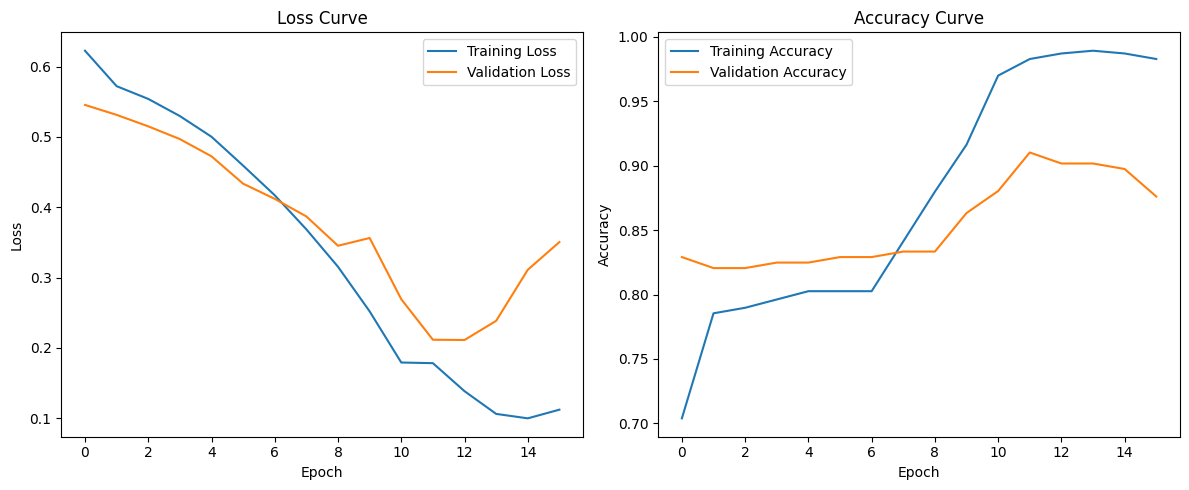

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

X_train_t = torch.tensor(X_train, dtype=torch.long)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.long)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)           # (batch, seq_len, embedding_dim)
        out, (hn, cn) = self.lstm(x)   # (batch, seq_len, hidden_size)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        return out.squeeze()

vocab_size = max_words
embedding_dim = 128
hidden_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(vocab_size, embedding_dim, hidden_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

epochs = 20
patience = 3
best_val_loss = float('inf')
counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X_batch.size(0)
        all_preds.extend((preds > 0.5).cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    train_loss = epoch_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)

    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_preds.extend((preds > 0.5).cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

model.load_state_dict(best_model_state)

model.eval()
with torch.no_grad():
    y_val_pred_prob = model(X_val_t.to(device)).cpu().numpy()
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"\nFinal Validation Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


4


Training model with max_len=80, embedding_dim=64, lstm_units=32, use_dropout=False
Epoch 1: train_loss=0.7024, val_loss=0.6575, train_acc=0.4657, val_acc=0.5812
Epoch 2: train_loss=0.6349, val_loss=0.6171, train_acc=0.6845, val_acc=0.6410
Epoch 3: train_loss=0.5959, val_loss=0.5916, train_acc=0.7361, val_acc=0.6923
Epoch 4: train_loss=0.5687, val_loss=0.5726, train_acc=0.7725, val_acc=0.7179
Epoch 5: train_loss=0.5450, val_loss=0.5563, train_acc=0.8176, val_acc=0.7564
Epoch 6: train_loss=0.5234, val_loss=0.5403, train_acc=0.8326, val_acc=0.7735
Epoch 7: train_loss=0.4993, val_loss=0.5208, train_acc=0.8283, val_acc=0.7821
Epoch 8: train_loss=0.4721, val_loss=0.4942, train_acc=0.8112, val_acc=0.7778
Epoch 9: train_loss=0.4429, val_loss=0.4611, train_acc=0.8004, val_acc=0.7906
Epoch 10: train_loss=0.4025, val_loss=0.4324, train_acc=0.8004, val_acc=0.7949
Epoch 11: train_loss=0.3664, val_loss=0.4018, train_acc=0.8283, val_acc=0.8162
Epoch 12: train_loss=0.3255, val_loss=0.3620, train_acc=

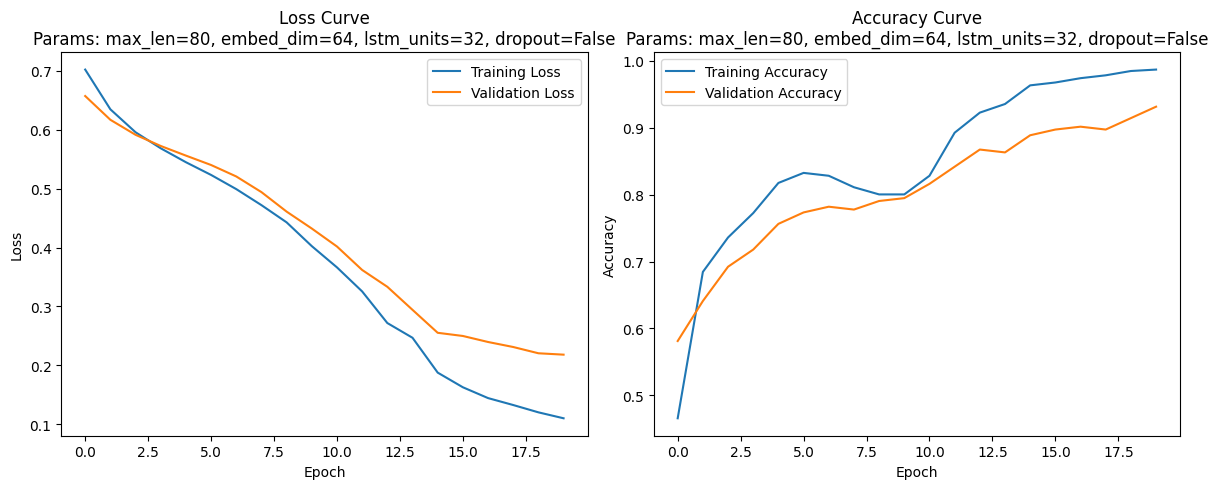


Training model with max_len=80, embedding_dim=64, lstm_units=32, use_dropout=True
Epoch 1: train_loss=0.6348, val_loss=0.6028, train_acc=0.6674, val_acc=0.6923
Epoch 2: train_loss=0.6014, val_loss=0.5785, train_acc=0.6910, val_acc=0.7265
Epoch 3: train_loss=0.5729, val_loss=0.5655, train_acc=0.7318, val_acc=0.7479
Epoch 4: train_loss=0.5512, val_loss=0.5573, train_acc=0.7682, val_acc=0.7607
Epoch 5: train_loss=0.5486, val_loss=0.5501, train_acc=0.7747, val_acc=0.7735
Epoch 6: train_loss=0.5298, val_loss=0.5418, train_acc=0.7833, val_acc=0.7863
Epoch 7: train_loss=0.5172, val_loss=0.5318, train_acc=0.7854, val_acc=0.7778
Epoch 8: train_loss=0.5107, val_loss=0.5185, train_acc=0.7876, val_acc=0.7778
Epoch 9: train_loss=0.4902, val_loss=0.4994, train_acc=0.7961, val_acc=0.7906
Epoch 10: train_loss=0.4769, val_loss=0.4788, train_acc=0.7961, val_acc=0.7906
Epoch 11: train_loss=0.4376, val_loss=0.4470, train_acc=0.8047, val_acc=0.7991
Epoch 12: train_loss=0.3947, val_loss=0.3895, train_acc=0

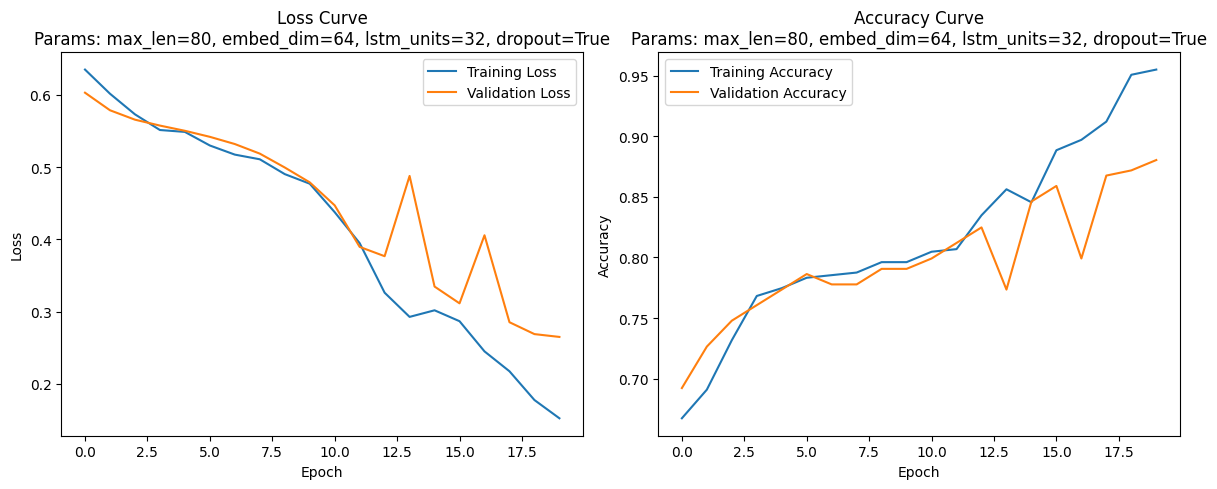


Training model with max_len=80, embedding_dim=64, lstm_units=64, use_dropout=False
Epoch 1: train_loss=0.6448, val_loss=0.5846, train_acc=0.7017, val_acc=0.7393
Epoch 2: train_loss=0.5668, val_loss=0.5545, train_acc=0.7618, val_acc=0.7479
Epoch 3: train_loss=0.5386, val_loss=0.5432, train_acc=0.7790, val_acc=0.7778
Epoch 4: train_loss=0.5172, val_loss=0.5261, train_acc=0.7897, val_acc=0.7778
Epoch 5: train_loss=0.4915, val_loss=0.4952, train_acc=0.7940, val_acc=0.7821
Epoch 6: train_loss=0.4522, val_loss=0.4684, train_acc=0.7918, val_acc=0.7949
Epoch 7: train_loss=0.4250, val_loss=0.4498, train_acc=0.7961, val_acc=0.7991
Epoch 8: train_loss=0.3866, val_loss=0.4232, train_acc=0.8197, val_acc=0.8077
Epoch 9: train_loss=0.3265, val_loss=0.3908, train_acc=0.8498, val_acc=0.8077
Epoch 10: train_loss=0.3114, val_loss=0.3688, train_acc=0.8927, val_acc=0.8248
Epoch 11: train_loss=0.3072, val_loss=0.4465, train_acc=0.8948, val_acc=0.8291
Epoch 12: train_loss=0.2852, val_loss=0.3399, train_acc=

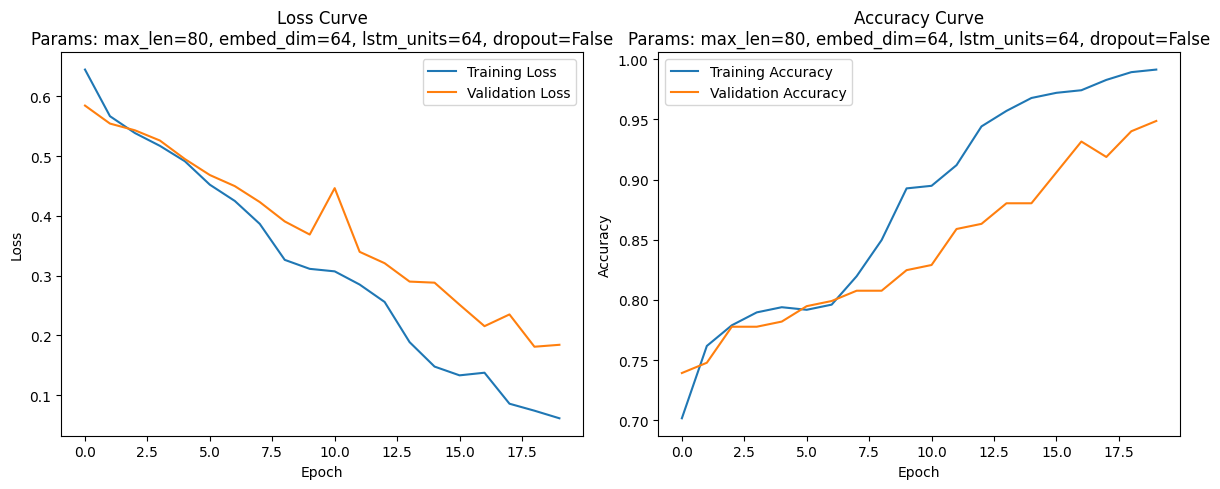


Training model with max_len=80, embedding_dim=64, lstm_units=64, use_dropout=True
Epoch 1: train_loss=0.6142, val_loss=0.5842, train_acc=0.6631, val_acc=0.6197
Epoch 2: train_loss=0.5675, val_loss=0.5714, train_acc=0.7597, val_acc=0.6838
Epoch 3: train_loss=0.5457, val_loss=0.5588, train_acc=0.7747, val_acc=0.7564
Epoch 4: train_loss=0.5258, val_loss=0.5374, train_acc=0.7876, val_acc=0.7778
Epoch 5: train_loss=0.4962, val_loss=0.4997, train_acc=0.7811, val_acc=0.7821
Epoch 6: train_loss=0.4519, val_loss=0.4715, train_acc=0.7854, val_acc=0.7906
Epoch 7: train_loss=0.4277, val_loss=0.4546, train_acc=0.7940, val_acc=0.7906
Epoch 8: train_loss=0.3794, val_loss=0.4133, train_acc=0.8283, val_acc=0.7863
Epoch 9: train_loss=0.3399, val_loss=0.3811, train_acc=0.8541, val_acc=0.8120
Epoch 10: train_loss=0.3027, val_loss=0.3721, train_acc=0.8798, val_acc=0.8120
Epoch 11: train_loss=0.2615, val_loss=0.3325, train_acc=0.9249, val_acc=0.8376
Epoch 12: train_loss=0.2801, val_loss=0.2935, train_acc=0

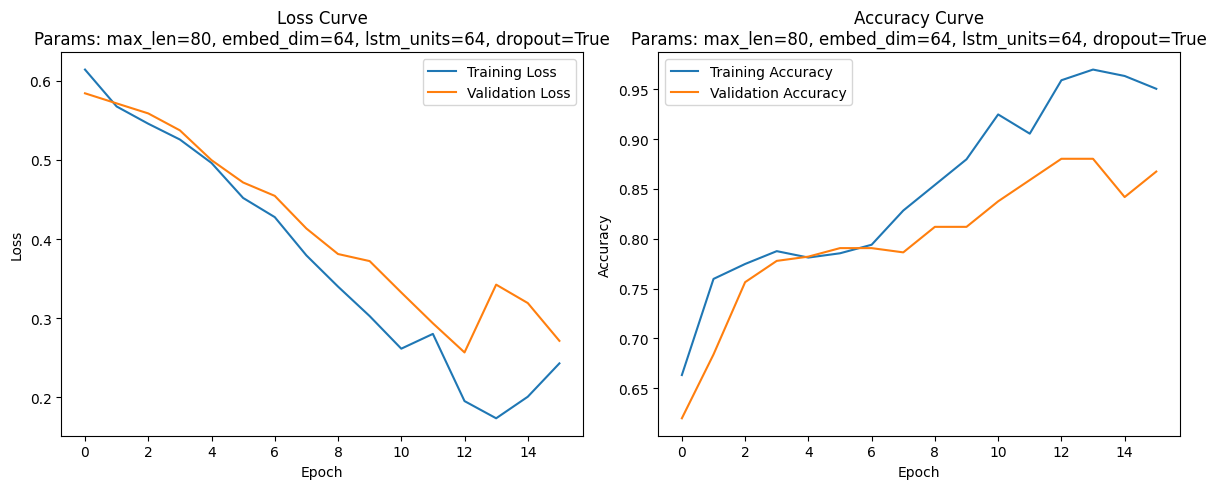


Training model with max_len=80, embedding_dim=64, lstm_units=128, use_dropout=False
Epoch 1: train_loss=0.6176, val_loss=0.5661, train_acc=0.7189, val_acc=0.7265
Epoch 2: train_loss=0.5549, val_loss=0.5542, train_acc=0.7704, val_acc=0.7735
Epoch 3: train_loss=0.5206, val_loss=0.5108, train_acc=0.7833, val_acc=0.7778
Epoch 4: train_loss=0.4679, val_loss=0.4592, train_acc=0.7833, val_acc=0.7949
Epoch 5: train_loss=0.4166, val_loss=0.4155, train_acc=0.7940, val_acc=0.8034
Epoch 6: train_loss=0.3438, val_loss=0.4155, train_acc=0.8305, val_acc=0.8162
Epoch 7: train_loss=0.3345, val_loss=0.3634, train_acc=0.8670, val_acc=0.8162
Epoch 8: train_loss=0.2928, val_loss=0.3605, train_acc=0.9056, val_acc=0.8333
Epoch 9: train_loss=0.3075, val_loss=0.3882, train_acc=0.9120, val_acc=0.8462
Epoch 10: train_loss=0.2940, val_loss=0.3931, train_acc=0.9270, val_acc=0.7906
Epoch 11: train_loss=0.2422, val_loss=0.3483, train_acc=0.9485, val_acc=0.8675
Epoch 12: train_loss=0.2561, val_loss=0.3920, train_acc

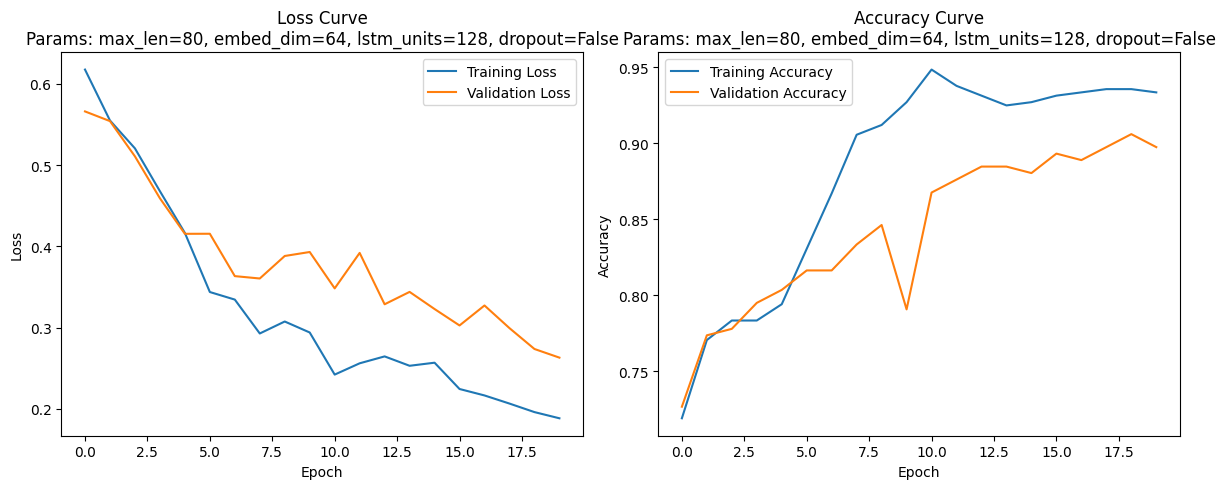


Training model with max_len=80, embedding_dim=64, lstm_units=128, use_dropout=True
Epoch 1: train_loss=0.6243, val_loss=0.5609, train_acc=0.6738, val_acc=0.7650
Epoch 2: train_loss=0.5506, val_loss=0.5501, train_acc=0.7639, val_acc=0.7821
Epoch 3: train_loss=0.5304, val_loss=0.5181, train_acc=0.7790, val_acc=0.7778
Epoch 4: train_loss=0.4883, val_loss=0.4772, train_acc=0.7811, val_acc=0.7949
Epoch 5: train_loss=0.4495, val_loss=0.4608, train_acc=0.7833, val_acc=0.7906
Epoch 6: train_loss=0.4026, val_loss=0.4134, train_acc=0.8026, val_acc=0.8034
Epoch 7: train_loss=0.3385, val_loss=0.3656, train_acc=0.8648, val_acc=0.8291
Epoch 8: train_loss=0.3120, val_loss=0.3808, train_acc=0.9077, val_acc=0.8632
Epoch 9: train_loss=0.2828, val_loss=0.3811, train_acc=0.9249, val_acc=0.8632
Epoch 10: train_loss=0.2823, val_loss=0.3613, train_acc=0.9206, val_acc=0.8547
Epoch 11: train_loss=0.2878, val_loss=0.3367, train_acc=0.9227, val_acc=0.8590
Epoch 12: train_loss=0.2357, val_loss=0.3042, train_acc=

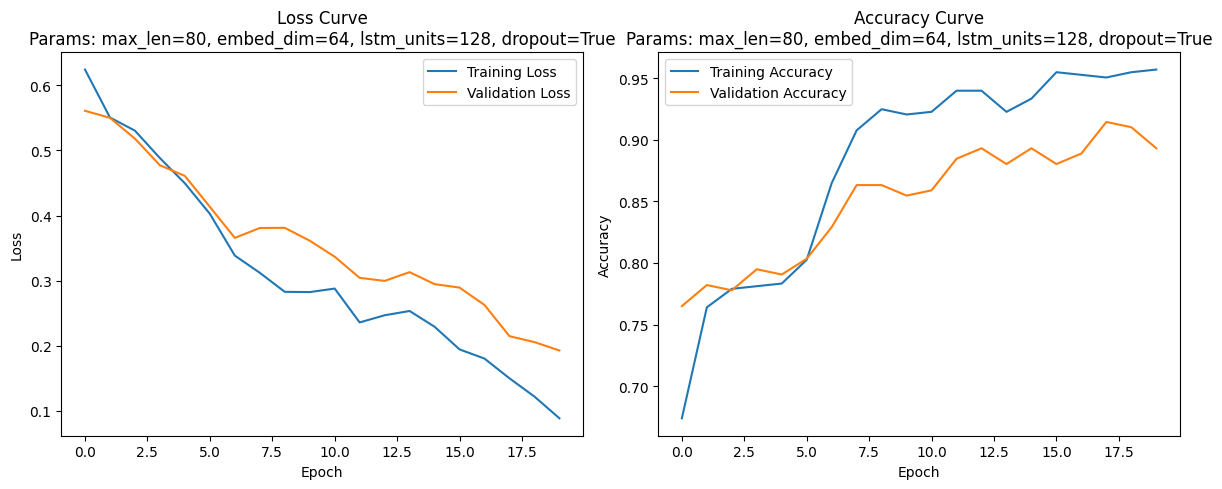


Training model with max_len=80, embedding_dim=128, lstm_units=32, use_dropout=False
Epoch 1: train_loss=0.6422, val_loss=0.5921, train_acc=0.7361, val_acc=0.7521
Epoch 2: train_loss=0.5681, val_loss=0.5615, train_acc=0.7876, val_acc=0.7735
Epoch 3: train_loss=0.5385, val_loss=0.5511, train_acc=0.8047, val_acc=0.7778
Epoch 4: train_loss=0.5193, val_loss=0.5434, train_acc=0.8155, val_acc=0.7692
Epoch 5: train_loss=0.5014, val_loss=0.5346, train_acc=0.8219, val_acc=0.7692
Epoch 6: train_loss=0.4827, val_loss=0.5241, train_acc=0.8305, val_acc=0.7821
Epoch 7: train_loss=0.4626, val_loss=0.5125, train_acc=0.8348, val_acc=0.7821
Epoch 8: train_loss=0.4385, val_loss=0.4981, train_acc=0.8412, val_acc=0.7863
Epoch 9: train_loss=0.4102, val_loss=0.4743, train_acc=0.8476, val_acc=0.7949
Epoch 10: train_loss=0.3714, val_loss=0.4443, train_acc=0.8648, val_acc=0.8034
Epoch 11: train_loss=0.3230, val_loss=0.4081, train_acc=0.8841, val_acc=0.8034
Epoch 12: train_loss=0.2702, val_loss=0.3660, train_acc

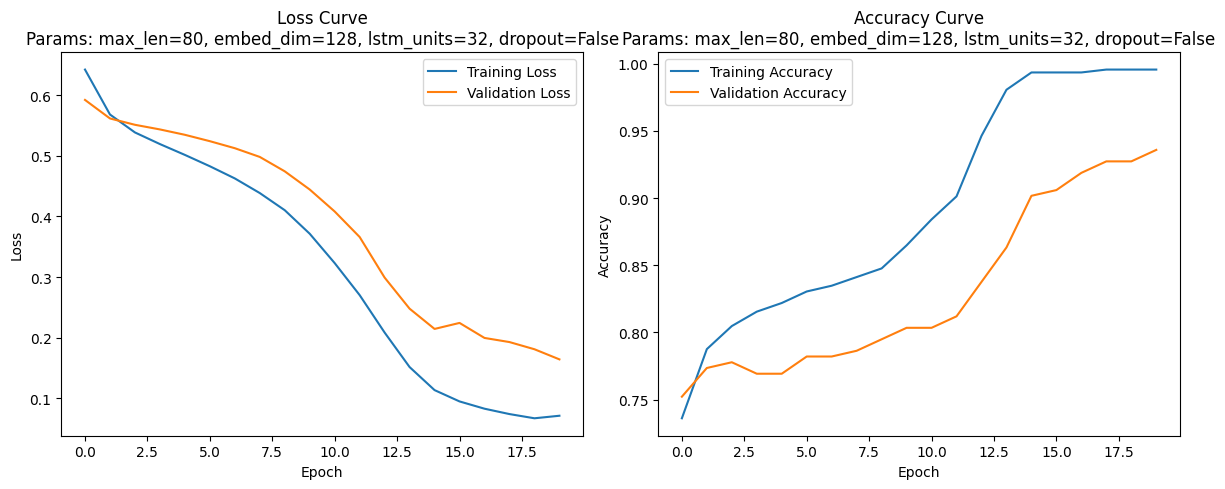


Training model with max_len=80, embedding_dim=128, lstm_units=32, use_dropout=True
Epoch 1: train_loss=0.6658, val_loss=0.6253, train_acc=0.5773, val_acc=0.5684
Epoch 2: train_loss=0.6022, val_loss=0.6040, train_acc=0.6245, val_acc=0.6111
Epoch 3: train_loss=0.5831, val_loss=0.5919, train_acc=0.6738, val_acc=0.6410
Epoch 4: train_loss=0.5710, val_loss=0.5835, train_acc=0.7446, val_acc=0.6581
Epoch 5: train_loss=0.5591, val_loss=0.5771, train_acc=0.7682, val_acc=0.6624
Epoch 6: train_loss=0.5339, val_loss=0.5702, train_acc=0.8112, val_acc=0.6752
Epoch 7: train_loss=0.5265, val_loss=0.5627, train_acc=0.8476, val_acc=0.7137
Epoch 8: train_loss=0.5156, val_loss=0.5533, train_acc=0.8476, val_acc=0.7436
Epoch 9: train_loss=0.4969, val_loss=0.5426, train_acc=0.8584, val_acc=0.7521
Epoch 10: train_loss=0.4809, val_loss=0.5292, train_acc=0.8670, val_acc=0.7607
Epoch 11: train_loss=0.4403, val_loss=0.5110, train_acc=0.8712, val_acc=0.7778
Epoch 12: train_loss=0.4246, val_loss=0.4830, train_acc=

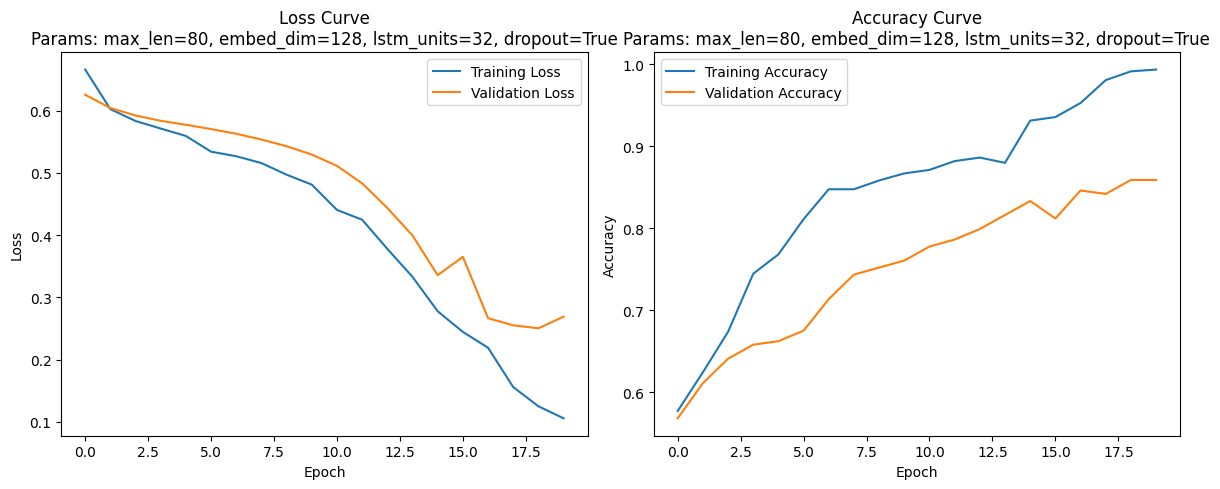


Training model with max_len=80, embedding_dim=128, lstm_units=64, use_dropout=False
Epoch 1: train_loss=0.6201, val_loss=0.5693, train_acc=0.6931, val_acc=0.7350
Epoch 2: train_loss=0.5524, val_loss=0.5593, train_acc=0.7768, val_acc=0.7735
Epoch 3: train_loss=0.5323, val_loss=0.5494, train_acc=0.8219, val_acc=0.7821
Epoch 4: train_loss=0.5095, val_loss=0.5346, train_acc=0.8348, val_acc=0.7906
Epoch 5: train_loss=0.4826, val_loss=0.5177, train_acc=0.8348, val_acc=0.7863
Epoch 6: train_loss=0.4503, val_loss=0.4920, train_acc=0.8391, val_acc=0.7906
Epoch 7: train_loss=0.4027, val_loss=0.4498, train_acc=0.8412, val_acc=0.7991
Epoch 8: train_loss=0.3432, val_loss=0.3974, train_acc=0.8412, val_acc=0.8034
Epoch 9: train_loss=0.2459, val_loss=0.2795, train_acc=0.9056, val_acc=0.8462
Epoch 10: train_loss=0.1769, val_loss=0.2624, train_acc=0.9678, val_acc=0.8632
Epoch 11: train_loss=0.1544, val_loss=0.2737, train_acc=0.9807, val_acc=0.8675
Epoch 12: train_loss=0.1211, val_loss=0.3326, train_acc

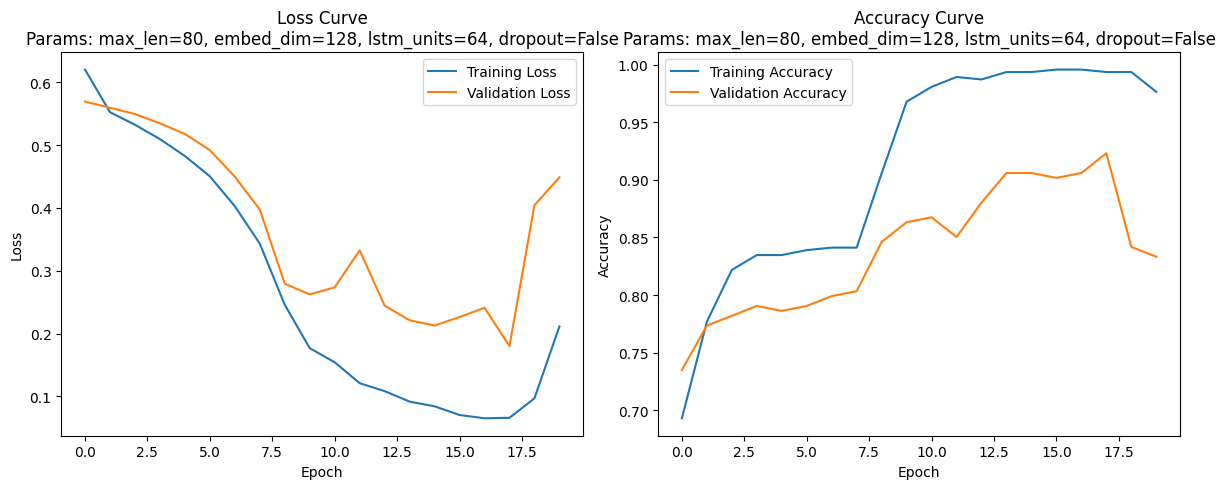


Training model with max_len=80, embedding_dim=128, lstm_units=64, use_dropout=True
Epoch 1: train_loss=0.6605, val_loss=0.5869, train_acc=0.5558, val_acc=0.6667
Epoch 2: train_loss=0.5723, val_loss=0.5697, train_acc=0.7039, val_acc=0.7009
Epoch 3: train_loss=0.5487, val_loss=0.5613, train_acc=0.7489, val_acc=0.7607
Epoch 4: train_loss=0.5339, val_loss=0.5487, train_acc=0.8133, val_acc=0.7650
Epoch 5: train_loss=0.5022, val_loss=0.5306, train_acc=0.8176, val_acc=0.7821
Epoch 6: train_loss=0.4735, val_loss=0.5064, train_acc=0.8262, val_acc=0.7906
Epoch 7: train_loss=0.4423, val_loss=0.4616, train_acc=0.8112, val_acc=0.7906
Epoch 8: train_loss=0.3831, val_loss=0.4179, train_acc=0.8176, val_acc=0.7991
Epoch 9: train_loss=0.3126, val_loss=0.3636, train_acc=0.8627, val_acc=0.8077
Epoch 10: train_loss=0.2686, val_loss=0.3565, train_acc=0.8970, val_acc=0.8248
Epoch 11: train_loss=0.2692, val_loss=0.3017, train_acc=0.9378, val_acc=0.8462
Epoch 12: train_loss=0.2120, val_loss=0.2910, train_acc=

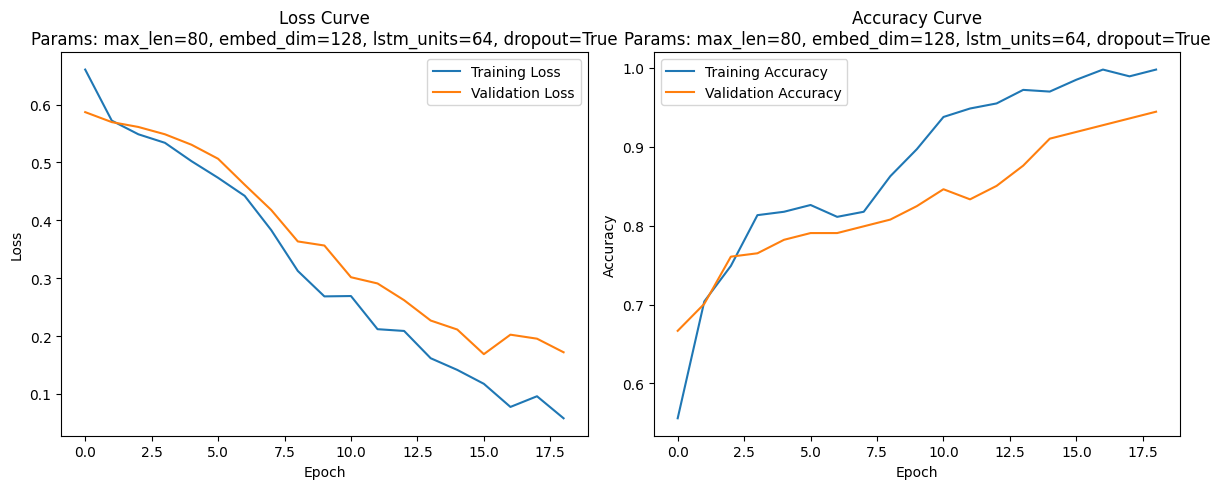


Training model with max_len=80, embedding_dim=128, lstm_units=128, use_dropout=False
Epoch 1: train_loss=0.6039, val_loss=0.5755, train_acc=0.6888, val_acc=0.7009
Epoch 2: train_loss=0.5449, val_loss=0.5508, train_acc=0.7854, val_acc=0.7436
Epoch 3: train_loss=0.4995, val_loss=0.5186, train_acc=0.8026, val_acc=0.7778
Epoch 4: train_loss=0.4346, val_loss=0.4717, train_acc=0.8047, val_acc=0.7906
Epoch 5: train_loss=0.3797, val_loss=0.4437, train_acc=0.8112, val_acc=0.7778
Epoch 6: train_loss=0.3156, val_loss=0.4369, train_acc=0.8777, val_acc=0.8034
Epoch 7: train_loss=0.2939, val_loss=0.3835, train_acc=0.9099, val_acc=0.8077
Epoch 8: train_loss=0.2403, val_loss=0.4274, train_acc=0.9399, val_acc=0.8376
Epoch 9: train_loss=0.2538, val_loss=0.4224, train_acc=0.9378, val_acc=0.8376
Epoch 10: train_loss=0.2982, val_loss=0.4133, train_acc=0.9464, val_acc=0.8333
Early stopping triggered
Test Accuracy: 0.7967, Precision: 0.8346, Recall: 0.7400, F1-score: 0.7845


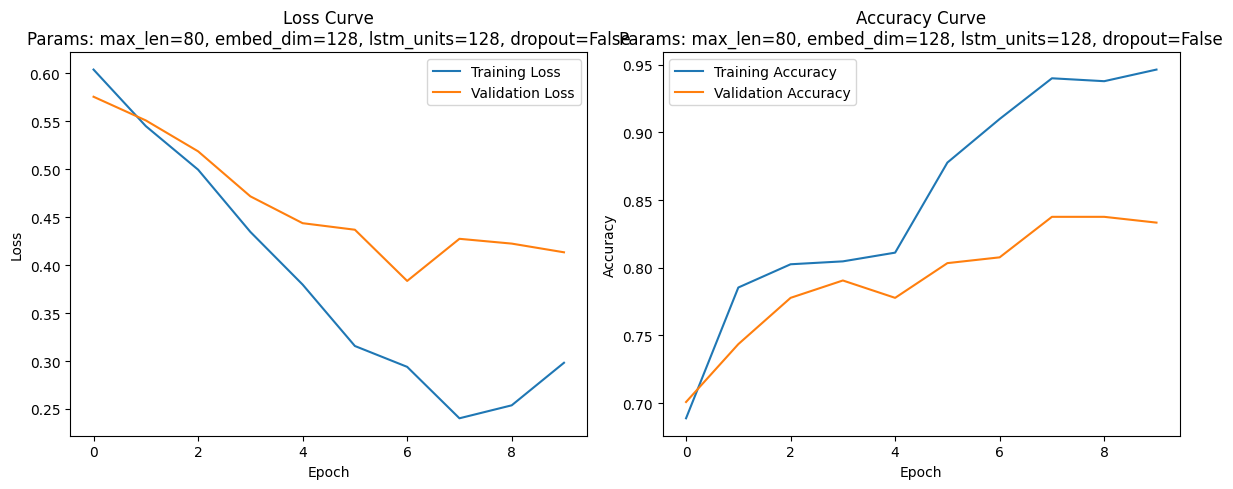


Training model with max_len=80, embedding_dim=128, lstm_units=128, use_dropout=True
Epoch 1: train_loss=0.6143, val_loss=0.5672, train_acc=0.6717, val_acc=0.7222
Epoch 2: train_loss=0.5469, val_loss=0.5540, train_acc=0.7747, val_acc=0.7436
Epoch 3: train_loss=0.5257, val_loss=0.5321, train_acc=0.8026, val_acc=0.7692
Epoch 4: train_loss=0.4748, val_loss=0.4783, train_acc=0.8047, val_acc=0.7949
Epoch 5: train_loss=0.4072, val_loss=0.4429, train_acc=0.7983, val_acc=0.7991
Epoch 6: train_loss=0.3508, val_loss=0.3901, train_acc=0.8691, val_acc=0.8248
Epoch 7: train_loss=0.3154, val_loss=0.4050, train_acc=0.9120, val_acc=0.8034
Epoch 8: train_loss=0.2837, val_loss=0.3491, train_acc=0.9356, val_acc=0.8333
Epoch 9: train_loss=0.1841, val_loss=0.3067, train_acc=0.9571, val_acc=0.8590
Epoch 10: train_loss=0.1529, val_loss=0.4049, train_acc=0.9721, val_acc=0.8846
Epoch 11: train_loss=0.2557, val_loss=0.4240, train_acc=0.9635, val_acc=0.8761
Epoch 12: train_loss=0.1377, val_loss=0.3373, train_acc

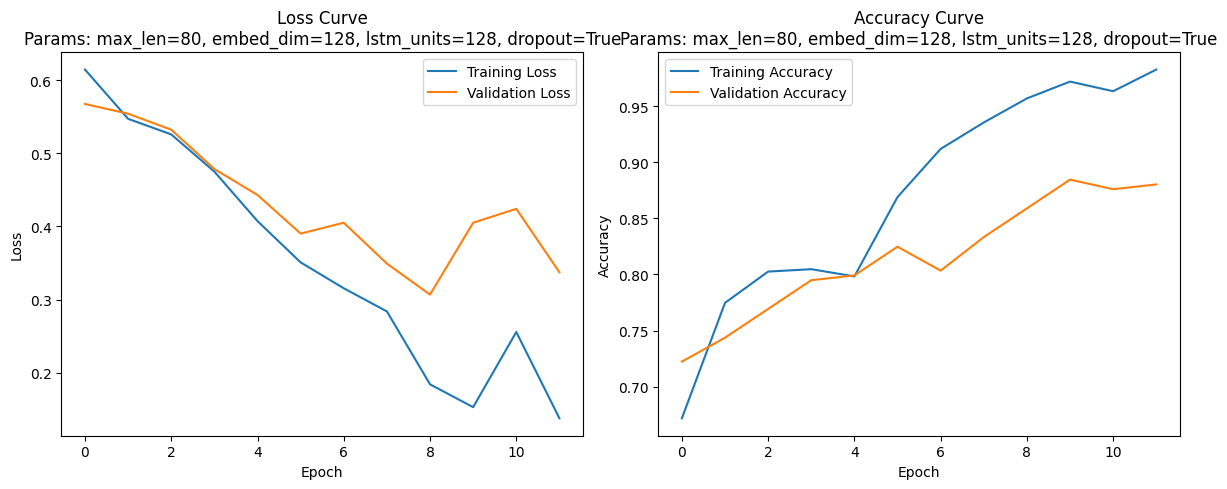


Training model with max_len=80, embedding_dim=256, lstm_units=32, use_dropout=False
Epoch 1: train_loss=0.6093, val_loss=0.5898, train_acc=0.5966, val_acc=0.6239
Epoch 2: train_loss=0.5621, val_loss=0.5784, train_acc=0.7082, val_acc=0.6709
Epoch 3: train_loss=0.5361, val_loss=0.5686, train_acc=0.8197, val_acc=0.6880
Epoch 4: train_loss=0.5109, val_loss=0.5556, train_acc=0.8712, val_acc=0.7222
Epoch 5: train_loss=0.4804, val_loss=0.5467, train_acc=0.9142, val_acc=0.7564
Epoch 6: train_loss=0.4463, val_loss=0.5199, train_acc=0.9335, val_acc=0.7650
Epoch 7: train_loss=0.4179, val_loss=0.4984, train_acc=0.9378, val_acc=0.7949
Epoch 8: train_loss=0.3807, val_loss=0.4727, train_acc=0.9464, val_acc=0.8120
Epoch 9: train_loss=0.3450, val_loss=0.4384, train_acc=0.9485, val_acc=0.8205
Epoch 10: train_loss=0.2950, val_loss=0.3949, train_acc=0.9528, val_acc=0.8248
Epoch 11: train_loss=0.2455, val_loss=0.3475, train_acc=0.9571, val_acc=0.8547
Epoch 12: train_loss=0.1909, val_loss=0.2988, train_acc

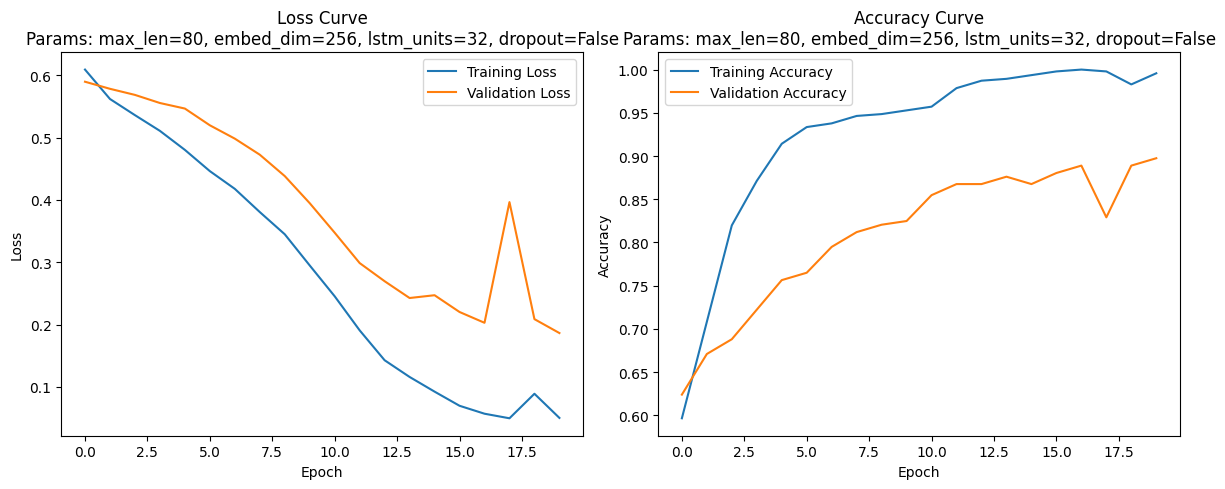


Training model with max_len=80, embedding_dim=256, lstm_units=32, use_dropout=True
Epoch 1: train_loss=0.6579, val_loss=0.6085, train_acc=0.6395, val_acc=0.7393
Epoch 2: train_loss=0.5793, val_loss=0.5777, train_acc=0.7704, val_acc=0.7479
Epoch 3: train_loss=0.5513, val_loss=0.5649, train_acc=0.8047, val_acc=0.7564
Epoch 4: train_loss=0.5230, val_loss=0.5556, train_acc=0.8262, val_acc=0.7607
Epoch 5: train_loss=0.5115, val_loss=0.5544, train_acc=0.8519, val_acc=0.7607
Epoch 6: train_loss=0.4908, val_loss=0.5415, train_acc=0.8648, val_acc=0.7650
Epoch 7: train_loss=0.4748, val_loss=0.5323, train_acc=0.8863, val_acc=0.7692
Epoch 8: train_loss=0.4542, val_loss=0.5215, train_acc=0.8798, val_acc=0.7692
Epoch 9: train_loss=0.4288, val_loss=0.5104, train_acc=0.9099, val_acc=0.7692
Epoch 10: train_loss=0.3955, val_loss=0.4985, train_acc=0.9270, val_acc=0.7778
Epoch 11: train_loss=0.3825, val_loss=0.4809, train_acc=0.9185, val_acc=0.7821
Epoch 12: train_loss=0.3526, val_loss=0.4645, train_acc=

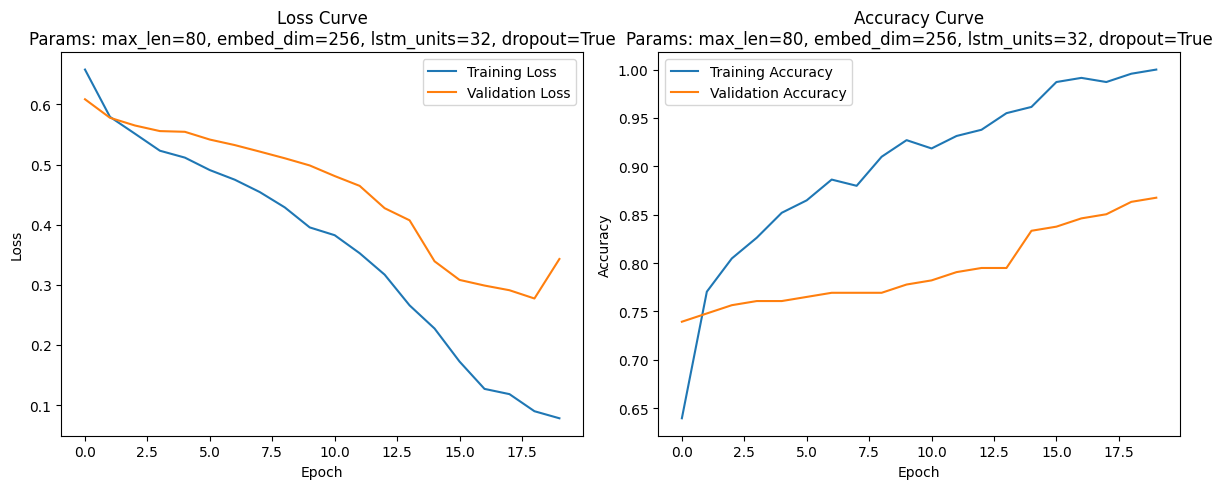


Training model with max_len=80, embedding_dim=256, lstm_units=64, use_dropout=False
Epoch 1: train_loss=0.6432, val_loss=0.5772, train_acc=0.5966, val_acc=0.7094
Epoch 2: train_loss=0.5489, val_loss=0.5598, train_acc=0.7918, val_acc=0.7436
Epoch 3: train_loss=0.5172, val_loss=0.5470, train_acc=0.8648, val_acc=0.7650
Epoch 4: train_loss=0.4806, val_loss=0.5272, train_acc=0.9034, val_acc=0.7906
Epoch 5: train_loss=0.4412, val_loss=0.5014, train_acc=0.9120, val_acc=0.7991
Epoch 6: train_loss=0.3921, val_loss=0.4554, train_acc=0.9120, val_acc=0.8034
Epoch 7: train_loss=0.3176, val_loss=0.3814, train_acc=0.9163, val_acc=0.8120
Epoch 8: train_loss=0.2400, val_loss=0.3227, train_acc=0.9185, val_acc=0.8333
Epoch 9: train_loss=0.1576, val_loss=0.2465, train_acc=0.9785, val_acc=0.8718
Epoch 10: train_loss=0.1008, val_loss=0.2027, train_acc=0.9936, val_acc=0.8974
Epoch 11: train_loss=0.0795, val_loss=0.2032, train_acc=0.9957, val_acc=0.8932
Epoch 12: train_loss=0.0690, val_loss=0.2070, train_acc

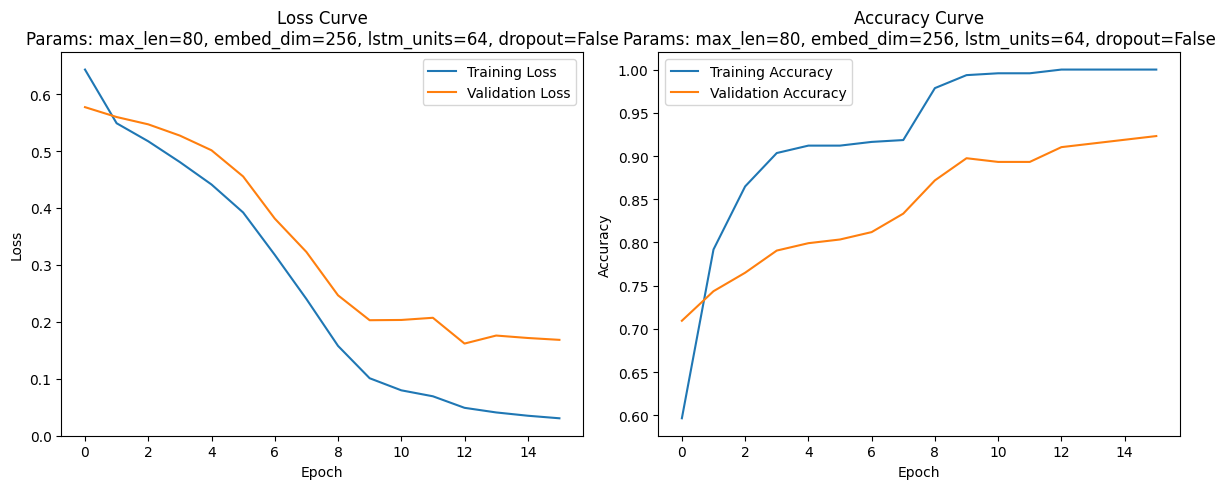


Training model with max_len=80, embedding_dim=256, lstm_units=64, use_dropout=True
Epoch 1: train_loss=0.6216, val_loss=0.5904, train_acc=0.5987, val_acc=0.5983
Epoch 2: train_loss=0.5662, val_loss=0.5808, train_acc=0.7232, val_acc=0.6410
Epoch 3: train_loss=0.5415, val_loss=0.5669, train_acc=0.7876, val_acc=0.6795
Epoch 4: train_loss=0.5052, val_loss=0.5478, train_acc=0.8648, val_acc=0.7479
Epoch 5: train_loss=0.4815, val_loss=0.5215, train_acc=0.8777, val_acc=0.7650
Epoch 6: train_loss=0.4332, val_loss=0.4893, train_acc=0.9034, val_acc=0.7991
Epoch 7: train_loss=0.3803, val_loss=0.4356, train_acc=0.9077, val_acc=0.8077
Epoch 8: train_loss=0.3024, val_loss=0.3801, train_acc=0.9077, val_acc=0.8162
Epoch 9: train_loss=0.2155, val_loss=0.2861, train_acc=0.9464, val_acc=0.8675
Epoch 10: train_loss=0.1504, val_loss=0.2190, train_acc=0.9807, val_acc=0.8932
Epoch 11: train_loss=0.0987, val_loss=0.2054, train_acc=0.9936, val_acc=0.9060
Epoch 12: train_loss=0.0833, val_loss=0.2750, train_acc=

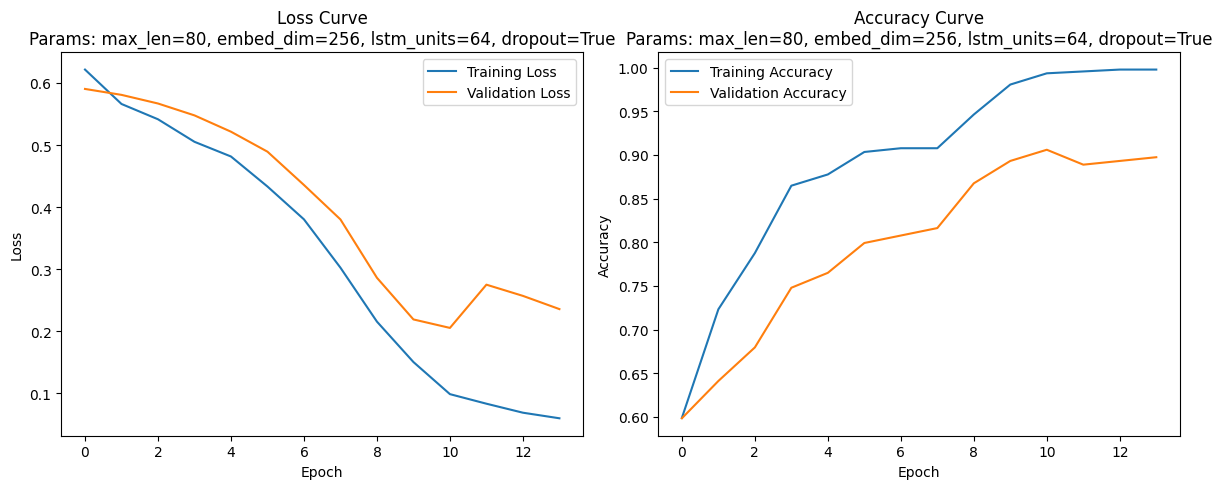


Training model with max_len=80, embedding_dim=256, lstm_units=128, use_dropout=False
Epoch 1: train_loss=0.5928, val_loss=0.5643, train_acc=0.7275, val_acc=0.7436
Epoch 2: train_loss=0.5205, val_loss=0.5438, train_acc=0.8133, val_acc=0.7607
Epoch 3: train_loss=0.4705, val_loss=0.5095, train_acc=0.8391, val_acc=0.7692
Epoch 4: train_loss=0.3929, val_loss=0.4224, train_acc=0.8519, val_acc=0.7949
Epoch 5: train_loss=0.3078, val_loss=0.3823, train_acc=0.8734, val_acc=0.7949
Epoch 6: train_loss=0.2313, val_loss=0.4643, train_acc=0.9442, val_acc=0.8205
Epoch 7: train_loss=0.2099, val_loss=0.2201, train_acc=0.9485, val_acc=0.8803
Epoch 8: train_loss=0.1168, val_loss=0.1972, train_acc=0.9828, val_acc=0.9274
Epoch 9: train_loss=0.0887, val_loss=0.1442, train_acc=0.9850, val_acc=0.9530
Epoch 10: train_loss=0.1488, val_loss=0.3360, train_acc=0.9742, val_acc=0.8590
Epoch 11: train_loss=0.1498, val_loss=0.2905, train_acc=0.9742, val_acc=0.8889
Epoch 12: train_loss=0.1204, val_loss=0.2632, train_ac

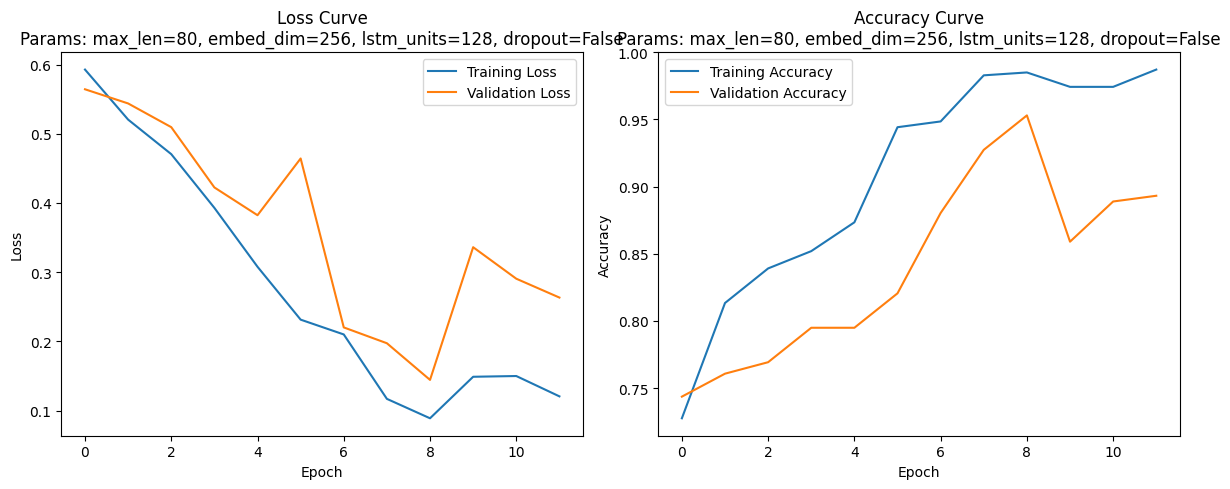


Training model with max_len=80, embedding_dim=256, lstm_units=128, use_dropout=True
Epoch 1: train_loss=0.5988, val_loss=0.5658, train_acc=0.6567, val_acc=0.7265
Epoch 2: train_loss=0.5295, val_loss=0.5514, train_acc=0.8004, val_acc=0.7692
Epoch 3: train_loss=0.4871, val_loss=0.5247, train_acc=0.8433, val_acc=0.7521
Epoch 4: train_loss=0.4324, val_loss=0.4768, train_acc=0.8541, val_acc=0.7778
Epoch 5: train_loss=0.3677, val_loss=0.4211, train_acc=0.8326, val_acc=0.7949
Epoch 6: train_loss=0.3077, val_loss=0.4066, train_acc=0.8948, val_acc=0.8077
Epoch 7: train_loss=0.2513, val_loss=0.3050, train_acc=0.9399, val_acc=0.8718
Epoch 8: train_loss=0.1448, val_loss=0.2564, train_acc=0.9828, val_acc=0.8632
Epoch 9: train_loss=0.1195, val_loss=0.3265, train_acc=0.9828, val_acc=0.8504
Epoch 10: train_loss=0.1630, val_loss=0.2361, train_acc=0.9614, val_acc=0.8675
Epoch 11: train_loss=0.1184, val_loss=0.1919, train_acc=0.9657, val_acc=0.8889
Epoch 12: train_loss=0.0759, val_loss=0.2021, train_acc

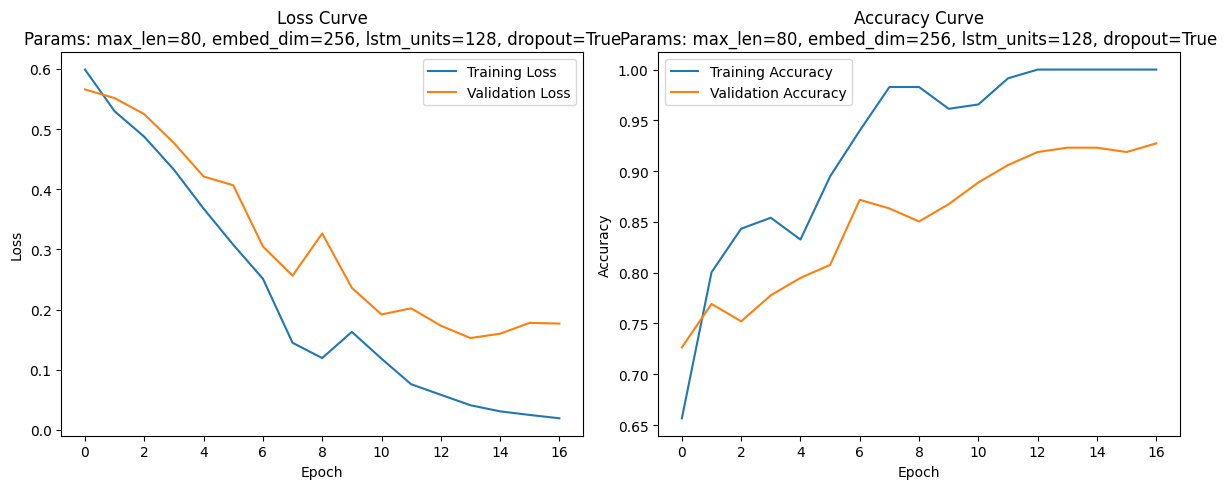


Training model with max_len=100, embedding_dim=64, lstm_units=32, use_dropout=False
Epoch 1: train_loss=0.6825, val_loss=0.6350, train_acc=0.4764, val_acc=0.5043
Epoch 2: train_loss=0.6316, val_loss=0.5959, train_acc=0.5408, val_acc=0.5342
Epoch 3: train_loss=0.6070, val_loss=0.5797, train_acc=0.5858, val_acc=0.6197
Epoch 4: train_loss=0.5938, val_loss=0.5684, train_acc=0.6867, val_acc=0.6880
Epoch 5: train_loss=0.5832, val_loss=0.5560, train_acc=0.7489, val_acc=0.7607
Epoch 6: train_loss=0.5693, val_loss=0.5428, train_acc=0.8026, val_acc=0.7863
Epoch 7: train_loss=0.5538, val_loss=0.5274, train_acc=0.8240, val_acc=0.8120
Epoch 8: train_loss=0.5345, val_loss=0.5078, train_acc=0.8197, val_acc=0.8205
Epoch 9: train_loss=0.5093, val_loss=0.4831, train_acc=0.8069, val_acc=0.8291
Epoch 10: train_loss=0.4764, val_loss=0.4506, train_acc=0.7983, val_acc=0.8291
Epoch 11: train_loss=0.4458, val_loss=0.4285, train_acc=0.7833, val_acc=0.8291
Epoch 12: train_loss=0.3994, val_loss=0.4011, train_acc

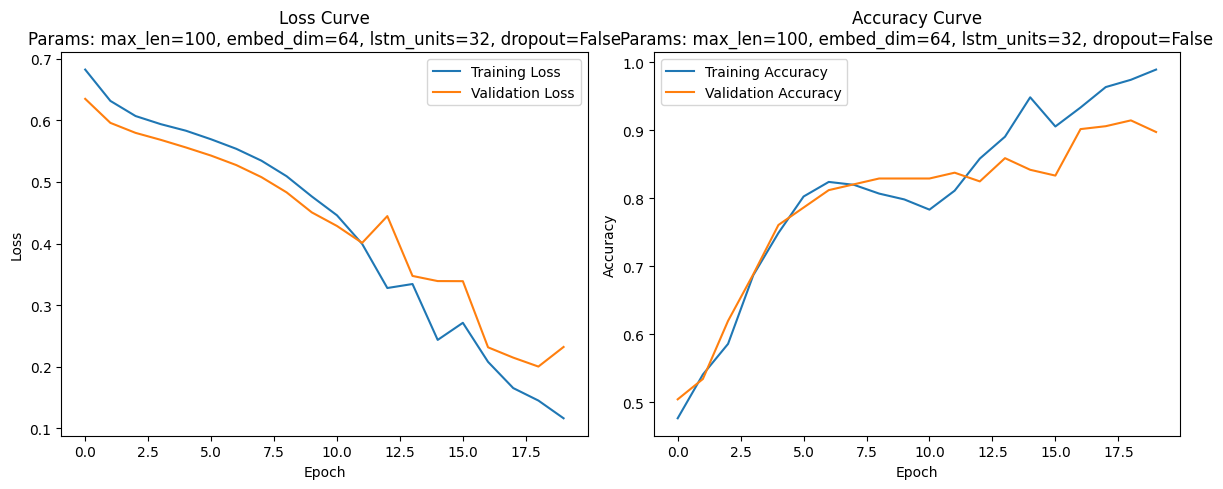


Training model with max_len=100, embedding_dim=64, lstm_units=32, use_dropout=True
Epoch 1: train_loss=0.6630, val_loss=0.6098, train_acc=0.6352, val_acc=0.8120
Epoch 2: train_loss=0.6130, val_loss=0.5670, train_acc=0.7318, val_acc=0.8162
Epoch 3: train_loss=0.5940, val_loss=0.5449, train_acc=0.7532, val_acc=0.8205
Epoch 4: train_loss=0.5854, val_loss=0.5325, train_acc=0.7468, val_acc=0.8248
Epoch 5: train_loss=0.5850, val_loss=0.5238, train_acc=0.7682, val_acc=0.8248
Epoch 6: train_loss=0.5520, val_loss=0.5160, train_acc=0.7747, val_acc=0.8291
Epoch 7: train_loss=0.5441, val_loss=0.5076, train_acc=0.7768, val_acc=0.8291
Epoch 8: train_loss=0.5424, val_loss=0.4977, train_acc=0.7747, val_acc=0.8291
Epoch 9: train_loss=0.5372, val_loss=0.4868, train_acc=0.7790, val_acc=0.8291
Epoch 10: train_loss=0.5167, val_loss=0.4744, train_acc=0.7768, val_acc=0.8291
Epoch 11: train_loss=0.5047, val_loss=0.4602, train_acc=0.7790, val_acc=0.8333
Epoch 12: train_loss=0.4818, val_loss=0.4299, train_acc=

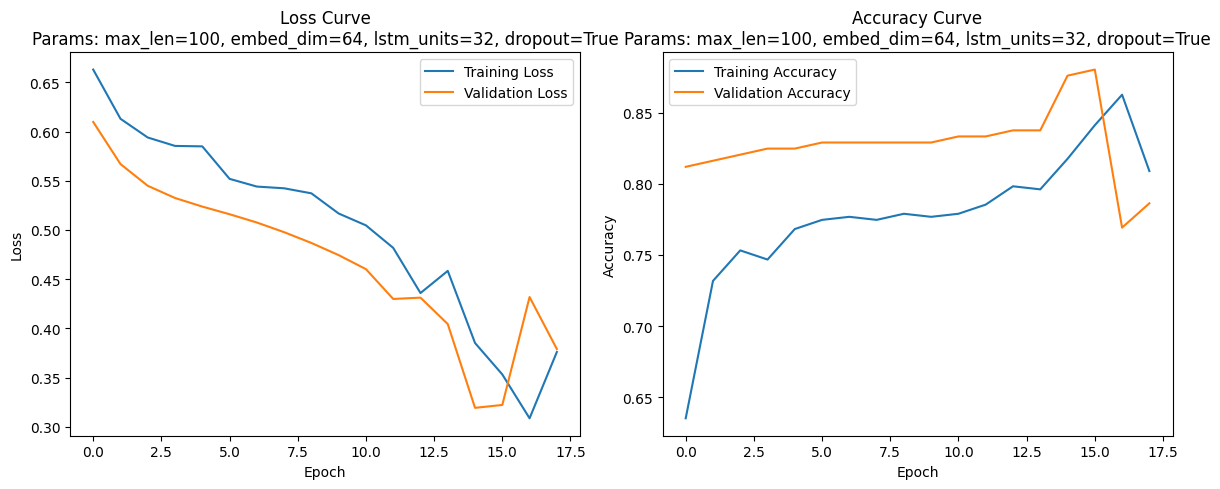


Training model with max_len=100, embedding_dim=64, lstm_units=64, use_dropout=False
Epoch 1: train_loss=0.6566, val_loss=0.5916, train_acc=0.6330, val_acc=0.7179
Epoch 2: train_loss=0.5921, val_loss=0.5542, train_acc=0.7382, val_acc=0.7821
Epoch 3: train_loss=0.5747, val_loss=0.5386, train_acc=0.7725, val_acc=0.8162
Epoch 4: train_loss=0.5618, val_loss=0.5215, train_acc=0.7854, val_acc=0.8333
Epoch 5: train_loss=0.5397, val_loss=0.5004, train_acc=0.7833, val_acc=0.8291
Epoch 6: train_loss=0.5077, val_loss=0.4546, train_acc=0.7790, val_acc=0.8291
Epoch 7: train_loss=0.4791, val_loss=0.4376, train_acc=0.7790, val_acc=0.8333
Epoch 8: train_loss=0.4455, val_loss=0.4295, train_acc=0.7854, val_acc=0.8333
Epoch 9: train_loss=0.4026, val_loss=0.3946, train_acc=0.7918, val_acc=0.8333
Epoch 10: train_loss=0.3548, val_loss=0.3514, train_acc=0.8305, val_acc=0.8504
Epoch 11: train_loss=0.3241, val_loss=0.3600, train_acc=0.8820, val_acc=0.8462
Epoch 12: train_loss=0.2654, val_loss=0.4233, train_acc

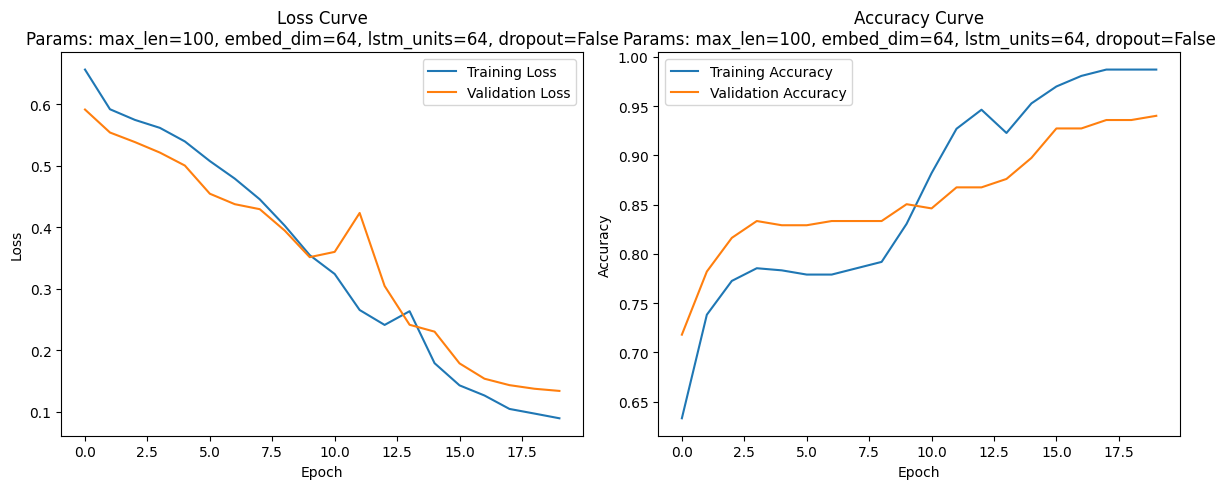


Training model with max_len=100, embedding_dim=64, lstm_units=64, use_dropout=True
Epoch 1: train_loss=0.6601, val_loss=0.6038, train_acc=0.5343, val_acc=0.5598
Epoch 2: train_loss=0.6181, val_loss=0.5745, train_acc=0.5966, val_acc=0.6154
Epoch 3: train_loss=0.5933, val_loss=0.5590, train_acc=0.6631, val_acc=0.7222
Epoch 4: train_loss=0.5853, val_loss=0.5422, train_acc=0.7403, val_acc=0.8034
Epoch 5: train_loss=0.5649, val_loss=0.5221, train_acc=0.7876, val_acc=0.8162
Epoch 6: train_loss=0.5373, val_loss=0.4884, train_acc=0.7876, val_acc=0.8248
Epoch 7: train_loss=0.4997, val_loss=0.4397, train_acc=0.7854, val_acc=0.8333
Epoch 8: train_loss=0.4668, val_loss=0.4301, train_acc=0.7833, val_acc=0.8333
Epoch 9: train_loss=0.4374, val_loss=0.3927, train_acc=0.8069, val_acc=0.8333
Epoch 10: train_loss=0.3794, val_loss=0.3443, train_acc=0.8176, val_acc=0.8419
Epoch 11: train_loss=0.3483, val_loss=0.3797, train_acc=0.8648, val_acc=0.8248
Epoch 12: train_loss=0.3607, val_loss=0.2901, train_acc=

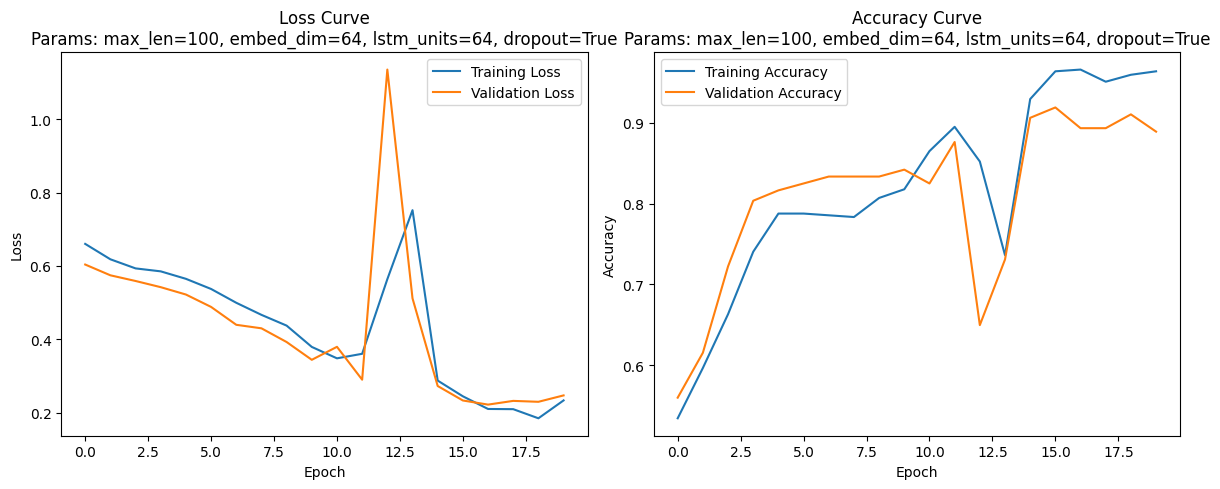


Training model with max_len=100, embedding_dim=64, lstm_units=128, use_dropout=False
Epoch 1: train_loss=0.6319, val_loss=0.5658, train_acc=0.5773, val_acc=0.7051
Epoch 2: train_loss=0.5983, val_loss=0.5428, train_acc=0.7639, val_acc=0.8077
Epoch 3: train_loss=0.5571, val_loss=0.5070, train_acc=0.7897, val_acc=0.8333
Epoch 4: train_loss=0.5091, val_loss=0.4433, train_acc=0.7768, val_acc=0.8291
Epoch 5: train_loss=0.4909, val_loss=0.4547, train_acc=0.7747, val_acc=0.8291
Epoch 6: train_loss=0.4715, val_loss=0.4357, train_acc=0.7876, val_acc=0.8291
Epoch 7: train_loss=0.4419, val_loss=0.4032, train_acc=0.7897, val_acc=0.8376
Epoch 8: train_loss=0.4081, val_loss=0.4142, train_acc=0.8219, val_acc=0.8504
Epoch 9: train_loss=0.3587, val_loss=0.4590, train_acc=0.8476, val_acc=0.8462
Epoch 10: train_loss=0.3509, val_loss=0.4135, train_acc=0.8627, val_acc=0.8419
Early stopping triggered
Test Accuracy: 0.8000, Precision: 0.8409, Recall: 0.7400, F1-score: 0.7872


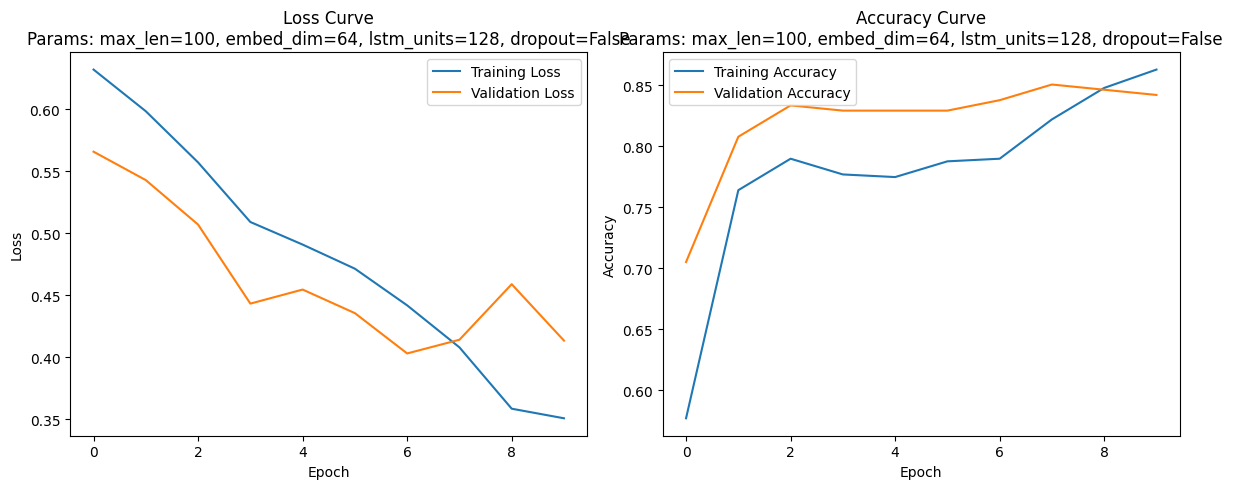


Training model with max_len=100, embedding_dim=64, lstm_units=128, use_dropout=True
Epoch 1: train_loss=0.6409, val_loss=0.5490, train_acc=0.6609, val_acc=0.7778
Epoch 2: train_loss=0.5835, val_loss=0.5281, train_acc=0.7532, val_acc=0.8248
Epoch 3: train_loss=0.5540, val_loss=0.4972, train_acc=0.7854, val_acc=0.8248
Epoch 4: train_loss=0.5139, val_loss=0.4360, train_acc=0.7747, val_acc=0.8333
Epoch 5: train_loss=0.4838, val_loss=0.4369, train_acc=0.7768, val_acc=0.8333
Epoch 6: train_loss=0.4506, val_loss=0.4142, train_acc=0.7854, val_acc=0.8291
Epoch 7: train_loss=0.3878, val_loss=0.4145, train_acc=0.7961, val_acc=0.8333
Epoch 8: train_loss=0.4102, val_loss=0.3977, train_acc=0.8326, val_acc=0.8376
Epoch 9: train_loss=0.4082, val_loss=0.7557, train_acc=0.8777, val_acc=0.8248
Epoch 10: train_loss=0.4735, val_loss=0.2618, train_acc=0.8777, val_acc=0.9017
Epoch 11: train_loss=0.2551, val_loss=0.2863, train_acc=0.9506, val_acc=0.8932
Epoch 12: train_loss=0.2872, val_loss=0.2468, train_acc

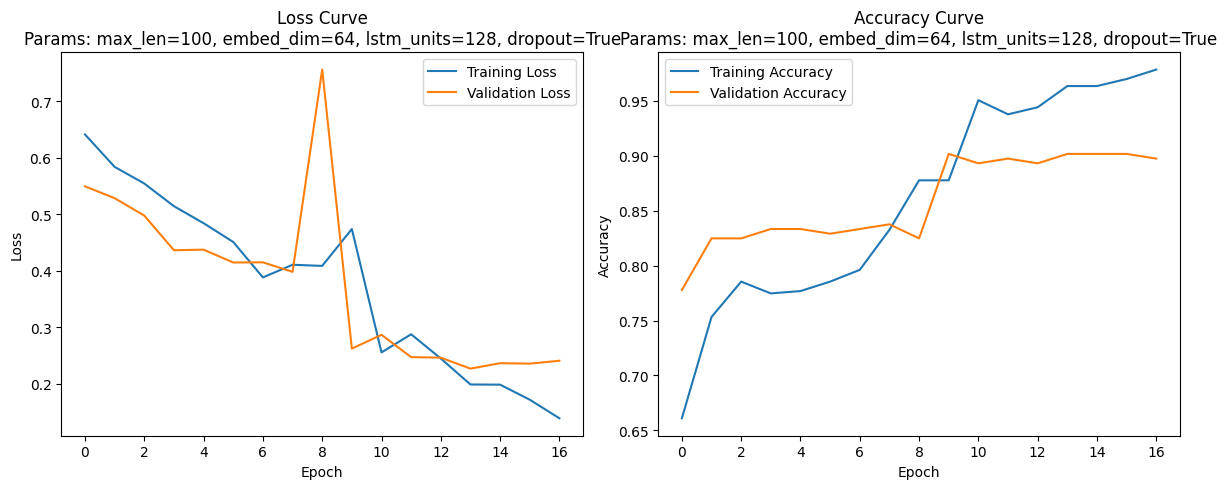


Training model with max_len=100, embedding_dim=128, lstm_units=32, use_dropout=False
Epoch 1: train_loss=0.6386, val_loss=0.5751, train_acc=0.6395, val_acc=0.7350
Epoch 2: train_loss=0.5873, val_loss=0.5467, train_acc=0.7275, val_acc=0.7735
Epoch 3: train_loss=0.5700, val_loss=0.5340, train_acc=0.7854, val_acc=0.8077
Epoch 4: train_loss=0.5540, val_loss=0.5228, train_acc=0.8090, val_acc=0.8077
Epoch 5: train_loss=0.5379, val_loss=0.5098, train_acc=0.8240, val_acc=0.8162
Epoch 6: train_loss=0.5190, val_loss=0.4969, train_acc=0.8240, val_acc=0.8205
Epoch 7: train_loss=0.4992, val_loss=0.4817, train_acc=0.8176, val_acc=0.8333
Epoch 8: train_loss=0.4761, val_loss=0.4641, train_acc=0.8240, val_acc=0.8333
Epoch 9: train_loss=0.4469, val_loss=0.4384, train_acc=0.8326, val_acc=0.8333
Epoch 10: train_loss=0.3973, val_loss=0.3643, train_acc=0.8519, val_acc=0.8590
Epoch 11: train_loss=0.3069, val_loss=0.3096, train_acc=0.8906, val_acc=0.8761
Epoch 12: train_loss=0.2463, val_loss=0.3270, train_ac

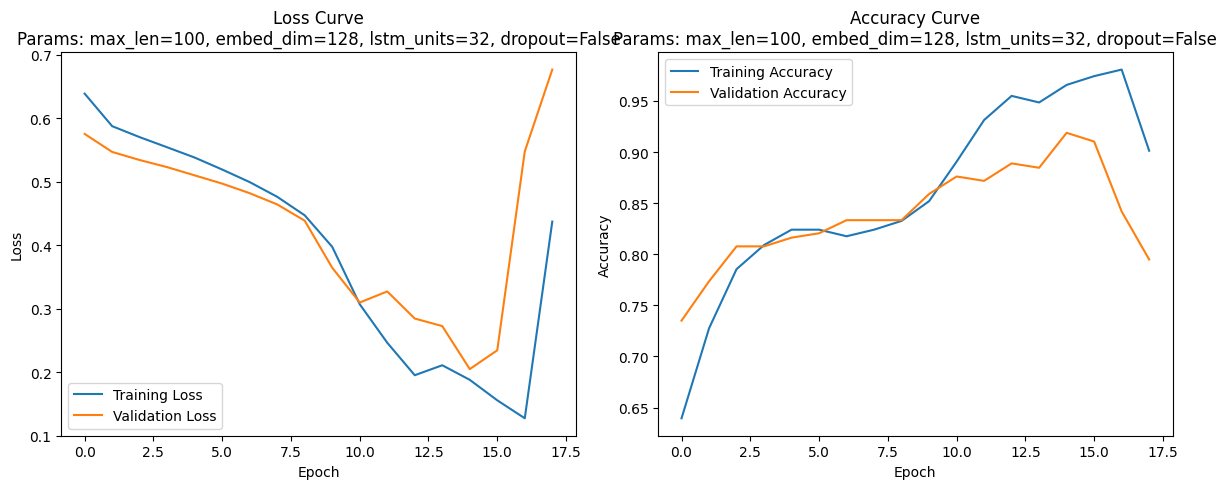


Training model with max_len=100, embedding_dim=128, lstm_units=32, use_dropout=True
Epoch 1: train_loss=0.6588, val_loss=0.5828, train_acc=0.5944, val_acc=0.7179
Epoch 2: train_loss=0.6026, val_loss=0.5576, train_acc=0.6953, val_acc=0.7350
Epoch 3: train_loss=0.5923, val_loss=0.5476, train_acc=0.7017, val_acc=0.7650
Epoch 4: train_loss=0.5777, val_loss=0.5396, train_acc=0.7618, val_acc=0.7991
Epoch 5: train_loss=0.5697, val_loss=0.5308, train_acc=0.7725, val_acc=0.7906
Epoch 6: train_loss=0.5416, val_loss=0.5227, train_acc=0.7983, val_acc=0.8034
Epoch 7: train_loss=0.5311, val_loss=0.5136, train_acc=0.8197, val_acc=0.8120
Epoch 8: train_loss=0.5132, val_loss=0.5033, train_acc=0.8155, val_acc=0.8205
Epoch 9: train_loss=0.5013, val_loss=0.4846, train_acc=0.8197, val_acc=0.8248
Epoch 10: train_loss=0.4755, val_loss=0.4595, train_acc=0.8240, val_acc=0.8248
Epoch 11: train_loss=0.4236, val_loss=0.4162, train_acc=0.8412, val_acc=0.8419
Epoch 12: train_loss=0.3762, val_loss=0.3914, train_acc

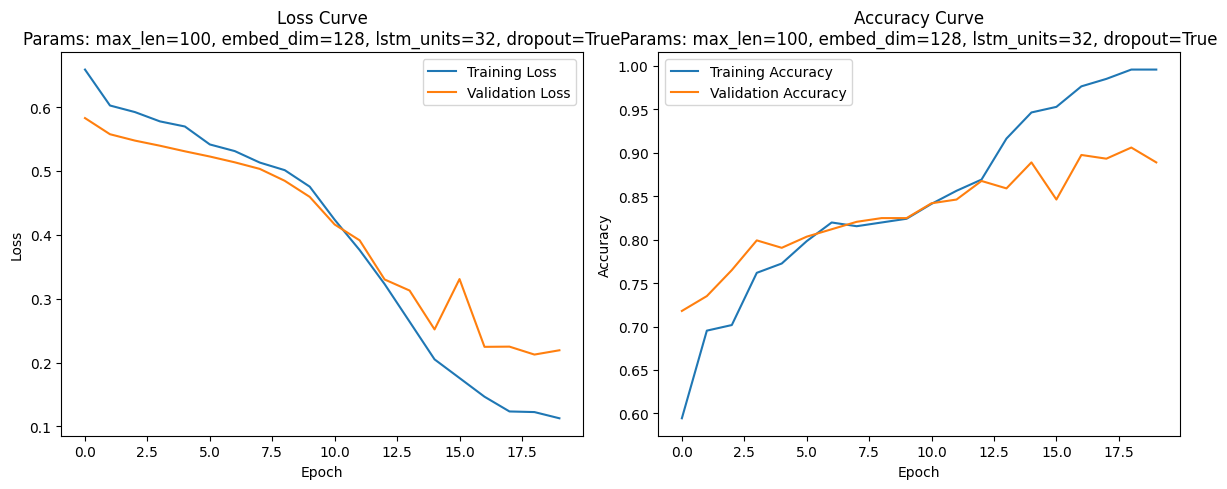


Training model with max_len=100, embedding_dim=128, lstm_units=64, use_dropout=False
Epoch 1: train_loss=0.6294, val_loss=0.5825, train_acc=0.5343, val_acc=0.5897
Epoch 2: train_loss=0.5982, val_loss=0.5677, train_acc=0.6545, val_acc=0.6752
Epoch 3: train_loss=0.5800, val_loss=0.5469, train_acc=0.7897, val_acc=0.7735
Epoch 4: train_loss=0.5515, val_loss=0.5228, train_acc=0.8498, val_acc=0.8205
Epoch 5: train_loss=0.5154, val_loss=0.4867, train_acc=0.8369, val_acc=0.8120
Epoch 6: train_loss=0.4645, val_loss=0.4294, train_acc=0.8197, val_acc=0.8291
Epoch 7: train_loss=0.4061, val_loss=0.3928, train_acc=0.8155, val_acc=0.8333
Epoch 8: train_loss=0.3470, val_loss=0.3522, train_acc=0.8648, val_acc=0.8376
Epoch 9: train_loss=0.3010, val_loss=0.3197, train_acc=0.9077, val_acc=0.8632
Epoch 10: train_loss=0.2182, val_loss=0.2795, train_acc=0.9592, val_acc=0.9145
Epoch 11: train_loss=0.2083, val_loss=0.4602, train_acc=0.9700, val_acc=0.8590
Epoch 12: train_loss=0.2610, val_loss=0.2030, train_ac

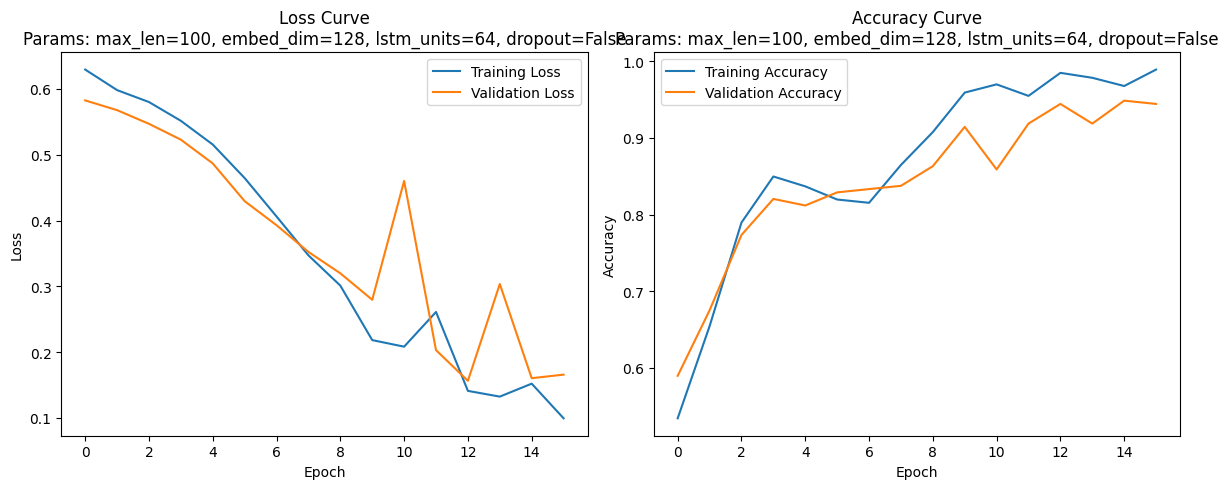


Training model with max_len=100, embedding_dim=128, lstm_units=64, use_dropout=True
Epoch 1: train_loss=0.6371, val_loss=0.5779, train_acc=0.6009, val_acc=0.6154
Epoch 2: train_loss=0.6056, val_loss=0.5590, train_acc=0.6674, val_acc=0.7436
Epoch 3: train_loss=0.5746, val_loss=0.5439, train_acc=0.7575, val_acc=0.7650
Epoch 4: train_loss=0.5542, val_loss=0.5255, train_acc=0.7854, val_acc=0.7991
Epoch 5: train_loss=0.5430, val_loss=0.5060, train_acc=0.7918, val_acc=0.8205
Epoch 6: train_loss=0.5017, val_loss=0.4660, train_acc=0.8112, val_acc=0.8248
Epoch 7: train_loss=0.4537, val_loss=0.4160, train_acc=0.7854, val_acc=0.8333
Epoch 8: train_loss=0.4072, val_loss=0.3929, train_acc=0.7897, val_acc=0.8291
Epoch 9: train_loss=0.3289, val_loss=0.2959, train_acc=0.8412, val_acc=0.8761
Epoch 10: train_loss=0.2722, val_loss=0.2949, train_acc=0.9034, val_acc=0.8632
Epoch 11: train_loss=0.1858, val_loss=0.2236, train_acc=0.9678, val_acc=0.8889
Epoch 12: train_loss=0.1523, val_loss=0.1811, train_acc

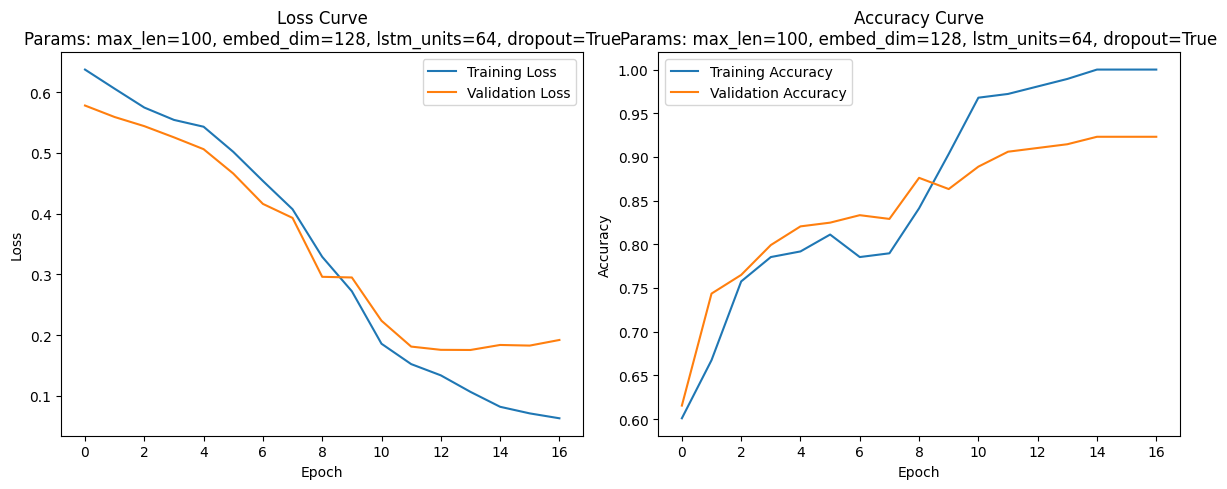


Training model with max_len=100, embedding_dim=128, lstm_units=128, use_dropout=False
Epoch 1: train_loss=0.6157, val_loss=0.5608, train_acc=0.6116, val_acc=0.7308
Epoch 2: train_loss=0.5805, val_loss=0.5314, train_acc=0.7854, val_acc=0.8120
Epoch 3: train_loss=0.5380, val_loss=0.4837, train_acc=0.8004, val_acc=0.8291
Epoch 4: train_loss=0.4659, val_loss=0.4133, train_acc=0.7833, val_acc=0.8291
Epoch 5: train_loss=0.4083, val_loss=0.3966, train_acc=0.8069, val_acc=0.8462
Epoch 6: train_loss=0.3378, val_loss=0.3731, train_acc=0.8498, val_acc=0.8376
Epoch 7: train_loss=0.2795, val_loss=0.3789, train_acc=0.9056, val_acc=0.8718
Epoch 8: train_loss=0.2386, val_loss=0.2655, train_acc=0.9335, val_acc=0.8846
Epoch 9: train_loss=0.1822, val_loss=0.2703, train_acc=0.9592, val_acc=0.8974
Epoch 10: train_loss=0.1774, val_loss=0.2557, train_acc=0.9635, val_acc=0.8932
Epoch 11: train_loss=0.1601, val_loss=0.2302, train_acc=0.9614, val_acc=0.9017
Epoch 12: train_loss=0.1046, val_loss=0.2474, train_a

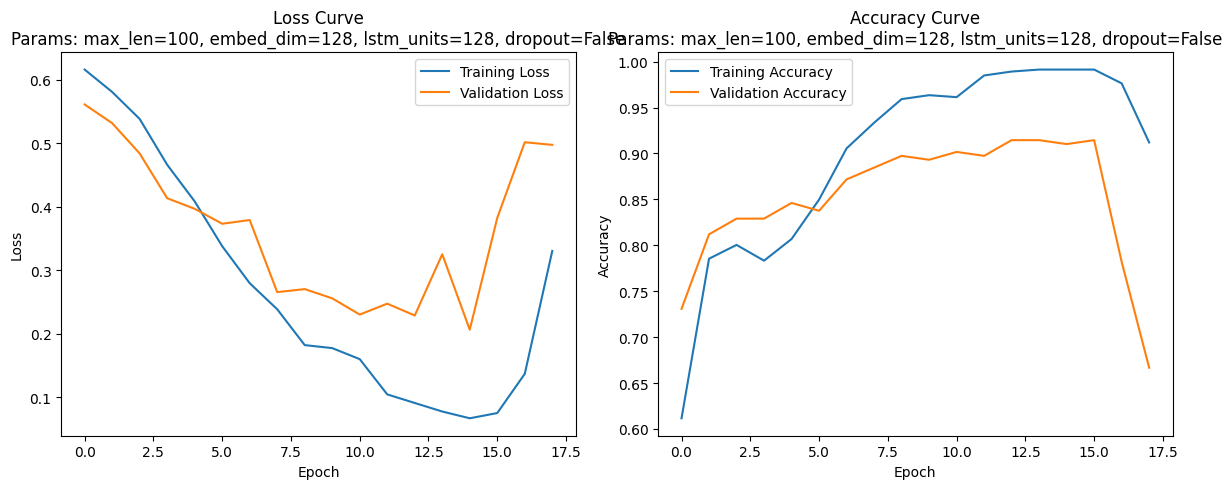


Training model with max_len=100, embedding_dim=128, lstm_units=128, use_dropout=True
Epoch 1: train_loss=0.6293, val_loss=0.5573, train_acc=0.5815, val_acc=0.7436
Epoch 2: train_loss=0.5867, val_loss=0.5332, train_acc=0.7275, val_acc=0.8077
Epoch 3: train_loss=0.5522, val_loss=0.5034, train_acc=0.7897, val_acc=0.8376
Epoch 4: train_loss=0.4943, val_loss=0.4177, train_acc=0.7940, val_acc=0.8291
Epoch 5: train_loss=0.4317, val_loss=0.4177, train_acc=0.7833, val_acc=0.8419
Epoch 6: train_loss=0.3910, val_loss=0.3926, train_acc=0.8348, val_acc=0.8590
Epoch 7: train_loss=0.3685, val_loss=0.4223, train_acc=0.8648, val_acc=0.8462
Epoch 8: train_loss=0.3762, val_loss=0.3977, train_acc=0.8906, val_acc=0.8462
Epoch 9: train_loss=0.3049, val_loss=0.3657, train_acc=0.9077, val_acc=0.8632
Epoch 10: train_loss=0.2213, val_loss=0.3495, train_acc=0.9356, val_acc=0.8761
Epoch 11: train_loss=0.2840, val_loss=0.3314, train_acc=0.9227, val_acc=0.8632
Epoch 12: train_loss=0.2143, val_loss=0.2795, train_ac

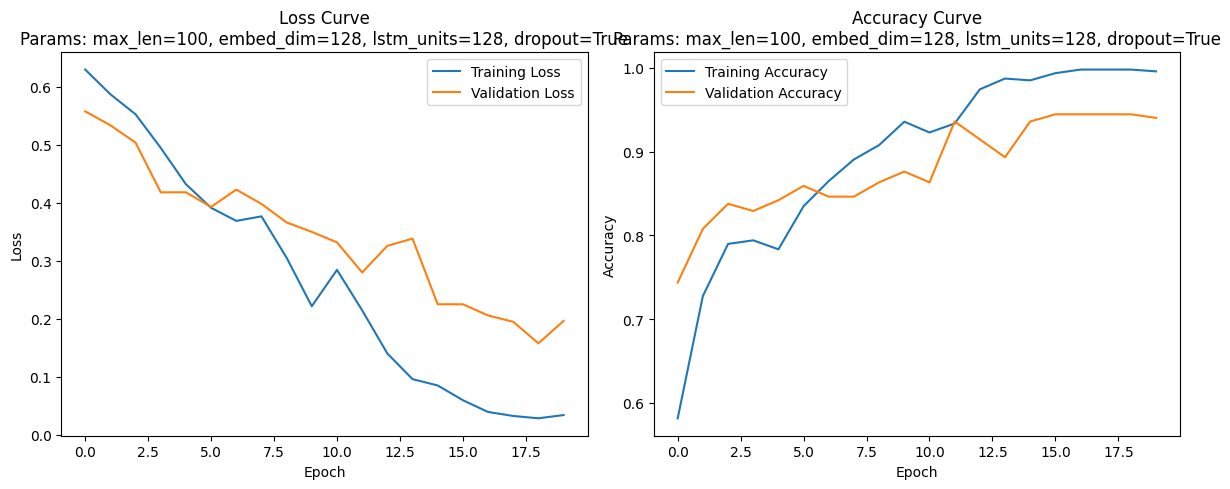


Training model with max_len=100, embedding_dim=256, lstm_units=32, use_dropout=False
Epoch 1: train_loss=0.6520, val_loss=0.5615, train_acc=0.6524, val_acc=0.8120
Epoch 2: train_loss=0.5703, val_loss=0.5336, train_acc=0.7854, val_acc=0.8077
Epoch 3: train_loss=0.5437, val_loss=0.5206, train_acc=0.8219, val_acc=0.8120
Epoch 4: train_loss=0.5245, val_loss=0.5102, train_acc=0.8519, val_acc=0.8291
Epoch 5: train_loss=0.5048, val_loss=0.5019, train_acc=0.8648, val_acc=0.8248
Epoch 6: train_loss=0.4836, val_loss=0.4929, train_acc=0.8820, val_acc=0.8248
Epoch 7: train_loss=0.4611, val_loss=0.4800, train_acc=0.8906, val_acc=0.8333
Epoch 8: train_loss=0.4319, val_loss=0.4657, train_acc=0.8991, val_acc=0.8291
Epoch 9: train_loss=0.4032, val_loss=0.4471, train_acc=0.9034, val_acc=0.8291
Epoch 10: train_loss=0.3693, val_loss=0.4268, train_acc=0.9142, val_acc=0.8376
Epoch 11: train_loss=0.3372, val_loss=0.4071, train_acc=0.9142, val_acc=0.8419
Epoch 12: train_loss=0.2967, val_loss=0.3798, train_ac

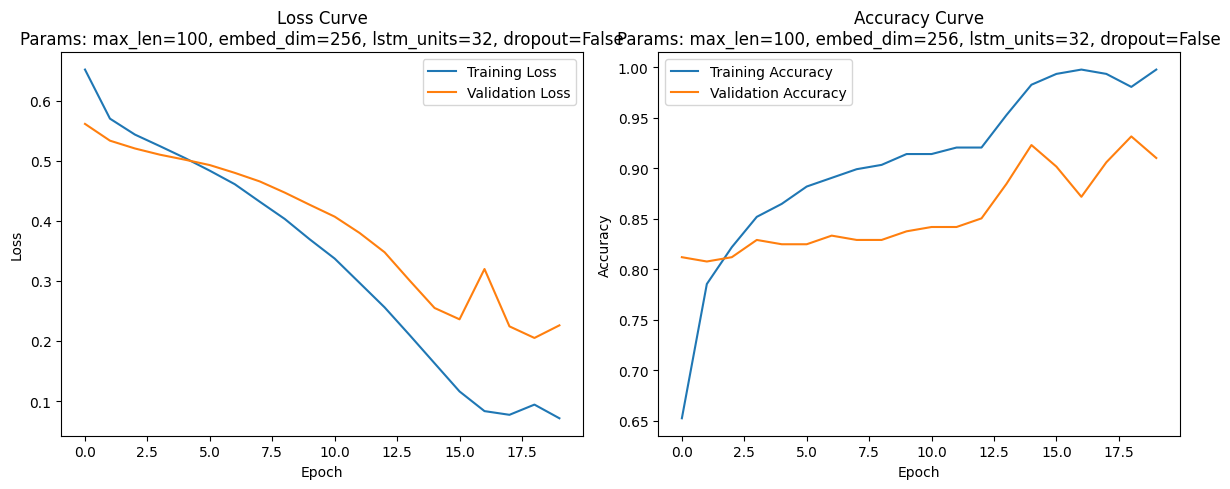


Training model with max_len=100, embedding_dim=256, lstm_units=32, use_dropout=True
Epoch 1: train_loss=0.6656, val_loss=0.6017, train_acc=0.5644, val_acc=0.6026
Epoch 2: train_loss=0.6176, val_loss=0.5783, train_acc=0.6073, val_acc=0.6752
Epoch 3: train_loss=0.5926, val_loss=0.5674, train_acc=0.6910, val_acc=0.6966
Epoch 4: train_loss=0.5737, val_loss=0.5523, train_acc=0.7167, val_acc=0.7308
Epoch 5: train_loss=0.5537, val_loss=0.5368, train_acc=0.7876, val_acc=0.7479
Epoch 6: train_loss=0.5391, val_loss=0.5236, train_acc=0.8133, val_acc=0.7521
Epoch 7: train_loss=0.5140, val_loss=0.5118, train_acc=0.8476, val_acc=0.7564
Epoch 8: train_loss=0.4781, val_loss=0.4966, train_acc=0.8670, val_acc=0.7692
Epoch 9: train_loss=0.4519, val_loss=0.4820, train_acc=0.8884, val_acc=0.7821
Epoch 10: train_loss=0.4222, val_loss=0.4658, train_acc=0.8970, val_acc=0.7949
Epoch 11: train_loss=0.4021, val_loss=0.4452, train_acc=0.8927, val_acc=0.8077
Epoch 12: train_loss=0.3512, val_loss=0.4116, train_acc

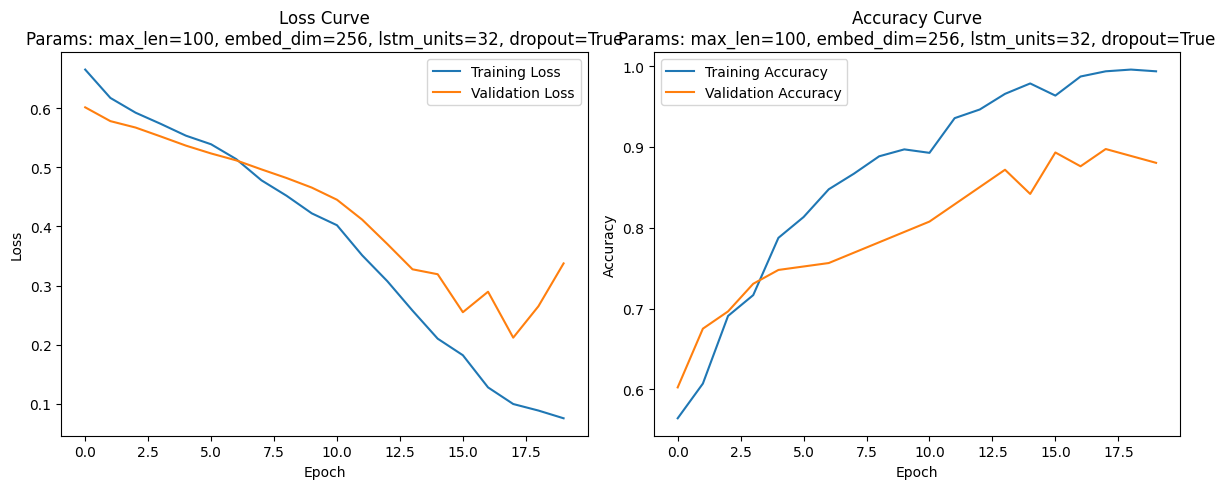


Training model with max_len=100, embedding_dim=256, lstm_units=64, use_dropout=False
Epoch 1: train_loss=0.6082, val_loss=0.5414, train_acc=0.7232, val_acc=0.7991
Epoch 2: train_loss=0.5552, val_loss=0.5245, train_acc=0.8026, val_acc=0.8034
Epoch 3: train_loss=0.5277, val_loss=0.5074, train_acc=0.8262, val_acc=0.8162
Epoch 4: train_loss=0.4958, val_loss=0.4911, train_acc=0.8433, val_acc=0.8376
Epoch 5: train_loss=0.4619, val_loss=0.4680, train_acc=0.8670, val_acc=0.8376
Epoch 6: train_loss=0.4183, val_loss=0.4332, train_acc=0.8777, val_acc=0.8376
Epoch 7: train_loss=0.3599, val_loss=0.3764, train_acc=0.8884, val_acc=0.8376
Epoch 8: train_loss=0.2888, val_loss=0.3047, train_acc=0.8948, val_acc=0.8547
Epoch 9: train_loss=0.1943, val_loss=0.2303, train_acc=0.9549, val_acc=0.8974
Epoch 10: train_loss=0.1203, val_loss=0.1834, train_acc=0.9979, val_acc=0.9188
Epoch 11: train_loss=0.0832, val_loss=0.1905, train_acc=0.9957, val_acc=0.8932
Epoch 12: train_loss=0.0734, val_loss=0.2467, train_ac

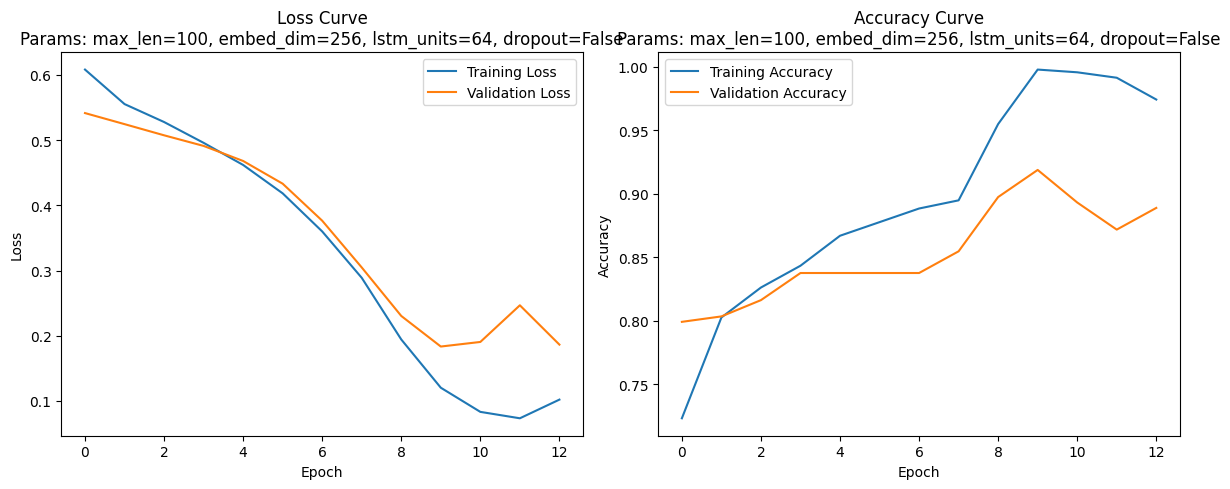


Training model with max_len=100, embedding_dim=256, lstm_units=64, use_dropout=True
Epoch 1: train_loss=0.6325, val_loss=0.5464, train_acc=0.6395, val_acc=0.7564
Epoch 2: train_loss=0.5762, val_loss=0.5341, train_acc=0.7382, val_acc=0.7735
Epoch 3: train_loss=0.5516, val_loss=0.5215, train_acc=0.7961, val_acc=0.8034
Epoch 4: train_loss=0.5287, val_loss=0.5080, train_acc=0.8262, val_acc=0.8077
Epoch 5: train_loss=0.5136, val_loss=0.4942, train_acc=0.8519, val_acc=0.8205
Epoch 6: train_loss=0.4738, val_loss=0.4764, train_acc=0.8648, val_acc=0.8248
Epoch 7: train_loss=0.4422, val_loss=0.4514, train_acc=0.8863, val_acc=0.8333
Epoch 8: train_loss=0.3888, val_loss=0.4087, train_acc=0.8906, val_acc=0.8419
Epoch 9: train_loss=0.3220, val_loss=0.3463, train_acc=0.8927, val_acc=0.8376
Epoch 10: train_loss=0.2550, val_loss=0.2770, train_acc=0.9270, val_acc=0.8846
Epoch 11: train_loss=0.1704, val_loss=0.2160, train_acc=0.9871, val_acc=0.8974
Epoch 12: train_loss=0.1345, val_loss=0.1863, train_acc

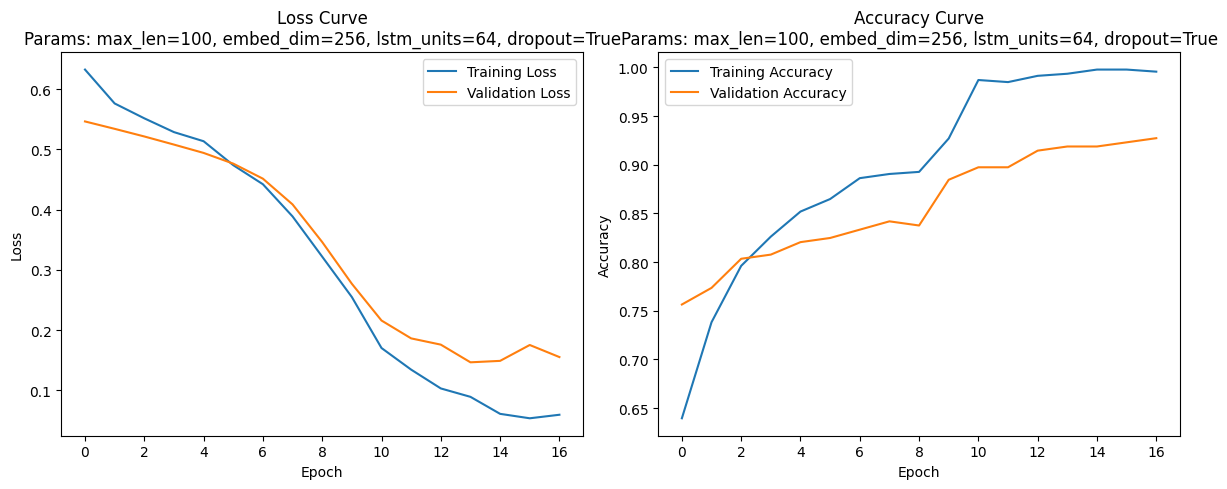


Training model with max_len=100, embedding_dim=256, lstm_units=128, use_dropout=False
Epoch 1: train_loss=0.6023, val_loss=0.5376, train_acc=0.6910, val_acc=0.7991
Epoch 2: train_loss=0.5508, val_loss=0.5067, train_acc=0.8069, val_acc=0.8205
Epoch 3: train_loss=0.5042, val_loss=0.4711, train_acc=0.8219, val_acc=0.8291
Epoch 4: train_loss=0.4295, val_loss=0.3910, train_acc=0.8197, val_acc=0.8291
Epoch 5: train_loss=0.3480, val_loss=0.3547, train_acc=0.8476, val_acc=0.8333
Epoch 6: train_loss=0.2773, val_loss=0.3164, train_acc=0.9120, val_acc=0.8333
Epoch 7: train_loss=0.2598, val_loss=0.3054, train_acc=0.9206, val_acc=0.8718
Epoch 8: train_loss=0.1740, val_loss=0.3080, train_acc=0.9721, val_acc=0.8846
Epoch 9: train_loss=0.0959, val_loss=0.2036, train_acc=0.9850, val_acc=0.9316
Epoch 10: train_loss=0.0807, val_loss=0.1670, train_acc=0.9893, val_acc=0.9316
Epoch 11: train_loss=0.0446, val_loss=0.1499, train_acc=0.9979, val_acc=0.9359
Epoch 12: train_loss=0.0395, val_loss=0.1713, train_a

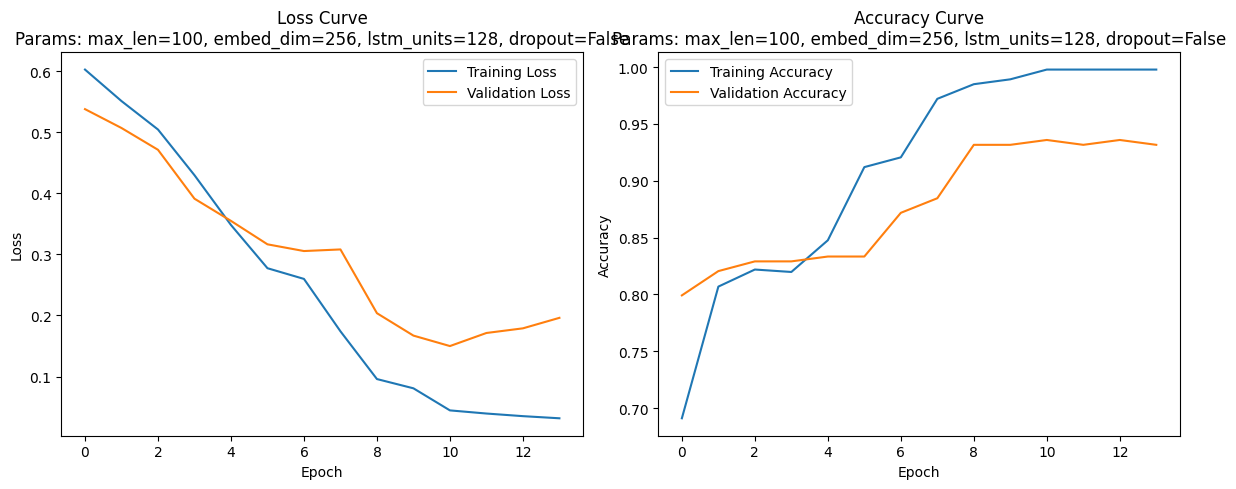


Training model with max_len=100, embedding_dim=256, lstm_units=128, use_dropout=True
Epoch 1: train_loss=0.6351, val_loss=0.5612, train_acc=0.5880, val_acc=0.6838
Epoch 2: train_loss=0.5750, val_loss=0.5384, train_acc=0.7575, val_acc=0.7735
Epoch 3: train_loss=0.5333, val_loss=0.5073, train_acc=0.8348, val_acc=0.7991
Epoch 4: train_loss=0.4743, val_loss=0.4255, train_acc=0.8519, val_acc=0.8333
Epoch 5: train_loss=0.4004, val_loss=0.4009, train_acc=0.8240, val_acc=0.8376
Epoch 6: train_loss=0.3430, val_loss=0.3800, train_acc=0.8927, val_acc=0.8547
Epoch 7: train_loss=0.2783, val_loss=0.3334, train_acc=0.9120, val_acc=0.8504
Epoch 8: train_loss=0.1968, val_loss=0.4063, train_acc=0.9442, val_acc=0.8462
Epoch 9: train_loss=0.1602, val_loss=0.1685, train_acc=0.9764, val_acc=0.9359
Epoch 10: train_loss=0.1096, val_loss=0.2133, train_acc=0.9850, val_acc=0.9060
Epoch 11: train_loss=0.0927, val_loss=0.2075, train_acc=0.9914, val_acc=0.9017
Epoch 12: train_loss=0.1016, val_loss=0.2606, train_ac

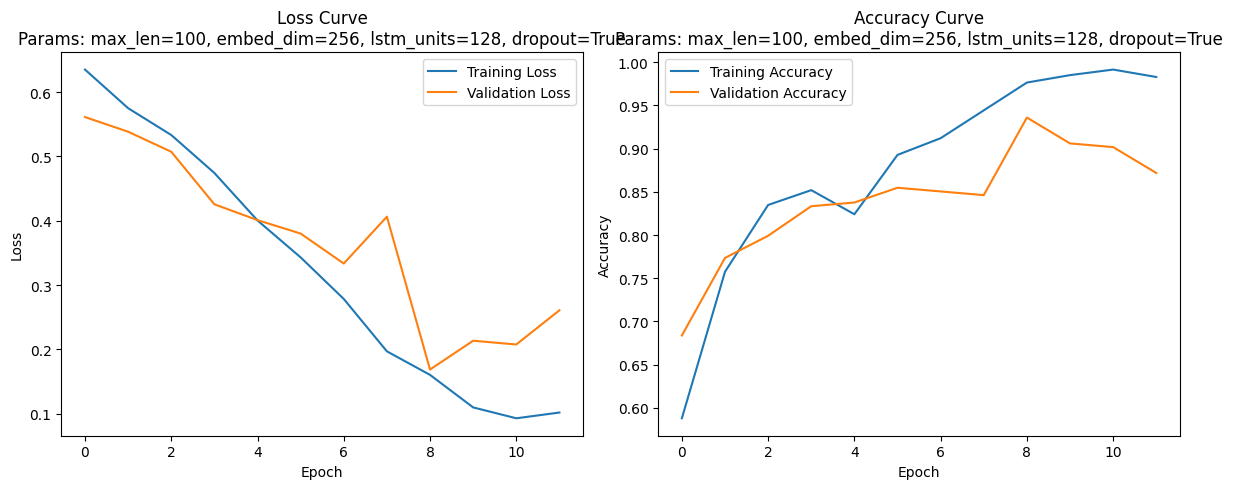


Training model with max_len=150, embedding_dim=64, lstm_units=32, use_dropout=False
Epoch 1: train_loss=0.6959, val_loss=0.6932, train_acc=0.4657, val_acc=0.5000
Epoch 2: train_loss=0.6938, val_loss=0.6931, train_acc=0.4785, val_acc=0.5000
Epoch 3: train_loss=0.6933, val_loss=0.6938, train_acc=0.4914, val_acc=0.5000
Epoch 4: train_loss=0.6941, val_loss=0.6934, train_acc=0.5000, val_acc=0.5000
Epoch 5: train_loss=0.6931, val_loss=0.6932, train_acc=0.5000, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1-score: 0.6667


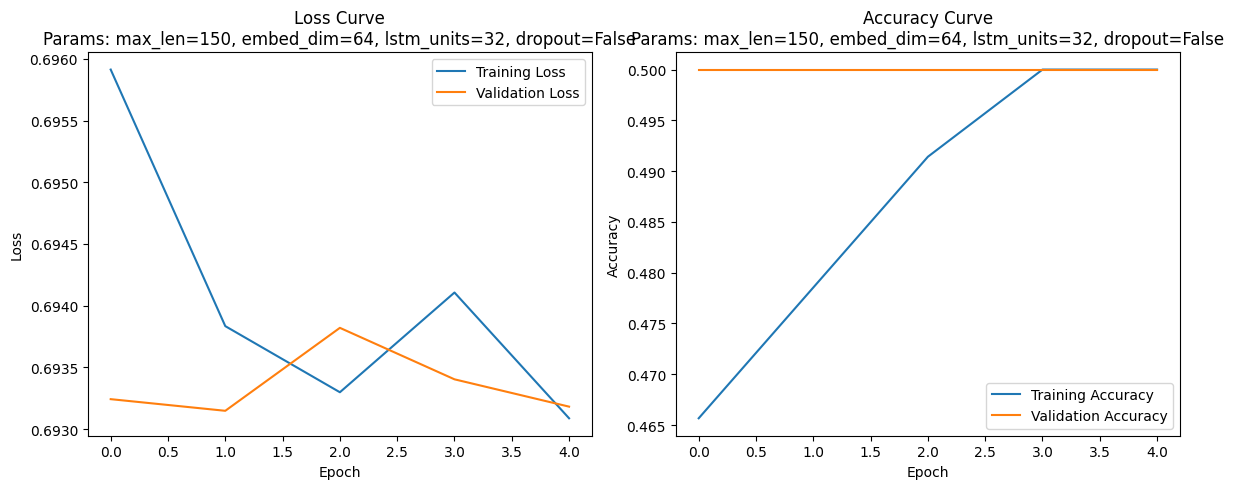


Training model with max_len=150, embedding_dim=64, lstm_units=32, use_dropout=True
Epoch 1: train_loss=0.7002, val_loss=0.6932, train_acc=0.4957, val_acc=0.5000
Epoch 2: train_loss=0.6958, val_loss=0.6940, train_acc=0.4957, val_acc=0.5000
Epoch 3: train_loss=0.6907, val_loss=0.6932, train_acc=0.5386, val_acc=0.5000
Epoch 4: train_loss=0.6980, val_loss=0.6932, train_acc=0.4850, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


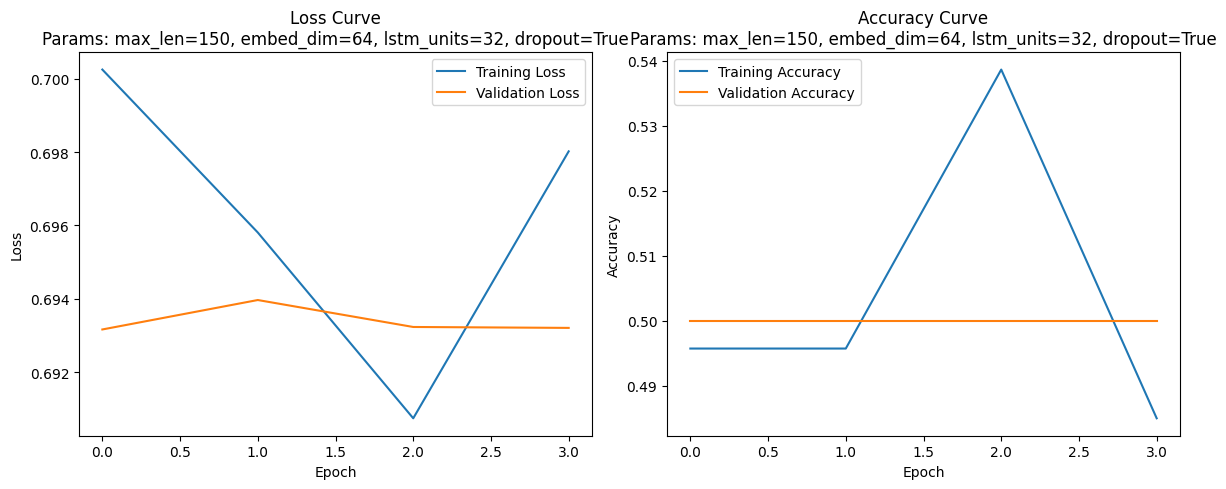


Training model with max_len=150, embedding_dim=64, lstm_units=64, use_dropout=False
Epoch 1: train_loss=0.6969, val_loss=0.6967, train_acc=0.5129, val_acc=0.5000
Epoch 2: train_loss=0.6948, val_loss=0.6932, train_acc=0.5000, val_acc=0.5000
Epoch 3: train_loss=0.6954, val_loss=0.6946, train_acc=0.5000, val_acc=0.5000
Epoch 4: train_loss=0.6932, val_loss=0.6940, train_acc=0.5086, val_acc=0.5000
Epoch 5: train_loss=0.6945, val_loss=0.6937, train_acc=0.5000, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1-score: 0.6667


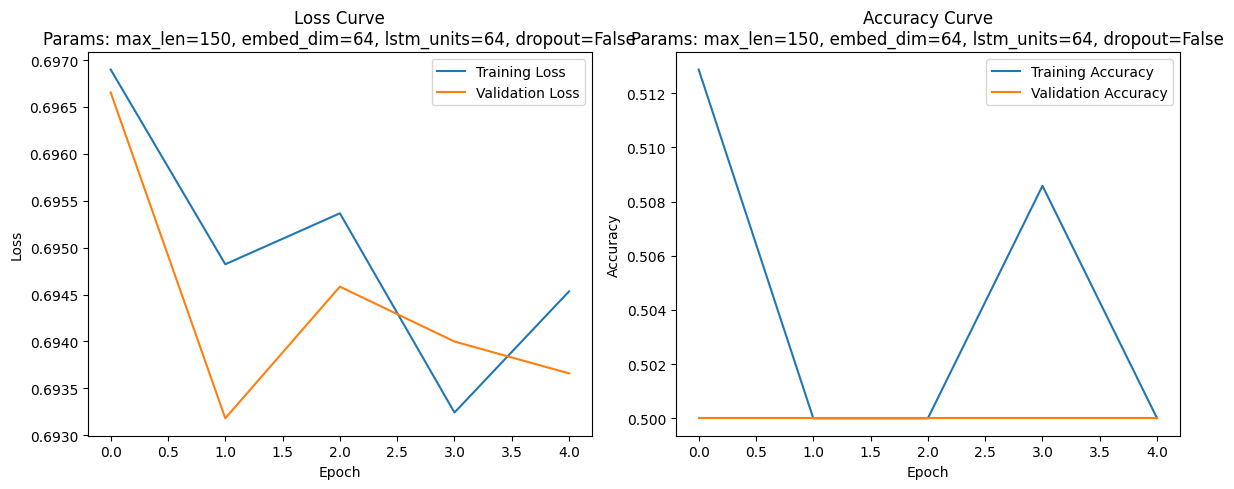


Training model with max_len=150, embedding_dim=64, lstm_units=64, use_dropout=True
Epoch 1: train_loss=0.7052, val_loss=0.6933, train_acc=0.4807, val_acc=0.5000
Epoch 2: train_loss=0.7004, val_loss=0.6942, train_acc=0.4678, val_acc=0.5000
Epoch 3: train_loss=0.6876, val_loss=0.6931, train_acc=0.5536, val_acc=0.5000
Epoch 4: train_loss=0.6900, val_loss=0.6948, train_acc=0.5451, val_acc=0.5000
Epoch 5: train_loss=0.6923, val_loss=0.6940, train_acc=0.5322, val_acc=0.5000
Epoch 6: train_loss=0.6975, val_loss=0.6932, train_acc=0.4742, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1-score: 0.6667


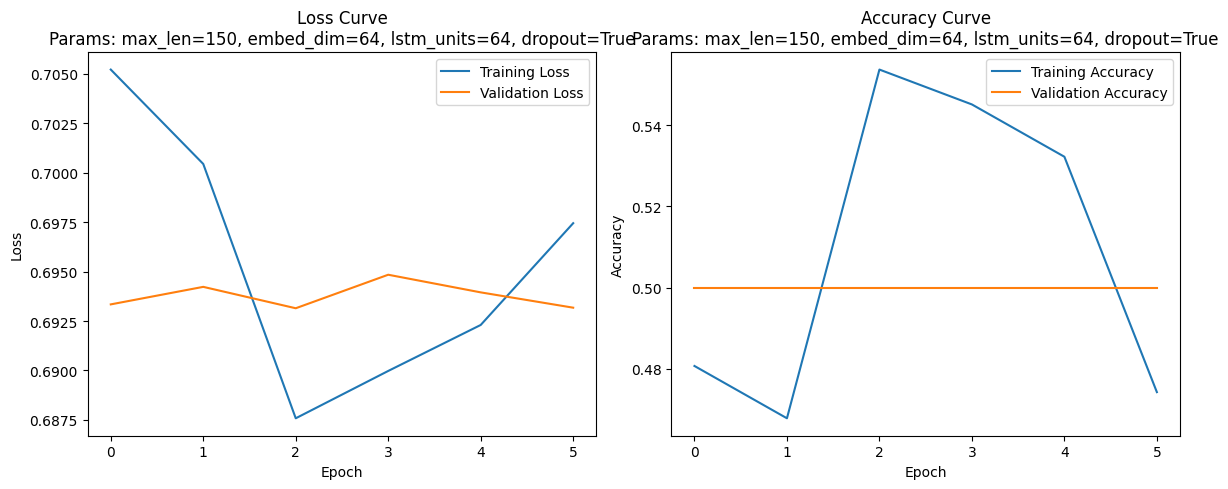


Training model with max_len=150, embedding_dim=64, lstm_units=128, use_dropout=False
Epoch 1: train_loss=0.6956, val_loss=0.6933, train_acc=0.4914, val_acc=0.5000
Epoch 2: train_loss=0.6946, val_loss=0.6931, train_acc=0.4571, val_acc=0.5000
Epoch 3: train_loss=0.6940, val_loss=0.6934, train_acc=0.5000, val_acc=0.5000
Epoch 4: train_loss=0.6946, val_loss=0.6937, train_acc=0.5000, val_acc=0.5000
Epoch 5: train_loss=0.6943, val_loss=0.6937, train_acc=0.4871, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1-score: 0.6667


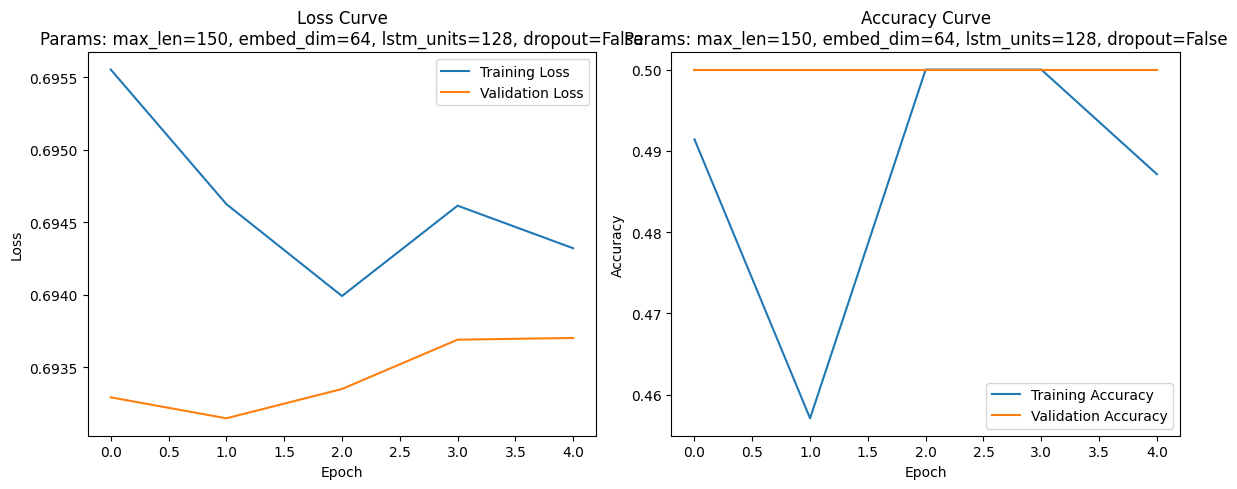


Training model with max_len=150, embedding_dim=64, lstm_units=128, use_dropout=True
Epoch 1: train_loss=0.7091, val_loss=0.6940, train_acc=0.4828, val_acc=0.5000
Epoch 2: train_loss=0.7053, val_loss=0.6966, train_acc=0.4871, val_acc=0.5000
Epoch 3: train_loss=0.6921, val_loss=0.6942, train_acc=0.5215, val_acc=0.5000
Epoch 4: train_loss=0.6943, val_loss=0.6934, train_acc=0.4957, val_acc=0.5000
Epoch 5: train_loss=0.6901, val_loss=0.6934, train_acc=0.5386, val_acc=0.5000
Epoch 6: train_loss=0.6896, val_loss=0.6931, train_acc=0.5150, val_acc=0.5000
Epoch 7: train_loss=0.6990, val_loss=0.6942, train_acc=0.4807, val_acc=0.5000
Epoch 8: train_loss=0.7024, val_loss=0.6939, train_acc=0.4721, val_acc=0.5000
Epoch 9: train_loss=0.6933, val_loss=0.6935, train_acc=0.5172, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


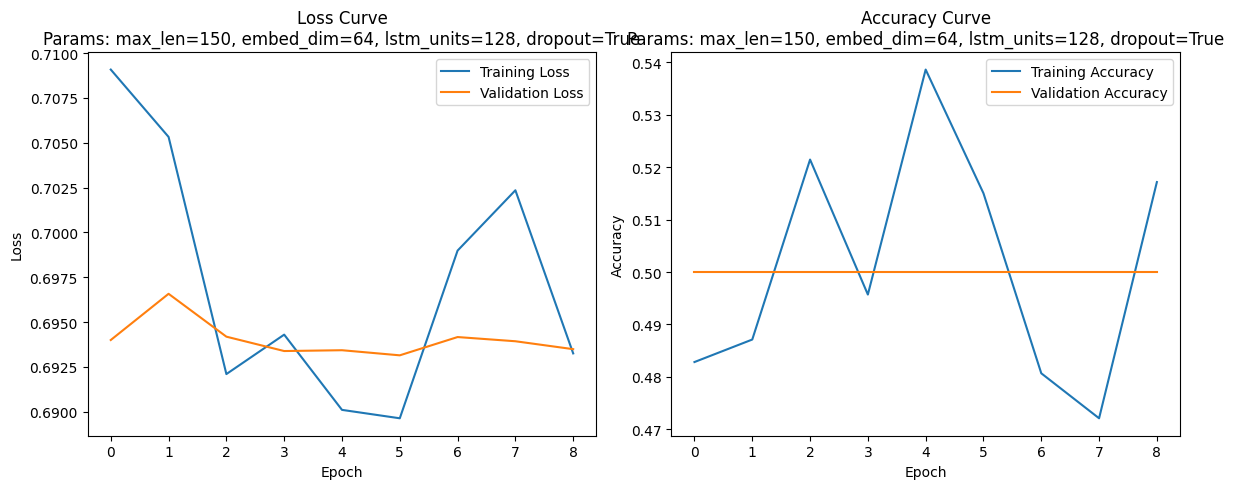


Training model with max_len=150, embedding_dim=128, lstm_units=32, use_dropout=False
Epoch 1: train_loss=0.6970, val_loss=0.6959, train_acc=0.4957, val_acc=0.5000
Epoch 2: train_loss=0.6934, val_loss=0.6937, train_acc=0.4957, val_acc=0.5000
Epoch 3: train_loss=0.6944, val_loss=0.6940, train_acc=0.5000, val_acc=0.5000
Epoch 4: train_loss=0.6942, val_loss=0.6932, train_acc=0.5000, val_acc=0.5000
Epoch 5: train_loss=0.6947, val_loss=0.6934, train_acc=0.4785, val_acc=0.5000
Epoch 6: train_loss=0.6929, val_loss=0.6933, train_acc=0.5086, val_acc=0.5000
Epoch 7: train_loss=0.6934, val_loss=0.6932, train_acc=0.5000, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


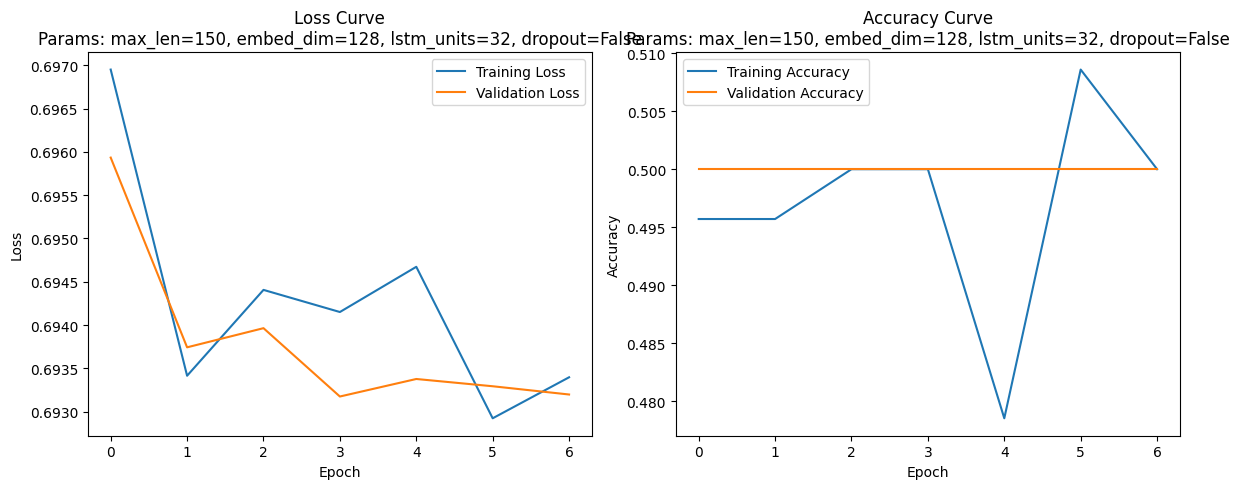


Training model with max_len=150, embedding_dim=128, lstm_units=32, use_dropout=True
Epoch 1: train_loss=0.6948, val_loss=0.6933, train_acc=0.5107, val_acc=0.5000
Epoch 2: train_loss=0.7012, val_loss=0.6939, train_acc=0.5107, val_acc=0.5000
Epoch 3: train_loss=0.7025, val_loss=0.6931, train_acc=0.4764, val_acc=0.5000
Epoch 4: train_loss=0.7014, val_loss=0.6934, train_acc=0.4828, val_acc=0.5000
Epoch 5: train_loss=0.7001, val_loss=0.6932, train_acc=0.4785, val_acc=0.5000
Epoch 6: train_loss=0.6924, val_loss=0.6935, train_acc=0.5107, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


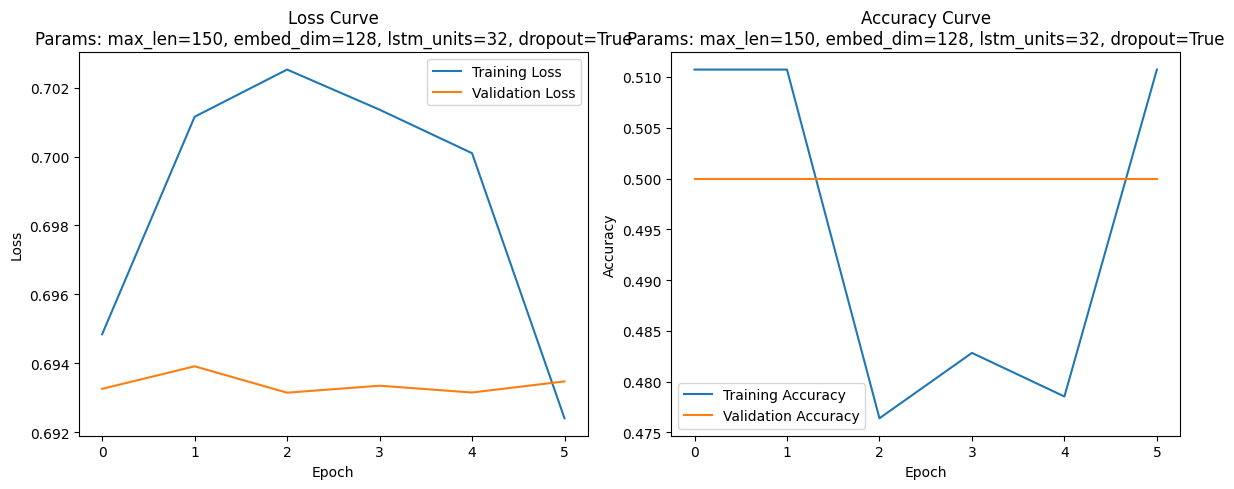


Training model with max_len=150, embedding_dim=128, lstm_units=64, use_dropout=False
Epoch 1: train_loss=0.6999, val_loss=0.6954, train_acc=0.4785, val_acc=0.5000
Epoch 2: train_loss=0.6963, val_loss=0.6942, train_acc=0.4828, val_acc=0.5000
Epoch 3: train_loss=0.6940, val_loss=0.6932, train_acc=0.5000, val_acc=0.5000
Epoch 4: train_loss=0.6939, val_loss=0.6932, train_acc=0.5000, val_acc=0.5000
Epoch 5: train_loss=0.6957, val_loss=0.6938, train_acc=0.4700, val_acc=0.5000
Epoch 6: train_loss=0.6942, val_loss=0.6932, train_acc=0.5000, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


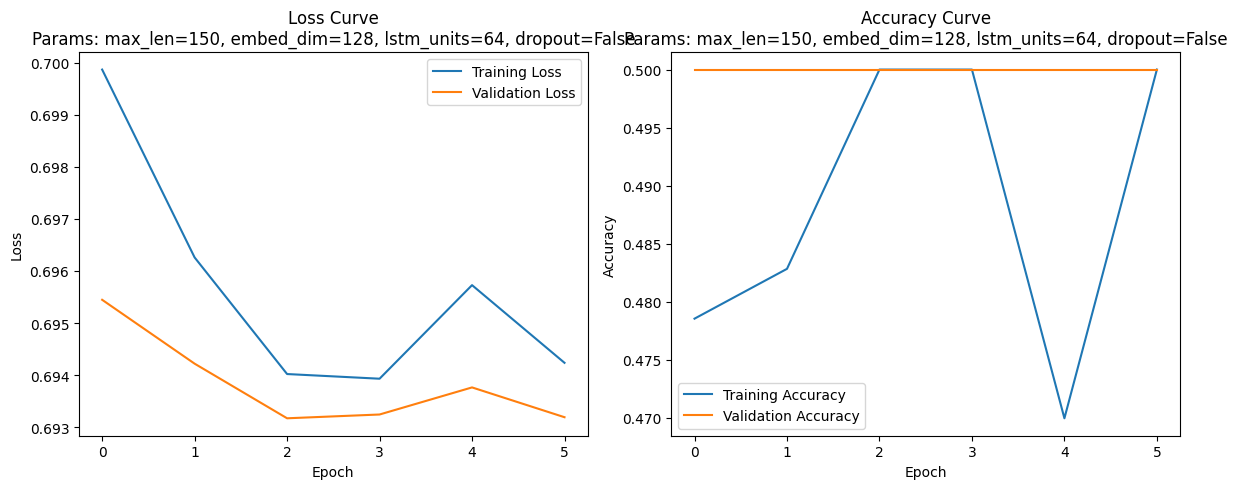


Training model with max_len=150, embedding_dim=128, lstm_units=64, use_dropout=True
Epoch 1: train_loss=0.6976, val_loss=0.6934, train_acc=0.5021, val_acc=0.5000
Epoch 2: train_loss=0.7060, val_loss=0.6941, train_acc=0.4700, val_acc=0.5000
Epoch 3: train_loss=0.6991, val_loss=0.6939, train_acc=0.4828, val_acc=0.5000
Epoch 4: train_loss=0.6986, val_loss=0.6932, train_acc=0.4657, val_acc=0.5000
Epoch 5: train_loss=0.6991, val_loss=0.6947, train_acc=0.5086, val_acc=0.5000
Epoch 6: train_loss=0.6954, val_loss=0.6932, train_acc=0.5107, val_acc=0.5000
Epoch 7: train_loss=0.6955, val_loss=0.6940, train_acc=0.5193, val_acc=0.5000
Epoch 8: train_loss=0.6982, val_loss=0.6933, train_acc=0.4742, val_acc=0.5000
Epoch 9: train_loss=0.7012, val_loss=0.6931, train_acc=0.4313, val_acc=0.5000
Epoch 10: train_loss=0.6972, val_loss=0.6940, train_acc=0.4742, val_acc=0.5000
Epoch 11: train_loss=0.6950, val_loss=0.6934, train_acc=0.4979, val_acc=0.5000
Epoch 12: train_loss=0.6944, val_loss=0.6931, train_acc

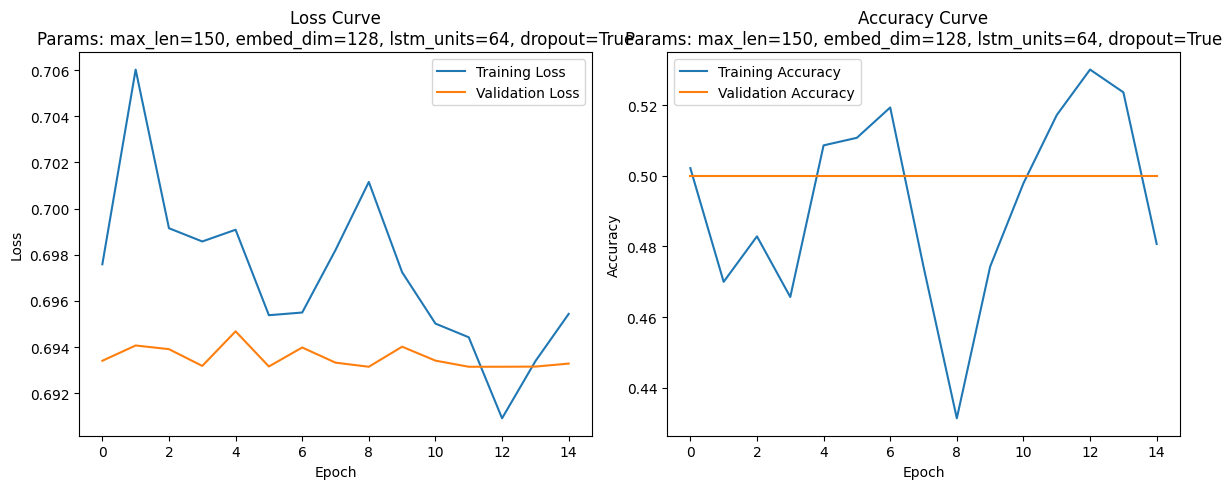


Training model with max_len=150, embedding_dim=128, lstm_units=128, use_dropout=False
Epoch 1: train_loss=0.7025, val_loss=0.6952, train_acc=0.4957, val_acc=0.5000
Epoch 2: train_loss=0.6977, val_loss=0.6932, train_acc=0.4528, val_acc=0.5000
Epoch 3: train_loss=0.6936, val_loss=0.6933, train_acc=0.5000, val_acc=0.5000
Epoch 4: train_loss=0.6944, val_loss=0.6935, train_acc=0.5043, val_acc=0.5000
Epoch 5: train_loss=0.6947, val_loss=0.6944, train_acc=0.4914, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


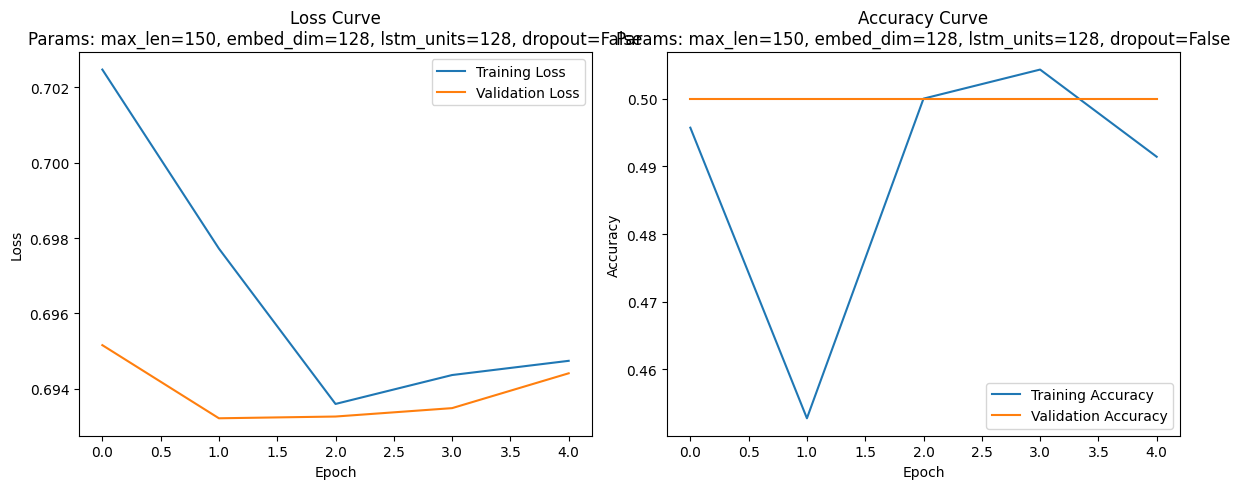


Training model with max_len=150, embedding_dim=128, lstm_units=128, use_dropout=True
Epoch 1: train_loss=0.7050, val_loss=0.6932, train_acc=0.4850, val_acc=0.5000
Epoch 2: train_loss=0.7014, val_loss=0.6943, train_acc=0.4678, val_acc=0.5000
Epoch 3: train_loss=0.6985, val_loss=0.6965, train_acc=0.4893, val_acc=0.5000
Epoch 4: train_loss=0.6964, val_loss=0.6934, train_acc=0.4979, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


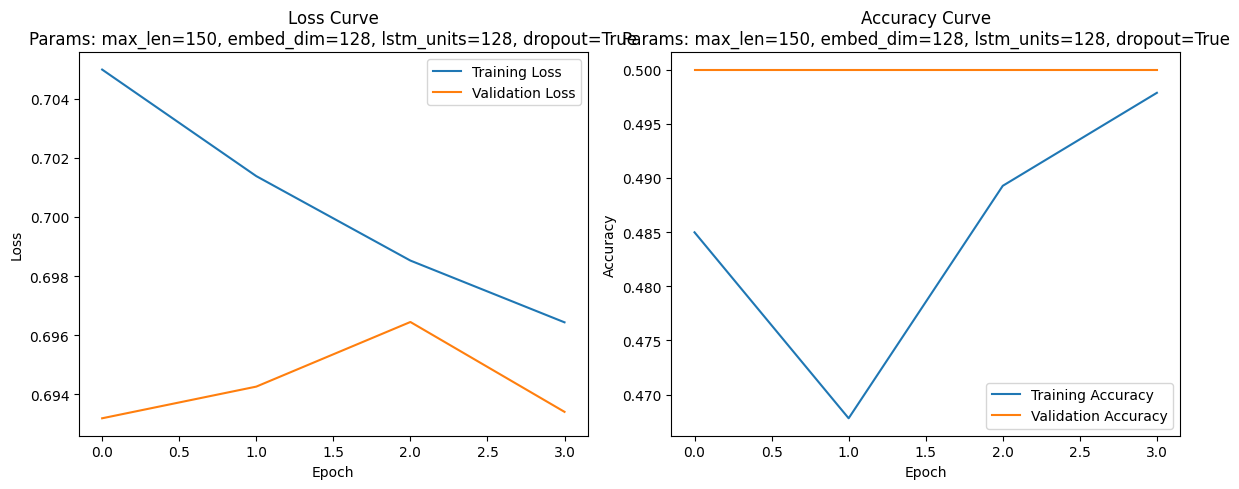


Training model with max_len=150, embedding_dim=256, lstm_units=32, use_dropout=False
Epoch 1: train_loss=0.6992, val_loss=0.6962, train_acc=0.5129, val_acc=0.5000
Epoch 2: train_loss=0.6973, val_loss=0.6941, train_acc=0.5000, val_acc=0.5000
Epoch 3: train_loss=0.6944, val_loss=0.6936, train_acc=0.4657, val_acc=0.5000
Epoch 4: train_loss=0.6942, val_loss=0.6940, train_acc=0.5000, val_acc=0.5000
Epoch 5: train_loss=0.6932, val_loss=0.6931, train_acc=0.5000, val_acc=0.5000
Epoch 6: train_loss=0.6932, val_loss=0.6932, train_acc=0.4742, val_acc=0.5000
Epoch 7: train_loss=0.6933, val_loss=0.6932, train_acc=0.5000, val_acc=0.5000
Epoch 8: train_loss=0.6935, val_loss=0.6934, train_acc=0.5000, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1-score: 0.6667


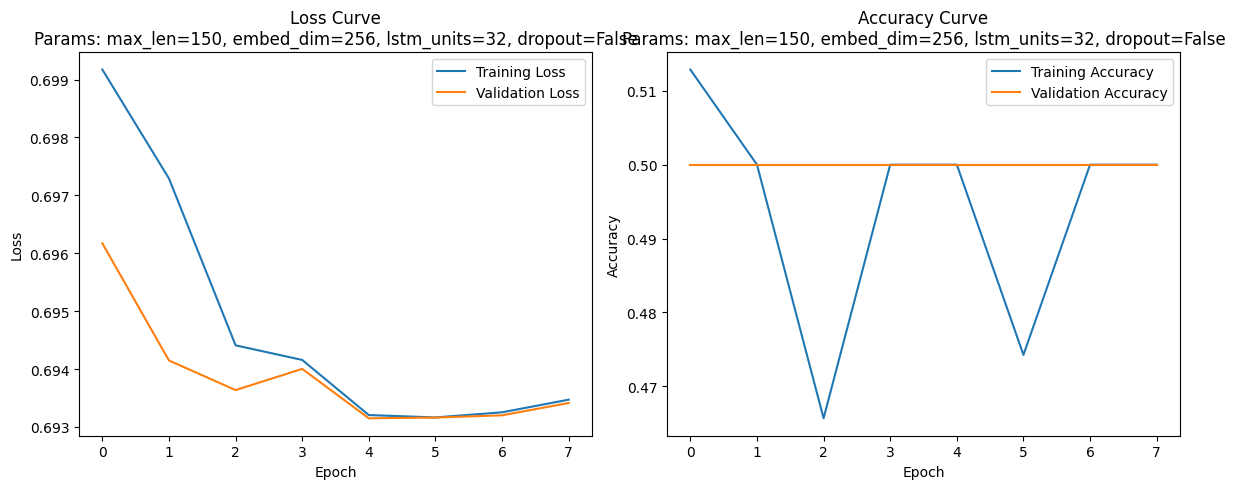


Training model with max_len=150, embedding_dim=256, lstm_units=32, use_dropout=True
Epoch 1: train_loss=0.7125, val_loss=0.6933, train_acc=0.4871, val_acc=0.5000
Epoch 2: train_loss=0.7043, val_loss=0.6932, train_acc=0.4871, val_acc=0.5000
Epoch 3: train_loss=0.6980, val_loss=0.6944, train_acc=0.4785, val_acc=0.5000
Epoch 4: train_loss=0.6932, val_loss=0.6932, train_acc=0.4936, val_acc=0.5000
Epoch 5: train_loss=0.6929, val_loss=0.6933, train_acc=0.4979, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


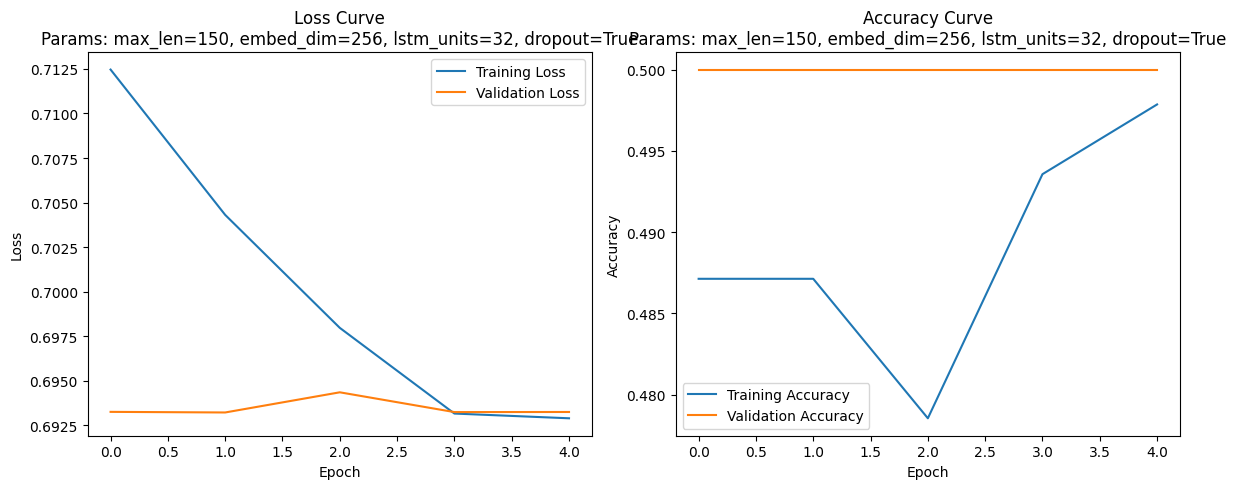


Training model with max_len=150, embedding_dim=256, lstm_units=64, use_dropout=False
Epoch 1: train_loss=0.7007, val_loss=0.7043, train_acc=0.5043, val_acc=0.5000
Epoch 2: train_loss=0.6971, val_loss=0.6935, train_acc=0.5000, val_acc=0.5000
Epoch 3: train_loss=0.6943, val_loss=0.6949, train_acc=0.5000, val_acc=0.5000
Epoch 4: train_loss=0.6956, val_loss=0.6936, train_acc=0.5000, val_acc=0.5000
Epoch 5: train_loss=0.6939, val_loss=0.6933, train_acc=0.5000, val_acc=0.5000
Epoch 6: train_loss=0.6950, val_loss=0.6941, train_acc=0.5043, val_acc=0.5000
Epoch 7: train_loss=0.6942, val_loss=0.6935, train_acc=0.5000, val_acc=0.5000
Epoch 8: train_loss=0.6937, val_loss=0.6934, train_acc=0.4871, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1-score: 0.6667


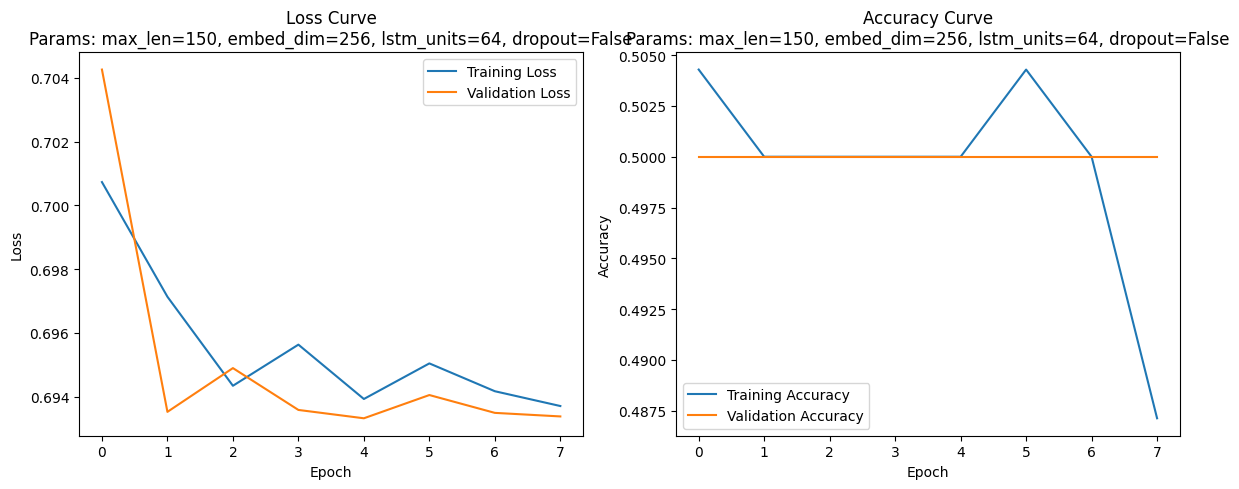


Training model with max_len=150, embedding_dim=256, lstm_units=64, use_dropout=True
Epoch 1: train_loss=0.7256, val_loss=0.6976, train_acc=0.4871, val_acc=0.5000
Epoch 2: train_loss=0.7000, val_loss=0.6941, train_acc=0.5000, val_acc=0.5000
Epoch 3: train_loss=0.7006, val_loss=0.6932, train_acc=0.4614, val_acc=0.5000
Epoch 4: train_loss=0.6936, val_loss=0.6932, train_acc=0.5150, val_acc=0.5000
Epoch 5: train_loss=0.6973, val_loss=0.6932, train_acc=0.4657, val_acc=0.5000
Epoch 6: train_loss=0.6929, val_loss=0.6931, train_acc=0.5236, val_acc=0.5000
Epoch 7: train_loss=0.6969, val_loss=0.6932, train_acc=0.4957, val_acc=0.5000
Epoch 8: train_loss=0.6898, val_loss=0.6932, train_acc=0.5193, val_acc=0.5000
Epoch 9: train_loss=0.6929, val_loss=0.6931, train_acc=0.4893, val_acc=0.5000
Epoch 10: train_loss=0.6983, val_loss=0.6932, train_acc=0.4721, val_acc=0.5000
Epoch 11: train_loss=0.6950, val_loss=0.6932, train_acc=0.4957, val_acc=0.5000
Epoch 12: train_loss=0.6953, val_loss=0.6935, train_acc

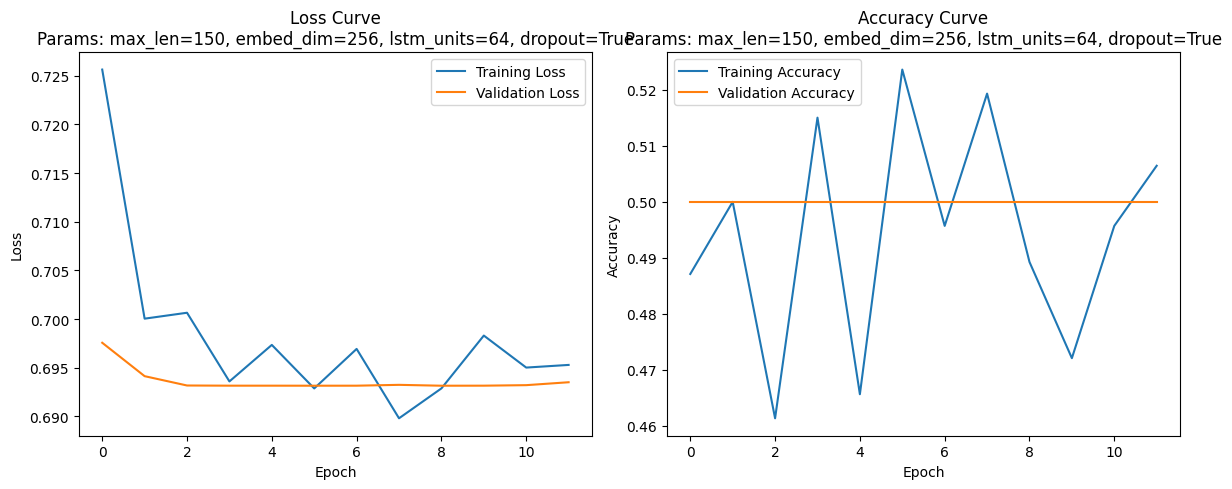


Training model with max_len=150, embedding_dim=256, lstm_units=128, use_dropout=False
Epoch 1: train_loss=0.7275, val_loss=0.6978, train_acc=0.4742, val_acc=0.5000
Epoch 2: train_loss=0.6906, val_loss=0.7014, train_acc=0.5343, val_acc=0.5000
Epoch 3: train_loss=0.7009, val_loss=0.6941, train_acc=0.5000, val_acc=0.5000
Epoch 4: train_loss=0.6937, val_loss=0.6971, train_acc=0.5215, val_acc=0.5000
Epoch 5: train_loss=0.6983, val_loss=0.6935, train_acc=0.5000, val_acc=0.5000
Epoch 6: train_loss=0.6937, val_loss=0.6936, train_acc=0.5000, val_acc=0.5000
Epoch 7: train_loss=0.6932, val_loss=0.6932, train_acc=0.5000, val_acc=0.5000
Epoch 8: train_loss=0.6930, val_loss=0.6933, train_acc=0.5129, val_acc=0.5000
Epoch 9: train_loss=0.6934, val_loss=0.6937, train_acc=0.5000, val_acc=0.5000
Epoch 10: train_loss=0.6940, val_loss=0.6935, train_acc=0.5000, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


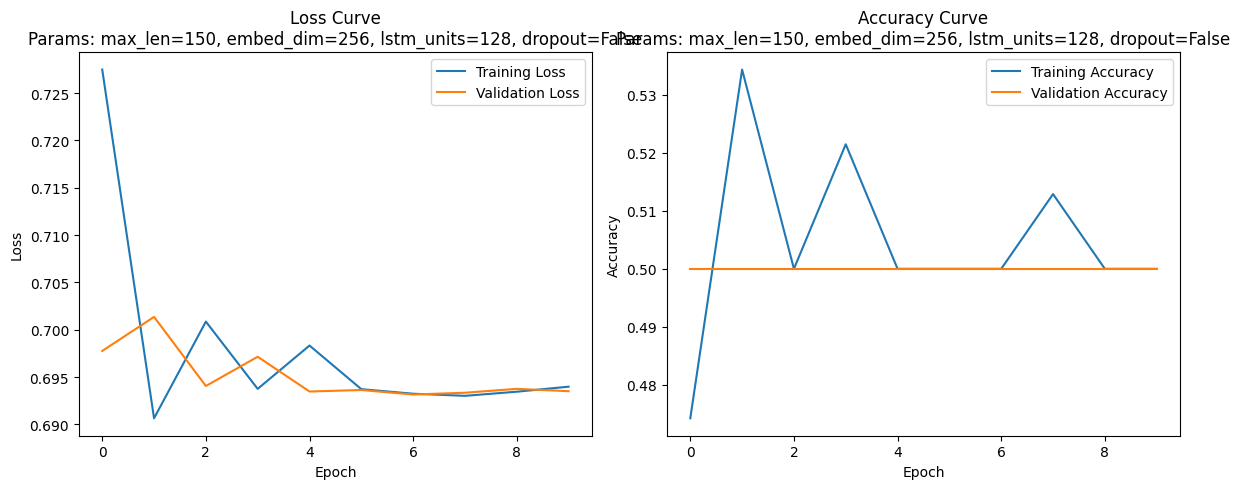


Training model with max_len=150, embedding_dim=256, lstm_units=128, use_dropout=True
Epoch 1: train_loss=0.7001, val_loss=0.6933, train_acc=0.4957, val_acc=0.5000
Epoch 2: train_loss=0.7005, val_loss=0.6948, train_acc=0.4957, val_acc=0.5000
Epoch 3: train_loss=0.6961, val_loss=0.6944, train_acc=0.5300, val_acc=0.5000
Epoch 4: train_loss=0.6996, val_loss=0.6935, train_acc=0.4828, val_acc=0.5000
Early stopping triggered
Test Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1-score: 0.6667


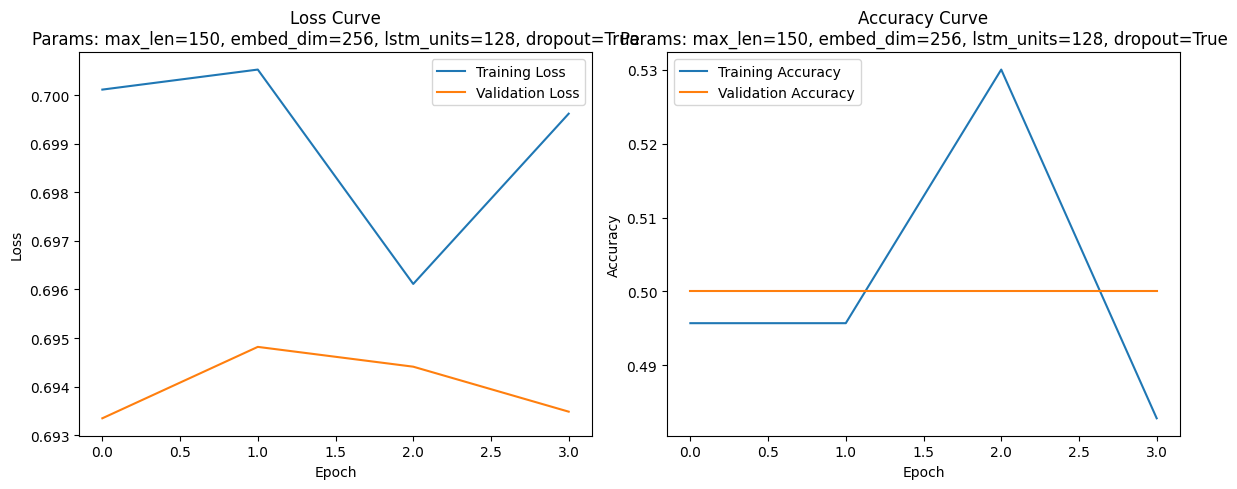

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 20
patience = 3
max_words = 20000

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, use_dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return self.sigmoid(out).squeeze()

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test,
                       max_len, embedding_dim, lstm_units, use_dropout):

    print(f"\nTraining model with max_len={max_len}, embedding_dim={embedding_dim}, lstm_units={lstm_units}, use_dropout={use_dropout}")

    from torch.nn.utils.rnn import pad_sequence
    import torch.nn.functional as F
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
    X_val_padded = pad_sequences(X_val, maxlen=max_len, padding='post', truncating='post')
    X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

    # convert to tensors
    X_train_t = torch.tensor(X_train_padded, dtype=torch.long)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val_padded, dtype=torch.long)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)
    X_test_t = torch.tensor(X_test_padded, dtype=torch.long)
    y_test_t = torch.tensor(y_test, dtype=torch.float32)

    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds = TensorDataset(X_val_t, y_val_t)
    test_ds = TensorDataset(X_test_t, y_test_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    model = LSTMModel(max_words, embedding_dim, lstm_units, use_dropout).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    best_val_loss = float('inf')
    counter = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            train_preds.extend((preds > 0.5).cpu().numpy())
            train_labels.extend(yb.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)

        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                val_preds.extend((preds > 0.5).cpu().numpy())
                val_labels.extend(yb.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(best_state)

    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            test_preds.extend((preds > 0.5).cpu().numpy())
            test_labels.extend(yb.cpu().numpy())

    acc = accuracy_score(test_labels, test_preds)
    prec = precision_score(test_labels, test_preds)
    rec = recall_score(test_labels, test_preds)
    f1 = f1_score(test_labels, test_preds)

    print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Loss Curve\nParams: max_len={max_len}, embed_dim={embedding_dim}, lstm_units={lstm_units}, dropout={use_dropout}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'Accuracy Curve\nParams: max_len={max_len}, embed_dim={embedding_dim}, lstm_units={lstm_units}, dropout={use_dropout}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'params': {'max_len': max_len, 'embedding_dim': embedding_dim, 'lstm_units': lstm_units, 'use_dropout': use_dropout},
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'test_metrics': {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
    }


max_lens = [80, 100, 150]
embedding_dims = [64, 128, 256]
lstm_units_list = [32, 64, 128]
dropout_options = [False, True]

results = []

for max_len in max_lens:
    for embedding_dim in embedding_dims:
        for lstm_units in lstm_units_list:
            for use_dropout in dropout_options:
                res = train_and_evaluate(
                    X_train, y_train, X_val, y_val, X_test, y_test,
                    max_len, embedding_dim, lstm_units, use_dropout
                )
                results.append(res)


5

Epoch 1/20 - Train loss: 0.6182, Train acc: 0.6545 - Val loss: 0.5419, Val acc: 0.7821
Epoch 2/20 - Train loss: 0.5424, Train acc: 0.8240 - Val loss: 0.5026, Val acc: 0.8333
Epoch 3/20 - Train loss: 0.4530, Train acc: 0.8369 - Val loss: 0.3960, Val acc: 0.8376
Epoch 4/20 - Train loss: 0.3439, Train acc: 0.8755 - Val loss: 0.4213, Val acc: 0.8547
Epoch 5/20 - Train loss: 0.3081, Train acc: 0.9099 - Val loss: 0.2445, Val acc: 0.9103
Epoch 6/20 - Train loss: 0.1273, Train acc: 0.9850 - Val loss: 0.1321, Val acc: 0.9402
Epoch 7/20 - Train loss: 0.0790, Train acc: 0.9914 - Val loss: 0.1176, Val acc: 0.9530
Epoch 8/20 - Train loss: 0.0588, Train acc: 0.9936 - Val loss: 0.1157, Val acc: 0.9573
Epoch 9/20 - Train loss: 0.0474, Train acc: 0.9957 - Val loss: 0.1197, Val acc: 0.9487
Epoch 10/20 - Train loss: 0.0413, Train acc: 0.9957 - Val loss: 0.1022, Val acc: 0.9658
Epoch 11/20 - Train loss: 0.0385, Train acc: 0.9957 - Val loss: 0.0997, Val acc: 0.9658
Epoch 12/20 - Train loss: 0.0387, Train a

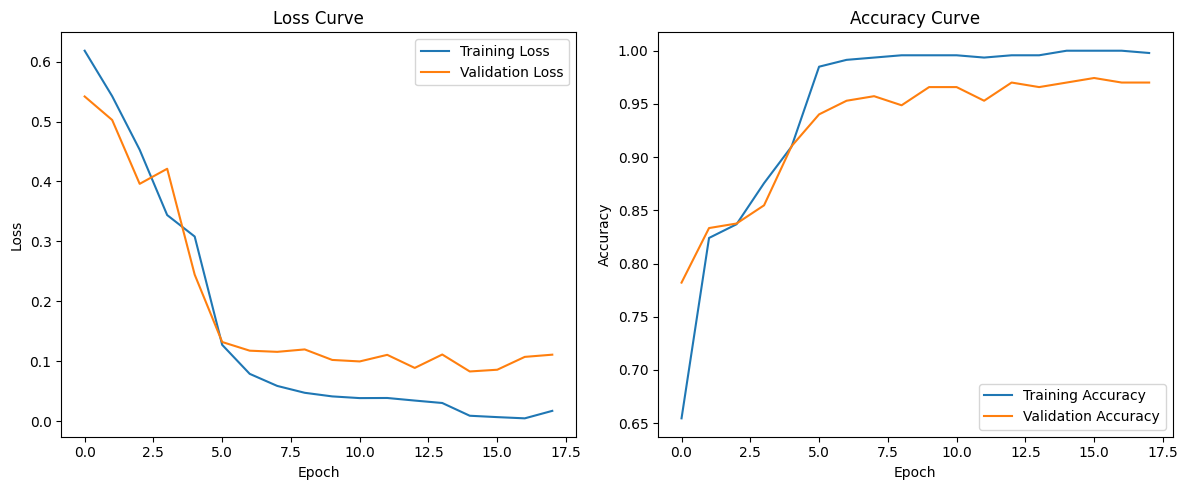

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_words = 20000
max_len = 100
embedding_dim = 256
lstm_units = 128
use_dropout = True
batch_size = 32
epochs = 20

X_train_t = torch.tensor(X_train, dtype=torch.long)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.long)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_units, use_dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, lstm_units, batch_first=True, bidirectional=True)
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(lstm_units * 2, 1)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        if self.use_dropout:
            out = self.dropout(out)
        out = self.fc(out)
        return torch.sigmoid(out).squeeze()

model = BiLSTMModel(max_words, embedding_dim, lstm_units, use_dropout).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

def train(model, loader):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, accuracy

def evaluate(model, loader):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, accuracy, all_labels, all_preds

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
patience = 3
trigger_times = 0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc, y_val_true, y_val_pred = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} - "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

model.load_state_dict(best_model_state)

accuracy = accuracy_score(y_val_true, y_val_pred)
precision = precision_score(y_val_true, y_val_pred)
recall = recall_score(y_val_true, y_val_pred)
f1 = f1_score(y_val_true, y_val_pred)

print("\nBidirectional LSTM Performance (PyTorch):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



6


=== Testing 1 Conv+Pool layers ===
Epoch 1/20  Train Loss: 0.6377, Acc: 0.7210  Val Loss: 0.5365, Acc: 0.8291
Epoch 2/20  Train Loss: 0.5162, Acc: 0.7768  Val Loss: 0.4287, Acc: 0.8333
Epoch 3/20  Train Loss: 0.4365, Acc: 0.7768  Val Loss: 0.3589, Acc: 0.8333
Epoch 4/20  Train Loss: 0.3238, Acc: 0.8219  Val Loss: 0.2501, Acc: 0.8932
Epoch 5/20  Train Loss: 0.1795, Acc: 0.9528  Val Loss: 0.1961, Acc: 0.9402
Epoch 6/20  Train Loss: 0.1342, Acc: 0.9571  Val Loss: 0.1447, Acc: 0.9573
Epoch 7/20  Train Loss: 0.0678, Acc: 0.9850  Val Loss: 0.2171, Acc: 0.9274
Epoch 8/20  Train Loss: 0.0613, Acc: 0.9807  Val Loss: 0.0963, Acc: 0.9658
Epoch 9/20  Train Loss: 0.0339, Acc: 0.9979  Val Loss: 0.1165, Acc: 0.9530
Epoch 10/20  Train Loss: 0.0203, Acc: 1.0000  Val Loss: 0.0881, Acc: 0.9701
Epoch 11/20  Train Loss: 0.0117, Acc: 1.0000  Val Loss: 0.0823, Acc: 0.9744
Epoch 12/20  Train Loss: 0.0068, Acc: 1.0000  Val Loss: 0.0760, Acc: 0.9786
Epoch 13/20  Train Loss: 0.0052, Acc: 1.0000  Val Loss: 0.075

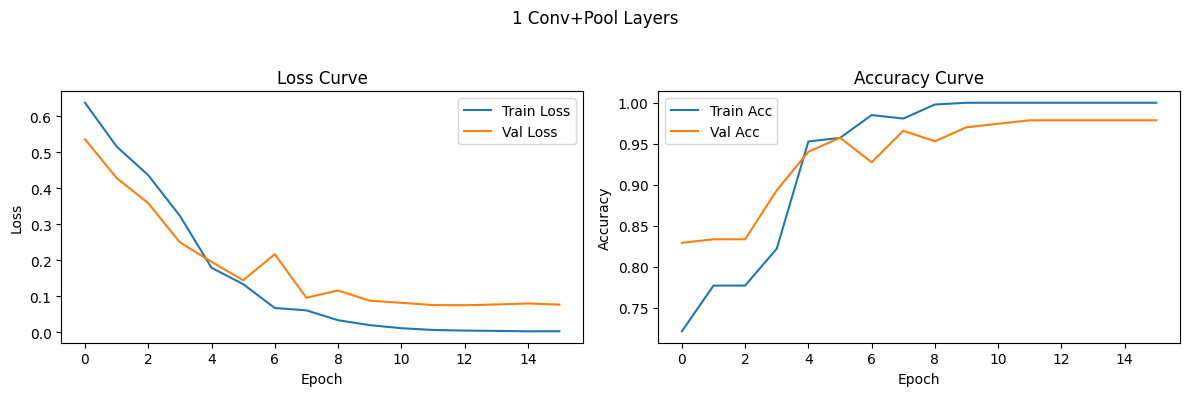


=== Testing 2 Conv+Pool layers ===
Epoch 1/20  Train Loss: 0.6321, Acc: 0.7275  Val Loss: 0.5038, Acc: 0.8291
Epoch 2/20  Train Loss: 0.5058, Acc: 0.7790  Val Loss: 0.4200, Acc: 0.8291
Epoch 3/20  Train Loss: 0.4305, Acc: 0.7811  Val Loss: 0.3308, Acc: 0.8462
Epoch 4/20  Train Loss: 0.2906, Acc: 0.8820  Val Loss: 0.2159, Acc: 0.9231
Epoch 5/20  Train Loss: 0.1646, Acc: 0.9506  Val Loss: 0.1537, Acc: 0.9530
Epoch 6/20  Train Loss: 0.0779, Acc: 0.9828  Val Loss: 0.1699, Acc: 0.9274
Epoch 7/20  Train Loss: 0.0349, Acc: 0.9957  Val Loss: 0.1432, Acc: 0.9444
Epoch 8/20  Train Loss: 0.0146, Acc: 0.9979  Val Loss: 0.1477, Acc: 0.9530
Epoch 9/20  Train Loss: 0.0061, Acc: 1.0000  Val Loss: 0.1596, Acc: 0.9573
Epoch 10/20  Train Loss: 0.0044, Acc: 1.0000  Val Loss: 0.1753, Acc: 0.9530
Early stopping.

Test Results with 2 conv layers:
Accuracy: 0.9733, Precision: 0.9797, Recall: 0.9667, F1-score: 0.9732


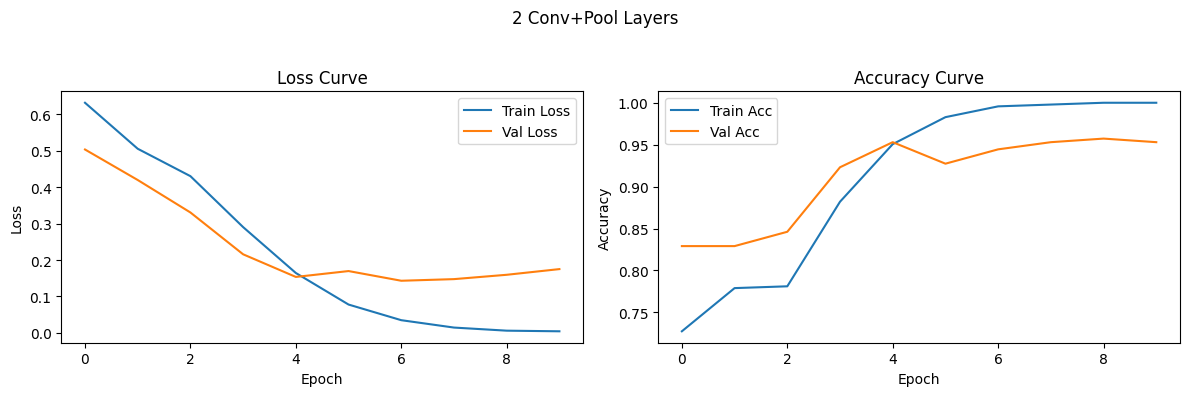


=== Testing 3 Conv+Pool layers ===
Epoch 1/20  Train Loss: 0.6137, Acc: 0.7017  Val Loss: 0.4657, Acc: 0.8248
Epoch 2/20  Train Loss: 0.4924, Acc: 0.7897  Val Loss: 0.4360, Acc: 0.8590
Epoch 3/20  Train Loss: 0.4061, Acc: 0.8562  Val Loss: 0.3172, Acc: 0.8761
Epoch 4/20  Train Loss: 0.2556, Acc: 0.9206  Val Loss: 0.2144, Acc: 0.9188
Epoch 5/20  Train Loss: 0.1567, Acc: 0.9549  Val Loss: 0.1294, Acc: 0.9573
Epoch 6/20  Train Loss: 0.0897, Acc: 0.9807  Val Loss: 0.1223, Acc: 0.9573
Epoch 7/20  Train Loss: 0.0652, Acc: 0.9871  Val Loss: 0.1114, Acc: 0.9573
Epoch 8/20  Train Loss: 0.0485, Acc: 0.9893  Val Loss: 0.1252, Acc: 0.9487
Epoch 9/20  Train Loss: 0.0381, Acc: 0.9914  Val Loss: 0.1306, Acc: 0.9658
Epoch 10/20  Train Loss: 0.0322, Acc: 0.9957  Val Loss: 0.1396, Acc: 0.9615
Early stopping.

Test Results with 3 conv layers:
Accuracy: 0.9333, Precision: 0.9221, Recall: 0.9467, F1-score: 0.9342


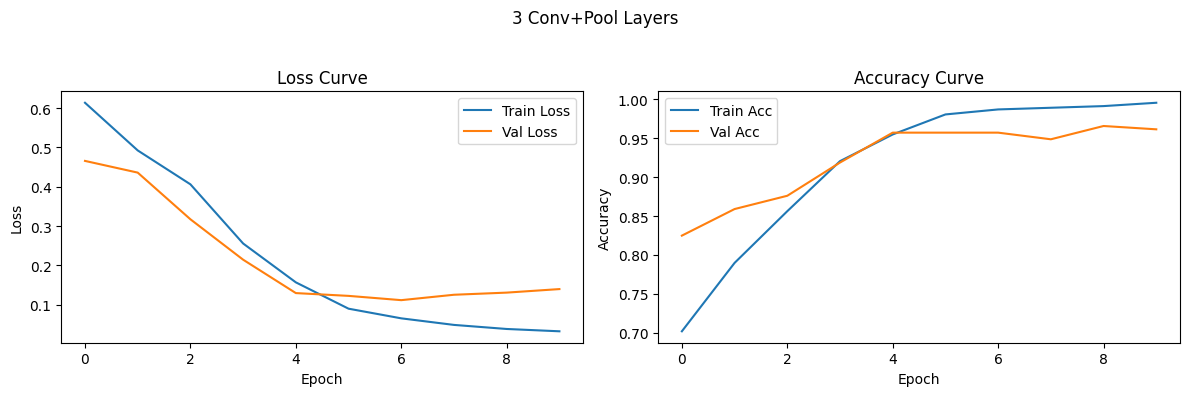


Summary of test results:
1 conv layers → Acc: 0.9567, Prec: 0.9597, Rec: 0.9533, F1: 0.9565
2 conv layers → Acc: 0.9733, Prec: 0.9797, Rec: 0.9667, F1: 0.9732
3 conv layers → Acc: 0.9333, Prec: 0.9221, Rec: 0.9467, F1: 0.9342


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

max_words     = 20000
max_len       = 100
embedding_dim = 256
lstm_units    = 128
use_dropout   = True
batch_size    = 64
epochs        = 20
patience      = 3
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train, dtype=torch.long)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.long)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size)

class ConvBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_units, use_dropout, n_conv_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        convs, pools = [], []
        in_ch = embed_dim
        for i in range(n_conv_layers):
            out_ch = 64 * (i+1)
            kernel = 5 if i % 2 == 0 else 3
            convs.append(nn.Conv1d(in_ch, out_ch, kernel_size=kernel, padding=kernel//2))
            pools.append(nn.MaxPool1d(kernel_size=2))
            in_ch = out_ch
        self.convs = nn.ModuleList(convs)
        self.pools = nn.ModuleList(pools)
        self.lstm = nn.LSTM(input_size=in_ch,
                            hidden_size=lstm_units,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(lstm_units*2, 1)

    def forward(self, x):
        x = self.embedding(x)        # (batch, seq_len, embed_dim)
        x = x.permute(0,2,1)         # (batch, embed_dim, seq_len)
        for conv, pool in zip(self.convs, self.pools):
            x = torch.relu(conv(x))
            x = pool(x)
        x = x.permute(0,2,1)         # (batch, seq_len_reduced, channels)
        lstm_out, (h_n, _) = self.lstm(x)
        h_fwd = h_n[0]
        h_bwd = h_n[1]
        h = torch.cat([h_fwd, h_bwd], dim=1)
        if self.use_dropout:
            h = self.dropout(h)
        return torch.sigmoid(self.fc(h)).squeeze()

summary = []
for n_layers in [1, 2, 3]:
    print(f"\n=== Testing {n_layers} Conv+Pool layers ===")
    model = ConvBiLSTM(max_words, embedding_dim, lstm_units, use_dropout, n_conv_layers=n_layers)\
            .to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_loss = float('inf')
    patience_ctr = 0

    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    for epoch in range(1, epochs+1):
        model.train()
        run_loss, preds, labs = 0, [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
            preds.extend((out>0.5).cpu().numpy())
            labs.extend(yb.cpu().numpy())
        train_loss = run_loss / len(train_loader.dataset)
        train_acc  = accuracy_score(labs, preds)

        model.eval()
        val_run_loss, v_preds, v_labs = 0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_run_loss += loss.item() * xb.size(0)
                v_preds.extend((out>0.5).cpu().numpy())
                v_labs.extend(yb.cpu().numpy())
        val_loss = val_run_loss / len(val_loader.dataset)
        val_acc  = accuracy_score(v_labs, v_preds)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch}/{epochs}  "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}  "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping.")
                break

    model.load_state_dict(best_state)

    model.eval()
    t_preds, t_labs = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            t_preds.extend((out>0.5).cpu().numpy())
            t_labs.extend(yb.cpu().numpy())

    acc  = accuracy_score(t_labs, t_preds)
    prec = precision_score(t_labs, t_preds)
    rec  = recall_score(t_labs, t_preds)
    f1   = f1_score(t_labs, t_preds)

    print(f"\nTest Results with {n_layers} conv layers:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

    plt.figure(figsize=(12,4))
    plt.suptitle(f"{n_layers} Conv+Pool Layers", fontsize=12)

    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs,   label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    summary.append({
        'n_conv_layers': n_layers,
        'test_accuracy':  acc,
        'test_precision': prec,
        'test_recall':    rec,
        'test_f1':        f1
    })

print("\nSummary of test results:")
for r in summary:
    print(f"{r['n_conv_layers']} conv layers → "
          f"Acc: {r['test_accuracy']:.4f}, Prec: {r['test_precision']:.4f}, "
          f"Rec: {r['test_recall']:.4f}, F1: {r['test_f1']:.4f}")


7

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

max_words     = 20000
max_len       = 100
embedding_dim = 256
lstm_units    = 128
use_dropout   = True
batch_size    = 64
epochs        = 20
patience      = 3
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train, dtype=torch.long)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.long)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size)

class ConvBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_units, use_dropout, n_conv_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        convs, pools = [], []
        in_ch = embed_dim
        for i in range(n_conv_layers):
            out_ch = 64 * (i+1)
            kernel = 5 if i % 2 == 0 else 3
            convs.append(nn.Conv1d(in_ch, out_ch, kernel_size=kernel, padding=kernel//2))
            pools.append(nn.MaxPool1d(kernel_size=2))
            in_ch = out_ch
        self.convs = nn.ModuleList(convs)
        self.pools = nn.ModuleList(pools)
        self.lstm = nn.LSTM(input_size=in_ch,
                            hidden_size=lstm_units,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(lstm_units*2, 1)

    def forward(self, x):
        x = self.embedding(x)        # (batch, seq_len, embed_dim)
        x = x.permute(0,2,1)         # (batch, embed_dim, seq_len)
        for conv, pool in zip(self.convs, self.pools):
            x = torch.relu(conv(x))
            x = pool(x)
        x = x.permute(0,2,1)         # (batch, seq_len_reduced, channels)
        lstm_out, (h_n, _) = self.lstm(x)
        h_fwd = h_n[0]
        h_bwd = h_n[1]
        h = torch.cat([h_fwd, h_bwd], dim=1)
        if self.use_dropout:
            h = self.dropout(h)
        return torch.sigmoid(self.fc(h)).squeeze()

summary = []
model = ConvBiLSTM(max_words, embedding_dim, lstm_units, use_dropout, n_conv_layers=2)\
        .to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
patience_ctr = 0

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(1, epochs+1):
    # Training
    model.train()
    run_loss, preds, labs = 0, [], []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        run_loss += loss.item() * xb.size(0)
        preds.extend((out>0.5).cpu().numpy())
        labs.extend(yb.cpu().numpy())
    train_loss = run_loss / len(train_loader.dataset)
    train_acc  = accuracy_score(labs, preds)

    # Validation
    model.eval()
    val_run_loss, v_preds, v_labs = 0, [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_run_loss += loss.item() * xb.size(0)
            v_preds.extend((out>0.5).cpu().numpy())
            v_labs.extend(yb.cpu().numpy())
    val_loss = val_run_loss / len(val_loader.dataset)
    val_acc  = accuracy_score(v_labs, v_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}/{epochs}  "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}  "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()
        patience_ctr = 0
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

model.load_state_dict(best_state)

model.eval()
t_preds, t_labs = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        t_preds.extend((out>0.5).cpu().numpy())
        t_labs.extend(yb.cpu().numpy())



Epoch 1/20  Train Loss: 0.6504, Acc: 0.6910  Val Loss: 0.5226, Acc: 0.8291
Epoch 2/20  Train Loss: 0.5099, Acc: 0.7747  Val Loss: 0.4227, Acc: 0.8376
Epoch 3/20  Train Loss: 0.4485, Acc: 0.7876  Val Loss: 0.3585, Acc: 0.8376
Epoch 4/20  Train Loss: 0.2981, Acc: 0.8670  Val Loss: 0.3199, Acc: 0.8932
Epoch 5/20  Train Loss: 0.2190, Acc: 0.9335  Val Loss: 0.2092, Acc: 0.9103
Epoch 6/20  Train Loss: 0.0936, Acc: 0.9893  Val Loss: 0.1572, Acc: 0.9444
Epoch 7/20  Train Loss: 0.0400, Acc: 0.9957  Val Loss: 0.1640, Acc: 0.9060
Epoch 8/20  Train Loss: 0.0204, Acc: 0.9979  Val Loss: 0.1558, Acc: 0.9402
Epoch 9/20  Train Loss: 0.0104, Acc: 1.0000  Val Loss: 0.1521, Acc: 0.9359
Epoch 10/20  Train Loss: 0.0060, Acc: 1.0000  Val Loss: 0.1594, Acc: 0.9316
Epoch 11/20  Train Loss: 0.0046, Acc: 1.0000  Val Loss: 0.1670, Acc: 0.9359
Epoch 12/20  Train Loss: 0.0034, Acc: 1.0000  Val Loss: 0.1719, Acc: 0.9359
Early stopping.


In [ ]:
import pandas as pd
import numpy as np

test_df = pd.DataFrame({
    'text':       df.loc[:len(y_test)-1, 'processed_text'].values,  
    'true_label': t_labs,
    'pred_label': t_preds
})

correct   = test_df[test_df.true_label == test_df.pred_label]
incorrect = test_df[test_df.true_label != test_df.pred_label]

n_samples = 5
correct_samples   = correct.sample(n_samples, random_state=42).reset_index(drop=True)
incorrect_samples = incorrect.sample(n_samples, random_state=42).reset_index(drop=True)

print("=== Correctly Classified Emails ===")
print(correct_samples[['text', 'true_label', 'pred_label']], end="\n\n")

print("=== Misclassified Emails ===")
print(incorrect_samples[['text', 'true_label', 'pred_label']])
correct_samples[['text', 'true_label', 'pred_label']].to_csv('correct_emails.csv', index=False, encoding='utf-8')
incorrect_samples[['text', 'true_label', 'pred_label']].to_csv('misclassified_emails.csv', index=False, encoding='utf-8')


=== Correctly Classified Emails ===
                                                text  true_label  pred_label
0  ﻿وقت نفر شرکت‌کننده ازمون نفر مهر نفر بهمن قبو...         0.0       False
1  ﻿موضوع رفع سوء تفاه فی‌مابین سلا احترا بدینوسی...         0.0       False
2  ﻿جعفر عزیز سلا مطلب طرح کنگره دارید می‌توانید ...         1.0        True
3  ﻿زهرا خان بله دانشجو علو تحقیقا نفر طریق آزمون...         1.0        True
4  ﻿بادرود کارشناس ارشد ادب فارس هس کوزه مطالع مق...         1.0        True

=== Misclassified Emails ===
                                                text  true_label  pred_label
0  سلا ممنون جواب راس وق تافل داد نمیدون پذیر خوب...         0.0        True
1  ﻿مینا جان همون عرض جوان ارزو استاد دانشگاه دا ...         1.0       False
2  Faramarz Dehgan faramarzdehgan gmail com عزیز ...         0.0        True
3  ﻿سلا خان سماوات وقتتون بخیر معرف صدیقه تهر وبل...         0.0        True
4  ﻿سلا خسته نباشید وبلاگ نظر گذاشته_بودید اون کت...         0.0        True


In [ ]:
print("incorrect_samples")
incorrect_samples.head(5)



incorrect_samples


text  true_label  pred_label
0  سلا ممنون جواب راس وق تافل داد نمیدون پذیر خوب...         0.0        True
1  ﻿مینا جان همون عرض جوان ارزو استاد دانشگاه دا ...         1.0       False
2  Faramarz Dehgan faramarzdehgan gmail com عزیز ...         0.0        True
3  ﻿سلا خان سماوات وقتتون بخیر معرف صدیقه تهر وبل...         0.0        True
4  ﻿سلا خسته نباشید وبلاگ نظر گذاشته_بودید اون کت...         0.0        True

In [ ]:
print("correct_samples")
correct_samples.head(5)

correct_samples


text  true_label  pred_label
0  ﻿وقت نفر شرکت‌کننده ازمون نفر مهر نفر بهمن قبو...         0.0       False
1  ﻿موضوع رفع سوء تفاه فی‌مابین سلا احترا بدینوسی...         0.0       False
2  ﻿جعفر عزیز سلا مطلب طرح کنگره دارید می‌توانید ...         1.0        True
3  ﻿زهرا خان بله دانشجو علو تحقیقا نفر طریق آزمون...         1.0        True
4  ﻿بادرود کارشناس ارشد ادب فارس هس کوزه مطالع مق...         1.0        True

1. تحلیل طول متن


<ipython-input-31-b9e2e0a6e1f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct['text_length'] = df['processed_text'].apply(lambda x: len(str(x).split()))
<ipython-input-31-b9e2e0a6e1f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect['text_length'] = df['processed_text'].apply(lambda x: len(str(x).split()))


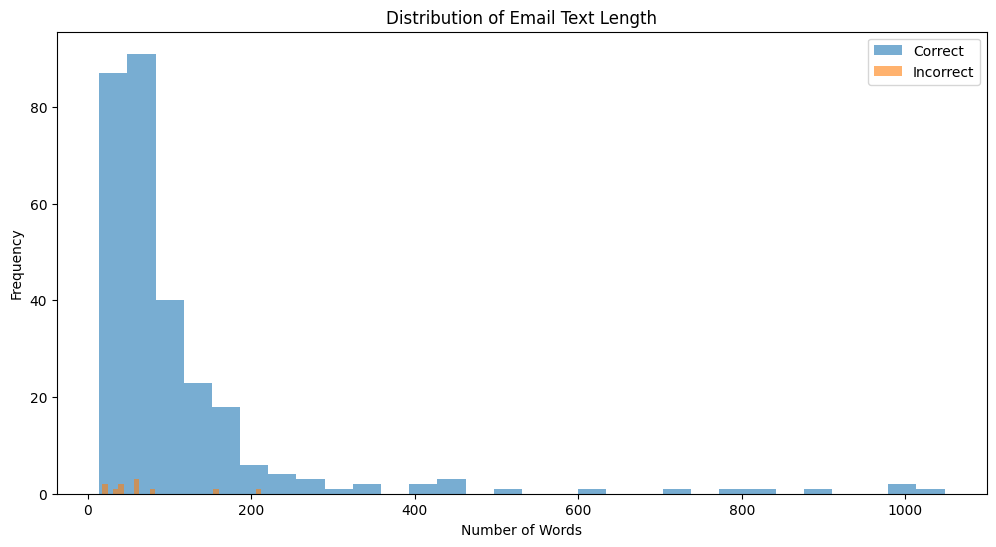

In [ ]:
import matplotlib.pyplot as plt

correct['text_length'] = df['processed_text'].apply(lambda x: len(str(x).split()))
incorrect['text_length'] = df['processed_text'].apply(lambda x: len(str(x).split()))



plt.figure(figsize=(12,6))
plt.hist(correct['text_length'], bins=30, alpha=0.6, label='Correct')
plt.hist(incorrect['text_length'], bins=30, alpha=0.6, label='Incorrect')
plt.title('Distribution of Email Text Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()


2. کلمات پرتکرار در متن ایمیل‌های درست و نادرست


In [ ]:
from collections import Counter
import re

def preprocess(text):
    text = re.sub(r'\W+', ' ', str(text).lower())
    return text.split()

correct_words = []
incorrect_words = []

for text in correct['text']:
    correct_words.extend(preprocess(text))

for text in incorrect['text']:
    incorrect_words.extend(preprocess(text))

correct_counter = Counter(correct_words)
incorrect_counter = Counter(incorrect_words)

print("Top 20 words in correctly classified emails:")
print(correct_counter.most_common(20))

print("\nTop 20 words in misclassified emails:")
print(incorrect_counter.most_common(20))





Top 20 words in correctly classified emails:
[('می', 675), ('دانشگاه', 299), ('کار', 192), ('سال', 166), ('نمی', 157), ('اون', 139), ('کشور', 139), ('هس', 121), ('دیگه', 111), ('سلا', 108), ('خود', 107), ('ایر', 106), ('مشکل', 105), ('زبانشناس', 105), ('دار', 102), ('اگه', 101), ('شده', 101), ('کتاب', 100), ('تو', 99), ('رشته', 98)]

Top 20 words in misclassified emails:
[('می', 17), ('چادر', 9), ('ادب', 8), ('کتاب', 8), ('هس', 8), ('دیگه', 7), ('داس', 7), ('سلا', 6), ('پذیر', 6), ('اگه', 6), ('ال', 6), ('شد', 5), ('دکتر', 5), ('خدا', 5), ('کار', 5), ('happy', 5), ('دانشگاه', 4), ('قبول', 4), ('سال', 4), ('وبلاگ', 4)]


In [ ]:
import pandas as pd
from collections import Counter
import re


def preprocess(text):
    text = re.sub(r'\W+', ' ', str(text).lower())
    return text.split()

incorrectt = df[df['label'] == 'ham']
correctt = df[df['label'] != 'ham']

correct_words = []
incorrect_words = []

for text in correctt['processed_text']:
    correct_words.extend(preprocess(text))

for text in incorrectt['processed_text']:
    incorrect_words.extend(preprocess(text))

correct_counter = Counter(correct_words)
incorrect_counter = Counter(incorrect_words)

print("Top 20 words in label=0 emails:")
print(correct_counter.most_common(20))

print("\nTop 20 words in label=1 emails:")
print(incorrect_counter.most_common(20))


Top 20 words in label=0 emails:
[('http', 4496), ('www', 2378), ('com', 2042), ('خرید', 1623), ('می', 1496), ('تو', 1416), ('aspx', 1307), ('محصول', 1234), ('d', 1074), ('قیم', 1050), ('php', 997), ('biz', 951), ('استفاده', 739), ('پست', 718), ('آموز', 714), ('کار', 709), ('ads', 682), ('سا', 642), ('cart', 617), ('adsid', 597)]

Top 20 words in label=1 emails:
[('می', 1079), ('دانشگاه', 432), ('کار', 291), ('نمی', 254), ('سال', 246), ('سلا', 220), ('هس', 211), ('کتاب', 200), ('اون', 198), ('دیگه', 170), ('دار', 169), ('خود', 164), ('درس', 164), ('اگه', 163), ('کشور', 161), ('زبانشناس', 154), ('رشته', 153), ('com', 147), ('دوس', 146), ('تو', 144)]


In [ ]:
import re

def contains_link(text):
    pattern = r'(www|http|com)'
    return 1 if re.search(pattern, str(text), re.IGNORECASE) else 0



test_df['has_link'] = test_df['text'].apply(contains_link)


correct   = test_df[test_df.true_label == test_df.pred_label]
incorrect = test_df[test_df.true_label != test_df.pred_label]

print("Percentage of emails with links:")
percent = correct[(correct['has_link'] == 1) & (correct['true_label'] == 0)].shape[0] / correct[correct['true_label'] == 0].shape[0]
print(f"Percent of correctly classified with link and true_label=0: {percent:.4f}")
print(correct[(correct['has_link'] == 1) & (correct['true_label'] == 0)].shape[0])
print(correct[correct['true_label'] == 0].shape[0])


percent = correct[(correct['has_link'] == 1) & (correct['true_label'] == 1)].shape[0] / correct[correct['true_label'] == 1].shape[0]
print(f"Percent of correctly classified with link and true_label=1: {percent:.4f}")
print(correct[(correct['has_link'] == 1) & (correct['true_label'] == 1)].shape[0])
print(correct[correct['true_label'] == 1].shape[0])


print(correct.shape)


Percentage of emails with links:
Percent of correctly classified with link and true_label=0: 0.1181
17
144
Percent of correctly classified with link and true_label=1: 0.1379
20
145
(289, 4)


In [ ]:
print("Percentage of emails with links:")
percent = incorrect[(incorrect['has_link'] == 1) & (incorrect['true_label'] == 0)].shape[0] / incorrect[incorrect['true_label'] == 0].shape[0]
print(f"Percent of correctly classified with link and true_label=0: {percent:.4f}")
print(incorrect[(incorrect['has_link'] == 1) & (incorrect['true_label'] == 0)].shape[0])
print(incorrect[incorrect['true_label'] == 0].shape[0])


percent = incorrect[(incorrect['has_link'] == 1) & (incorrect['true_label'] == 1)].shape[0] / incorrect[incorrect['true_label'] == 1].shape[0]
print(f"Percent of correctly classified with link and true_label=0: {percent:.4f}")
print(incorrect[(incorrect['has_link'] == 1) & (incorrect['true_label'] == 1)].shape[0])
print(incorrect[incorrect['true_label'] == 1].shape[0])



print(incorrect.shape)

Percentage of emails with links:
Percent of correctly classified with link and true_label=0: 0.1667
1
6
Percent of correctly classified with link and true_label=0: 0.0000
0
5
(11, 4)


4. استخراج embedding و بررسی خوشه‌بندی (اختیاری و پیشرفته)


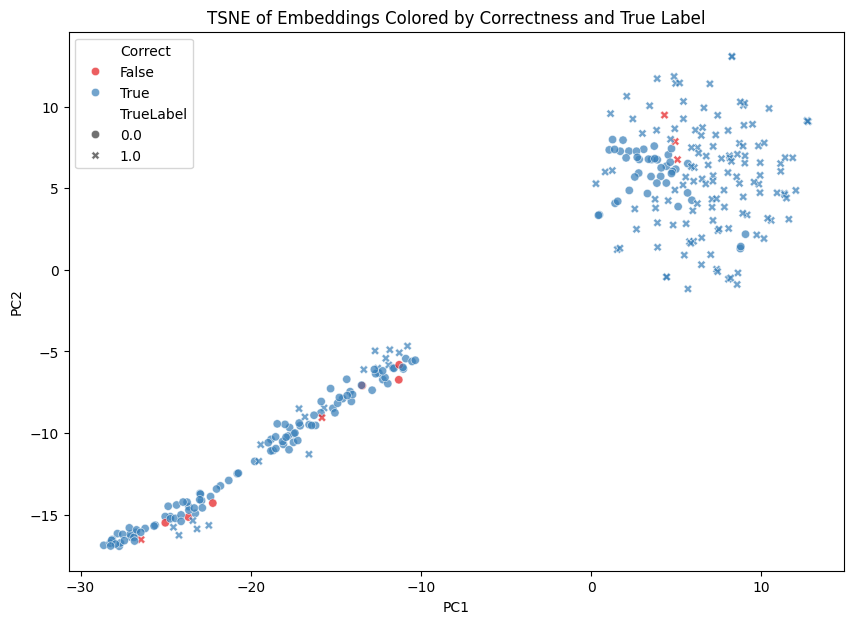

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

model.eval()

embedding_vectors = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        emb = model.embedding(xb)  # (batch, seq_len, embed_dim)

        emb_mean = emb.mean(dim=1)  # (batch, embed_dim)

        embedding_vectors.append(emb_mean.cpu().numpy())
        true_labels.append(yb.cpu().numpy())

        out = model(xb)
        preds = (out > 0.5).cpu().numpy()
        pred_labels.append(preds)

embedding_vectors = np.vstack(embedding_vectors)  # (num_samples, embed_dim)
true_labels = np.hstack(true_labels)
pred_labels = np.hstack(pred_labels)

tsne = TSNE(n_components=2)
embedding_2d = tsne.fit_transform(embedding_vectors)

df_emb = pd.DataFrame({
    'PC1': embedding_2d[:, 0],
    'PC2': embedding_2d[:, 1],
    'TrueLabel': true_labels,
    'PredLabel': pred_labels,
    'Correct': true_labels == pred_labels
})

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_emb,
    x='PC1',
    y='PC2',
    hue='Correct',
    style='TrueLabel',
    palette='Set1',
    alpha=0.7
)
plt.title("TSNE of Embeddings Colored by Correctness and True Label")
plt.show()
